## How to generate text: using different decoding methods for language generation with Transformers

In [ ]:
!pip install python-mlb-statsapi==0.5.10
!pip install MLB-StatsAPI

In [1]:
import math
import random
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import json
import scipy.stats
import matplotlib.pyplot as plt
from peft import PeftModel
import collections
from pybaseball import playerid_reverse_lookup
from pybaseball import playerid_lookup
from unidecode import unidecode 
from decimal import Decimal
from pandas._libs.missing import NAType
import mlbstatsapi

from datetime import datetime
import statsapi
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base model
base_path="../models/phi-2"  

# adapters: path to folder with adapter_model.safetensors
adapter_path="../models/phi-2-mlb/checkpoint-13100" 
      
# # Load model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    base_path,
    torch_dtype=torch.bfloat16,
).to(device)


if torch.cuda.device_count() > 1: # If more than 1 GPU
    base_model.is_parallelizable = False
    base_model.model_parallel = False

tokenizer = AutoTokenizer.from_pretrained(base_path)

# # Add/set tokens same tokens to base model before merging, like we did before training  
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))

base_model.config.eos_token_id = tokenizer.eos_token_id

# Load LoRA and merge
merged_model = PeftModel.from_pretrained(base_model, adapter_path).to(device)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


bin e:\src\transformer-sketchbook\.venv\lib\site-packages\bitsandbytes\libbitsandbytes_cuda121.dll


In [3]:
def remove_last_newline(s):
    last_newline_index = s.rfind('\n')  # Find the index of the last newline character
    if last_newline_index != -1:  # Check if newline character exists
        s = s[:last_newline_index]  # Remove the newline character
    return s

def extract_between_quotes(s):
    first_quote_index = s.find('"')
    if first_quote_index != -1:
        second_quote_index = s.find('"', first_quote_index + 1)
        if second_quote_index != -1:
            return s[first_quote_index + 1:second_quote_index]
    # print(s)
    return None

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if obj is None:
            return ""
        if isinstance(obj, Decimal):
            return str(obj)
        if isinstance(obj, NAType):
            return ""
        # 👇️ otherwise use the default behavior
        return json.JSONEncoder.default(self, obj)
    
def calculate_american_odds(dec_odds):
    return (dec_odds/(1.0-dec_odds) - 1.0)*100.0 if dec_odds >= 2.0 else -100.0/(dec_odds/(1.0-dec_odds) - 1.0) 

def calculate_dec_odds(probs, num_events):
    return float((1.0-math.pow(1-probs, num_events))/(1.0-(1.0-math.pow(1-probs, num_events))))

def calculate_dec_odds_handy_capped(probs, num_events, handy_cap):
    handy_cap_prob = math.pow(probs, handy_cap+0.5)
    return float((1.0-math.pow(1.0-handy_cap_prob, num_events))/(1.0-(1.0-math.pow(1-handy_cap_prob, num_events))))

def get_player_name(id):
    name_data = playerid_reverse_lookup([id], key_type='mlbam')
    if not name_data.empty:
        if "name_first" in name_data and 'name_last' in name_data:
            if len(name_data['name_first']) > 0 and len(name_data['name_last']) > 0:
                return f"{unidecode(name_data['name_first'][0])} {unidecode(name_data['name_last'][0])}"
            else:
                return id

In [4]:
date = "2024-04-15"

In [5]:

schedule = statsapi.schedule(end_date=date)
games = {}
got_hit = []
for game in schedule:
    print(game)
    box_score = statsapi.boxscore_data(game['game_id'], timecode=None)
    for player in box_score['away']['players']:
        if 'hits' in box_score['away']['players'][player]['stats']['batting']:
            if box_score['away']['players'][player]['stats']['batting']['hits'] > 0:
                got_hit.append(box_score['away']['players'][player]['person']['id'])

mlb = mlbstatsapi.Mlb()
for g in range(int(len(schedule))):
    game = schedule[g]
    print(game)
    home_pitch_id = 0
    if '' != game['home_probable_pitcher']:
        player = game['home_probable_pitcher'].split(" ")
        data = playerid_lookup(player[1], player[0])
        for index, row in data.iterrows():
            home_pitch_id = row.key_mlbam

    away_pitch_id = 0
    if '' != game['away_probable_pitcher']:
        player = game['away_probable_pitcher'].split(" ")
        data = playerid_lookup(player[1], player[0])
        for index, row in data.iterrows():
            away_pitch_id = row.key_mlbam

    box_score = statsapi.boxscore_data(game['game_id'], timecode=None)
    lineup = mlb.get_team_roster(game['away_id'])
    away_roster = []
    away_roster_names = {}
    for person in box_score['awayBatters']:
        if person['personId'] != 0:
            away_roster.append(person['personId'])
            away_roster_names[str(person['personId'])] = unidecode(person['namefield'])
    
    lineup = mlb.get_team_roster(game['home_id'])
    home_roster = []
    home_roster_names = {}
    for person in box_score['homeBatters']:
        if person['personId'] != 0:
            home_roster.append(person['personId'])
            home_roster_names[str(person['personId'])] = unidecode(person['namefield'])
    games[str(game['game_id'])] = {
            'away_name':game['away_name'],
            'home_name':game['home_name'],
            'home_starting':home_pitch_id,
            'away_starting':away_pitch_id,
            "away_name":game['away_name'],
            "home_name":game['home_name'],
            "away_id":game['away_id'],
            "home_id":game['home_id'],
            'away_roster':away_roster,
            'home_roster':home_roster,
            "away_roster_names":away_roster_names,
            'home_roster_names':home_roster_names
        }

with open(f'../data/games_{date}.json', 'w', encoding='utf-8') as f:
    json.dump(games, f, ensure_ascii=True, indent=4, allow_nan=True)
    f.close()

with open(f'../data/got_hit_{date}.json', 'w', encoding='utf-8') as f:
    json.dump(got_hit, f, ensure_ascii=True, indent=4, allow_nan=True)
    f.close()

{'game_id': 746974, 'game_datetime': '2024-04-15T15:10:00Z', 'game_date': '2024-04-15', 'game_type': 'R', 'status': 'Final', 'away_name': 'Cleveland Guardians', 'home_name': 'Boston Red Sox', 'away_id': 114, 'home_id': 111, 'doubleheader': 'N', 'game_num': 1, 'home_probable_pitcher': 'Kutter Crawford', 'away_probable_pitcher': 'Xzavion Curry', 'home_pitcher_note': '', 'away_pitcher_note': '', 'away_score': 6, 'home_score': 0, 'current_inning': 9, 'inning_state': 'Bottom', 'venue_id': 3, 'venue_name': 'Fenway Park', 'national_broadcasts': ['MLBN (out-of-market only)'], 'series_status': 'CLE leads 1-0', 'winning_team': 'Cleveland Guardians', 'losing_team': 'Boston Red Sox', 'winning_pitcher': 'Tim Herrin', 'losing_pitcher': 'Brennan Bernardino', 'save_pitcher': None, 'summary': '2024-04-15 - Cleveland Guardians (6) @ Boston Red Sox (0) (Final)'}
{'game_id': 747053, 'game_datetime': '2024-04-15T22:35:00Z', 'game_date': '2024-04-15', 'game_type': 'R', 'status': 'Final', 'away_name': 'Minne

In [10]:
with open(f'../data/players_data.json', 'r', encoding='utf-8') as f:
    players = json.load(f)

In [27]:
def generate_sequences(inning, pitcher, batter, top_k, top_p, temperature, num_returns):
    input = {
                'pitcher': players[str(pitcher)] if str(pitcher) in players else {
                            'id':pitcher,
                            'name':pitcher,
                            "throws":""
                        },
                'batter':  players[str(batter)] if str(batter) in players else {
                            'id':batter,
                            'name':batter,
                            "stand":""
                        },
                "at_bat_number":random.randint(0, 45),
                "inning_topbot":inning,
                "inning":random.randint(1, 10),
                "outs_when_up": random.randint(0, 2),
                "home_score": random.randint(0, 15),
                "away_score": random.randint(0, 15),
                "pitch_number": random.randint(0, 100),
            }
    
    input_string = json.dumps(input, ensure_ascii=True, allow_nan=True, cls=MyEncoder)
    input_string = f"Instruct: {input_string} Output: "
    input_tokens = tokenizer(input_string, return_tensors="pt").to(device)
    output_tokens = merged_model.generate(**input_tokens, max_new_tokens=15, do_sample=True, top_k=top_k, top_p=top_p, temperature=temperature, output_scores=True, return_dict_in_generate=True, num_return_sequences=num_returns)
    
    return output_tokens, input_tokens

In [13]:
def generate_samples(inning, game, team_name, pitcher, pitcher_name, batter, batter_name, top_k, top_p, temperature, num_returns, probs_for_graph, out):
    output_pick = {}
    for i in range(0, 5):
        output_tokens, input_tokens = generate_sequences(inning, pitcher, batter, top_k, top_p, temperature, num_returns)
        gen_sequences = output_tokens.sequences[:, input_tokens['input_ids'].shape[-1]:]

        keys = []

        for i in output_tokens.sequences:
            output_decode =tokenizer.decode(
                i[len(input_tokens[0]):],
                skip_special_tokens=True
                )
            if "single" in output_decode:
                keys.append("single")
            elif "double_play" in output_decode:
                keys.append("double_play")
            elif "triple_play" in output_decode:
                keys.append("triple_play")
            elif "triple" in output_decode:
                keys.append("triple")
            elif "double" in output_decode:
                keys.append("double")
            elif "home_run" in output_decode:
                keys.append("home_run")
            elif "field_out" in output_decode:
                keys.append("field_out")
            elif "fielders_choice_out" in output_decode:
                keys.append("fielders_choice_out")
            elif "fielders_choice" in output_decode:
                keys.append("fielders_choice")
            elif "field_out" in output_decode:
                keys.append("field_out")
            elif "sac_bunt" in output_decode:
                keys.append("sac_bunt")
            elif "force_out" in output_decode:
                keys.append("force_out")
            elif "strikeout" in output_decode:
                keys.append("strikeout")
            elif "field_error" in output_decode:
                keys.append("field_error")
            elif "hit_by_pitch" in output_decode:
                keys.append("hit_by_pitch")
            elif "walk" in output_decode:
                keys.append("walk")
            elif "caught_stealing" in output_decode:
                keys.append("caught_stealing_2b")
            elif "sac_fly" in output_decode:
                keys.append("sac_fly")
            elif 'foul_tip' in output_decode:
                keys.append("foul_tip")
            elif 'bunt' in output_decode:
                keys.append('bunt')
            else:
                keys.append("+")

            probs = torch.stack(output_tokens.scores, dim=1).softmax(-1)
            gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
            unique_prob_per_sequence = gen_probs.prod(-1).cpu().numpy()
            count = 0
            for k in keys:
                if k is not None and k != "+":
                    if k not in probs_for_graph:
                        probs_for_graph[k] = float(unique_prob_per_sequence[count])
                    else:
                        probs_for_graph[k] += float(unique_prob_per_sequence[count])
                        probs_for_graph[k] /= 2
                count+=1

    for k in probs_for_graph:
        if 'single' in k or ('double' == k) or ('triple' == k) or 'home_run' in k:
            probs_for_graph['hit'] += float(probs_for_graph[k])
            probs_for_graph['obp'] += float(probs_for_graph[k])
        elif 'walk' in k or 'hit_by_pitch' in k or 'field_error' in k or 'fielders_choice' in k:
            probs_for_graph['obp'] += float(probs_for_graph[k])
        else:
            probs_for_graph['out'] +=float( probs_for_graph[k])

        od = collections.OrderedDict(sorted(probs_for_graph.items()))

        hit_3 = calculate_american_odds(calculate_dec_odds(probs_for_graph['hit'], 3))
        hit_4 = calculate_american_odds(calculate_dec_odds(probs_for_graph['hit'], 4))
        single_3 = calculate_american_odds(calculate_dec_odds(probs_for_graph['single'], 3))
        single_4 = calculate_american_odds(calculate_dec_odds(probs_for_graph['single'], 4))
        double_3 = calculate_american_odds(calculate_dec_odds(probs_for_graph['double'], 3))
        double_4 = calculate_american_odds(calculate_dec_odds(probs_for_graph['double'], 4))
        triple_3 = calculate_american_odds(calculate_dec_odds(probs_for_graph['triple'], 3))
        triple_4 = calculate_american_odds(calculate_dec_odds(probs_for_graph['triple'], 4))
        home_run_3 = calculate_american_odds(calculate_dec_odds(probs_for_graph['home_run'], 3))
        home_run_4 = calculate_american_odds(calculate_dec_odds(probs_for_graph['home_run'], 4))
        

        out[game][batter] = {
                                    "name":batter_name,
                                    "team":team_name,
                                    "raw":dict(sorted(od.items(), key=lambda item: item[1], reverse=True)),
                                    "odds_dec":{
                                        "hit_3":float(calculate_dec_odds(probs_for_graph['hit'], 3)),
                                        "hit_4":float(calculate_dec_odds(probs_for_graph['hit'], 4)),
                                        "single_3":float(calculate_dec_odds(probs_for_graph['single'], 3)),
                                        "single_4":float(calculate_dec_odds(probs_for_graph['single'], 4)),
                                        "double_3":float(calculate_dec_odds(probs_for_graph['double'], 3)),
                                        "double_4":float(calculate_dec_odds(probs_for_graph['double'], 4)),
                                        "triple_3":float(calculate_dec_odds(probs_for_graph['triple'], 3)),
                                        "triple_4":float(calculate_dec_odds(probs_for_graph['triple'], 4)),
                                        "home_run_3":float(calculate_dec_odds(probs_for_graph['home_run'], 3)),
                                        "home_run_4":float(calculate_dec_odds(probs_for_graph['home_run'], 4)),
                                    },                        
                                    "odds_moneyline":{
                                        "hit_3": hit_3,
                                        "hit_4": hit_4,
                                        "single_3":single_3,
                                        "single_4":single_4,
                                        "double_3":double_3,
                                        "double_4":double_4,
                                        "triple_3":triple_3,
                                        "triple_4":triple_4,
                                        "home_run_3":home_run_3,
                                        "home_run_4":home_run_4 
                                    }
                                }
        if float(hit_3) < 0.0 or float(hit_4) < 0.0 or float(single_3) < 0.0 or float(single_4) < 0.0 or float(double_3) < 0.0 or float(double_4) < 0.0 or float(triple_3) < 0.0 or float(triple_4) < 0.0 or float(home_run_3) < 0.0 or float(home_run_4) < 0.0:
            output_pick = out[game][batter]

    return output_pick, out

In [29]:
obp_data= []
output_data = {}
num_returns = 25      
output_pick = {}
top_k = 90
top_p = 0.99
temperature = 1.0
for game in games:
    output_pick[game] = {
        games[game]["home_name"]:{},
        games[game]["away_name"]:{}
    }
    output_data[game] = {

    }
    home_starter = get_player_name(games[game]["home_starting"])
    away_starting = get_player_name(games[game]["away_starting"])
    for player in games[game]['away_roster']: 
        player_name = get_player_name(player)

        probs_for_graph = {
            'out':0,
            'hit':0,
            "obp":0,
            "single":0,
            "double":0,
            "triple":0,
            "home_run":0
        }
    
        output_pick[game][games[game]["away_name"]][player], output_data = (generate_samples('top', game, games[game]["away_name"], games[game]["home_starting"], home_starter, player, player_name, top_k, top_p, temperature, num_returns, probs_for_graph, output_data))
        print(json.dumps(output_data[game][player],indent=4, sort_keys=False))
        if player in got_hit:
            print("got hit")
                         
    for player in games[game]['home_roster']: 
        player_name = get_player_name(player)

        probs_for_graph = {
            'out':0,
            'hit':0,
            "obp":0,
            "single":0,
            "double":0,
            "triple":0,
            "home_run":0
        }

        output_pick[game][games[game]["home_name"]][player], output_data = generate_samples('bot', game, games[game]["home_name"], games[game]["away_starting"], away_starting, player, player_name, top_k, top_p, temperature, num_returns, probs_for_graph, output_data)
        print(json.dumps(output_data[game][player], indent=4, sort_keys=False))
        if player in got_hit:
            print("got hit")


with open(f'../data/odds-{date}.json', 'w', encoding='utf-8') as f:
    json.dump(output_data, f, ensure_ascii=True, indent=4, allow_nan=True, cls=MyEncoder)

with open(f'../data/picks-{date}.json', 'w', encoding='utf-8') as f:
    json.dump(output_pick, f, ensure_ascii=True, indent=4, allow_nan=True, cls=MyEncoder)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "steven kwan",
    "team": "Cleveland Guardians",
    "raw": {
        "obp": 0.5599612761724064,
        "out": 0.5089821634482345,
        "walk": 0.40407079458236694,
        "strikeout": 0.2777135372161865,
        "field_out": 0.16135242581367493,
        "hit": 0.13085978086733024,
        "single": 0.07956625151055152,
        "force_out": 0.05192615144362067,
        "double": 0.032897393471510286,
        "home_run": 0.01839613588526845,
        "double_play": 0.017990048974752426,
        "field_error": 0.017531332792714238,
        "hit_by_pitch": 0.00749936792999506,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5231071553991783,
        "hit_4": 0.7524297252278965,
        "single_3": 0.2823967177923409,
        "single_4": 0.39325260497773007,
        "double_3": 0.10556005445997942,
        "double_4": 0.14316727821517974,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.057282933604612854,
        "home_run_4": 0.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "andres gimenez",
    "team": "Cleveland Guardians",
    "raw": {
        "out": 0.92258641712942,
        "obp": 0.6620857556307175,
        "field_out": 0.5175889134407043,
        "hit": 0.3404037383341648,
        "strikeout": 0.3116409182548523,
        "walk": 0.3116409182548523,
        "single": 0.22314616177374091,
        "double": 0.09060657024383545,
        "double_play": 0.04394008591709486,
        "force_out": 0.04394008575643421,
        "home_run": 0.026651006316588444,
        "hit_by_pitch": 0.010041099041700363,
        "sac_fly": 0.005476413760334253,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 2.4847003846329456,
        "hit_4": 4.283080858936651,
        "single_3": 1.1329567658334265,
        "single_4": 1.745634585140843,
        "double_3": 0.3296721223429637,
        "double_4": 0.4621527700057041,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.08441183163563692,
        "home_run_4": 0.114103819568

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jose ramirez",
    "team": "Cleveland Guardians",
    "raw": {
        "out": 0.5743508024361437,
        "obp": 0.4949363744937789,
        "field_out": 0.3048709034919739,
        "walk": 0.2808687686920166,
        "hit": 0.1940669217546645,
        "strikeout": 0.1930380910635015,
        "single": 0.11708353478945416,
        "double": 0.07698338696521034,
        "force_out": 0.038266880646018686,
        "double_play": 0.03817492723464966,
        "field_error": 0.013395283970709174,
        "hit_by_pitch": 0.006605400076388657,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.9103065148931376,
        "hit_4": 1.3703041436793069,
        "single_3": 0.4529181608137507,
        "single_4": 0.645589609054667,
        "double_3": 0.2716612760737795,
        "double_4": 0.377723063827291,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "josh naylor",
    "team": "Cleveland Guardians",
    "raw": {
        "obp": 0.4688055904591621,
        "out": 0.4422206227837506,
        "walk": 0.26879414916038513,
        "field_out": 0.2574812173843384,
        "strikeout": 0.18473940539941225,
        "hit": 0.18332499387251738,
        "single": 0.1269693672657013,
        "double": 0.04355394180925036,
        "home_run": 0.012801684797565707,
        "field_error": 0.010595971714288055,
        "hit_by_pitch": 0.006090475711971521,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8359134631681714,
        "hit_4": 1.2480343458455079,
        "single_3": 0.5028358714053709,
        "single_4": 0.721401076957112,
        "double_3": 0.14292716491742882,
        "double_4": 0.19497294711991822,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03940974320766302,
        "home_run_4": 0.05288848978082216
    },
    "odds_moneyline": {
        "hit_3": -24.42392979493062,
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "bo naylor",
    "team": "Cleveland Guardians",
    "raw": {
        "out": 0.5428753707551983,
        "obp": 0.44988034474772576,
        "walk": 0.2928912341594696,
        "field_out": 0.25089910625706724,
        "strikeout": 0.22489596903342263,
        "hit": 0.15226717847508553,
        "single": 0.10774867981672287,
        "double": 0.02793070484949567,
        "force_out": 0.027243128046399598,
        "double_play": 0.019143247331239573,
        "sac_fly": 0.01836751028895378,
        "home_run": 0.01658779380886699,
        "hit_by_pitch": 0.004721932113170624,
        "sac_bunt": 0.002326409798115492,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6414324165922899,
        "hit_4": 0.9362614905479968,
        "single_3": 0.4077917064110518,
        "single_4": 0.5777972803916698,
        "double_3": 0.08870025406134827,
        "double_4": 0.11998214478401581,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.05146111

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "tyler freeman",
    "team": "Cleveland Guardians",
    "raw": {
        "obp": 0.5304304904459944,
        "out": 0.4853811367178013,
        "walk": 0.36924344301223755,
        "strikeout": 0.2239574790000914,
        "field_out": 0.18932349979877472,
        "hit": 0.14512720081647545,
        "single": 0.1057900374487648,
        "double": 0.03933716336771065,
        "double_play": 0.03773527219891548,
        "force_out": 0.023604944417779817,
        "field_error": 0.01053156889975071,
        "sac_fly": 0.008180327713489532,
        "hit_by_pitch": 0.005528277717530727,
        "sac_bunt": 0.0025796135887503624,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6006467750860324,
        "hit_4": 0.8723800507102164,
        "single_3": 0.3985612390971857,
        "single_4": 0.5640188520233054,
        "double_3": 0.12794267736715326,
        "double_4": 0.1741296054724902,
        "triple_3": 0.0,
        "triple_4": 0.0,
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "will brennan",
    "team": "Cleveland Guardians",
    "raw": {
        "out": 0.4936816741175113,
        "obp": 0.4823298125551715,
        "walk": 0.3357764482498169,
        "strikeout": 0.29632169008255005,
        "field_out": 0.17301949858676893,
        "hit": 0.14076334350050235,
        "single": 0.09620156990226247,
        "double": 0.03154231086096948,
        "force_out": 0.021460563548316713,
        "home_run": 0.013019462737270393,
        "hit_by_pitch": 0.005790020804852247,
        "double_play": 0.002879921899875626,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.576382520190579,
        "hit_4": 0.8346313652547254,
        "single_3": 0.35451947037567755,
        "single_4": 0.49869641865741987,
        "double_3": 0.10092578908107233,
        "double_4": 0.13678253725240946,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04009793447622714,
        "home_run_4": 0.05381807969670019
    },
    "odds_moneylin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "estevan florial",
    "team": "Cleveland Guardians",
    "raw": {
        "out": 0.525801335750657,
        "obp": 0.4555840951297813,
        "strikeout": 0.31753453612327576,
        "walk": 0.31753453612327576,
        "field_out": 0.18448856472969055,
        "hit": 0.129262923600665,
        "single": 0.09097516555974511,
        "double": 0.0277606462763883,
        "double_play": 0.017977256151425536,
        "home_run": 0.010527111764531583,
        "field_error": 0.00878663540584057,
        "sac_fly": 0.004864685703068972,
        "sac_bunt": 0.0009362930431962013,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5147427692846632,
        "hit_4": 0.7396098206227942,
        "single_3": 0.3312902618807412,
        "single_4": 0.46452573289760796,
        "double_3": 0.08812906622946359,
        "double_4": 0.11919874675099505,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03225810891007496,
        "home_run_4": 0.0432

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "gabriel arias",
    "team": "Cleveland Guardians",
    "raw": {
        "out": 0.5156673734095355,
        "obp": 0.4444051646140238,
        "walk": 0.303933322429657,
        "strikeout": 0.26527330249306813,
        "field_out": 0.22887195646762848,
        "hit": 0.12824862862571662,
        "single": 0.08707836270332336,
        "double": 0.027816371966324402,
        "double_play": 0.01714677170350496,
        "home_run": 0.013353893956068858,
        "field_error": 0.012223213558650192,
        "sac_bunt": 0.00437534274533391,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5094616452006503,
        "hit_4": 0.7315276978813818,
        "single_3": 0.31431510326227097,
        "single_4": 0.43968008815542126,
        "double_3": 0.08831619204699062,
        "double_4": 0.11945537927665278,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.041155940384889865,
        "home_run_4": 0.05524760499944816
    },
    "odds_moneyline

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "brayan rocchio",
    "team": "Cleveland Guardians",
    "raw": {
        "out": 0.6156826286812729,
        "obp": 0.41559513826467437,
        "field_out": 0.30524569749832153,
        "walk": 0.2827899158000946,
        "strikeout": 0.24956123530864716,
        "hit": 0.1120055912116949,
        "single": 0.09180845319917613,
        "double_play": 0.03492279350757599,
        "double": 0.02019713801251876,
        "force_out": 0.01807815555980863,
        "field_error": 0.015197288244962692,
        "sac_fly": 0.007874746806919575,
        "hit_by_pitch": 0.0056023430079221725,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.42813514280488985,
        "hit_4": 0.6082704222807247,
        "single_3": 0.33495809788365527,
        "single_4": 0.46990808556427327,
        "double_3": 0.06312391795539976,
        "double_4": 0.08503859214996155,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jarren duran",
    "team": "Boston Red Sox",
    "raw": {
        "obp": 0.535172780651175,
        "out": 0.47933030442384883,
        "walk": 0.3375736474990845,
        "field_out": 0.2222459465265274,
        "strikeout": 0.20474876463413197,
        "hit": 0.18037232917247975,
        "single": 0.10959411412477496,
        "double": 0.05282486973666248,
        "double_play": 0.024453753605484962,
        "force_out": 0.02158036350322807,
        "home_run": 0.012924927199691183,
        "field_error": 0.009772578845513635,
        "hit_by_pitch": 0.007454225134097214,
        "sac_fly": 0.006301476154476404,
        "triple": 0.0050284181113511295
    },
    "odds_dec": {
        "hit_3": 0.8161435155083541,
        "hit_4": 1.2158152782649736,
        "single_3": 0.4165631287540585,
        "single_4": 0.5909184240866139,
        "double_3": 0.1768175620534912,
        "double_4": 0.2424498115003373,
        "triple_3": 0.015238245359146783,
        "triple_4": 0.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "rafael devers",
    "team": "Boston Red Sox",
    "raw": {
        "out": 0.4805846074186196,
        "obp": 0.4791628811095867,
        "walk": 0.2730307877063751,
        "field_out": 0.26008206605911255,
        "hit": 0.1929805227960552,
        "strikeout": 0.16560155153429867,
        "single": 0.12897062301620987,
        "double": 0.044234028945735526,
        "double_play": 0.03260887786745266,
        "force_out": 0.02229211195775571,
        "home_run": 0.01977587083410981,
        "field_error": 0.013151570607156398,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.9026020077339442,
        "hit_4": 1.3575664051205183,
        "single_3": 0.5132183259880327,
        "single_4": 0.737275878372807,
        "double_3": 0.1453686934126855,
        "double_4": 0.19837777039632243,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.061753822833091075,
        "home_run_4": 0.08317454267992531
    },
    "odds_moneyline": {
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "tyler o'neill",
    "team": "Boston Red Sox",
    "raw": {
        "obp": 0.4775462269837454,
        "out": 0.46984574082078956,
        "walk": 0.29879704117774963,
        "strikeout": 0.2607903480529785,
        "field_out": 0.17360201478004456,
        "hit": 0.16451370541616844,
        "single": 0.109923051786609,
        "double": 0.042325597155310805,
        "force_out": 0.03256103095736762,
        "home_run": 0.01226505647424864,
        "field_error": 0.007629071055816894,
        "hit_by_pitch": 0.006606409334010415,
        "double_play": 0.002892347030398848,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7146757656117805,
        "hit_4": 1.0523086694867767,
        "single_3": 0.41813422837592834,
        "single_4": 0.5932714932371651,
        "double_3": 0.13853493555602292,
        "double_4": 0.18885388622072713,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03771655497712852,
        "home_run_4": 0.0506

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "david hamilton",
    "team": "Boston Red Sox",
    "raw": {
        "out": 0.535309500992563,
        "obp": 0.4588298286343977,
        "strikeout": 0.34217843413352966,
        "walk": 0.34217843413352966,
        "field_out": 0.1733738631012704,
        "hit": 0.10063371956674906,
        "single": 0.07635033130645752,
        "double": 0.02428338826029154,
        "force_out": 0.01975720375776291,
        "field_error": 0.009769496507942677,
        "hit_by_pitch": 0.00624817842617631,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.3746438640179321,
        "hit_4": 0.528458308839115,
        "single_3": 0.2690483349457003,
        "single_4": 0.3739498621167779,
        "double_3": 0.07653685659152222,
        "double_4": 0.10332943360680388,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": 249.4318012767738,
        "hit_4": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "triston casas",
    "team": "Boston Red Sox",
    "raw": {
        "obp": 0.5091914033884064,
        "out": 0.49872104229871184,
        "walk": 0.3552040159702301,
        "strikeout": 0.2766331732273102,
        "field_out": 0.17997360229492188,
        "hit": 0.13515323993227196,
        "single": 0.08981412313733017,
        "double": 0.030158731070383842,
        "double_play": 0.025725403451360762,
        "force_out": 0.01638886332511902,
        "home_run": 0.015180385724557932,
        "field_error": 0.012557104579173028,
        "hit_by_pitch": 0.006277042906731367,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5459039670716376,
        "hit_4": 0.7874888806319565,
        "single_3": 0.3262021354092086,
        "single_4": 0.45706736296602396,
        "double_3": 0.09622075107833156,
        "double_4": 0.13030944980119943,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.046959617988914716,
        "home_run_4": 0.0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "masataka yoshida",
    "team": "Boston Red Sox",
    "raw": {
        "out": 0.4968676519492255,
        "obp": 0.4713953381018422,
        "walk": 0.28373584151268005,
        "field_out": 0.23702403903007505,
        "strikeout": 0.19500862061977386,
        "hit": 0.1704330395754136,
        "single": 0.13402733206708894,
        "double": 0.03640570750832464,
        "force_out": 0.03389271007083248,
        "double_play": 0.02639154769368446,
        "field_error": 0.013041476137004793,
        "sac_bunt": 0.004550734534859657,
        "hit_by_pitch": 0.0041849808767437935,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7516432481795106,
        "hit_4": 1.111515202200181,
        "single_3": 0.5398820099711921,
        "single_4": 0.7782108685334284,
        "double_3": 0.11767964876389034,
        "double_4": 0.15990687935041523,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "wilyer abreu",
    "team": "Boston Red Sox",
    "raw": {
        "out": 0.5850030298363342,
        "obp": 0.43187273439801227,
        "field_out": 0.32455503940582275,
        "walk": 0.29752448201179504,
        "strikeout": 0.20448540151119232,
        "hit": 0.12176388834453115,
        "single": 0.08524219703616964,
        "double": 0.023398057349963544,
        "force_out": 0.019908340228489863,
        "double_play": 0.0199083334321535,
        "home_run": 0.013123633958397964,
        "field_error": 0.012584364041686058,
        "sac_fly": 0.012284749187529087,
        "sac_bunt": 0.0038611660711467266,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.476271134627843,
        "hit_4": 0.6809501625309877,
        "single_3": 0.30641642443001055,
        "single_4": 0.4281555404033721,
        "double_3": 0.07361173155178441,
        "double_4": 0.09933401180680564,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04042733

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "enmanuel valdez",
    "team": "Boston Red Sox",
    "raw": {
        "out": 0.6689818742053162,
        "field_out": 0.3682001233100891,
        "obp": 0.294252232055796,
        "hit": 0.2274430362807739,
        "strikeout": 0.20574258267879486,
        "single": 0.16023246943947828,
        "walk": 0.06680919577502209,
        "force_out": 0.05894623696086068,
        "double": 0.0480737350881097,
        "double_play": 0.03609293125557156,
        "home_run": 0.019136831753185923,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.1687448725311589,
        "hit_4": 1.8072297246411928,
        "single_3": 0.6885843654696893,
        "single_4": 1.0107759636081735,
        "double_3": 0.1592846107979698,
        "double_4": 0.21783026010451814,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.059679954867917745,
        "home_run_4": 0.08035451750317016
    },
    "odds_moneyline": {
        "hit_3": 12.616535801797609,
        "hi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "reese mcguire",
    "team": "Boston Red Sox",
    "raw": {
        "out": 0.5982002350670993,
        "obp": 0.43088705008408246,
        "strikeout": 0.25181761384010315,
        "walk": 0.25181761384010315,
        "field_out": 0.24241803586483002,
        "hit": 0.15018612620910823,
        "single": 0.1189502179140032,
        "force_out": 0.06896484601562125,
        "double": 0.03123590829510503,
        "double_play": 0.026541380648537484,
        "field_error": 0.01830718293786049,
        "hit_by_pitch": 0.010576127097010612,
        "sac_fly": 0.008458358698007373,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6294031407769172,
        "hit_4": 0.9173647207104244,
        "single_3": 0.4621726483843042,
        "single_4": 0.6595800579195713,
        "double_3": 0.09988151067376598,
        "double_4": 0.13534504436278388,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ceddanne rafaela",
    "team": "Boston Red Sox",
    "raw": {
        "out": 0.5340049392543733,
        "obp": 0.5131560881274331,
        "walk": 0.37869298458099365,
        "strikeout": 0.22968891263008118,
        "field_out": 0.2211153358221054,
        "hit": 0.13446310354643948,
        "single": 0.09574858099222183,
        "double_play": 0.04740126058459282,
        "double": 0.026996078202937174,
        "force_out": 0.018854012712836266,
        "home_run": 0.011718444351280465,
        "sac_fly": 0.011580138467252254,
        "sac_bunt": 0.005365279037505388,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5422090323112849,
        "hit_4": 0.7817946740691376,
        "single_3": 0.3524848316897749,
        "single_4": 0.49569555906678786,
        "double_3": 0.0855659876019568,
        "double_4": 0.11568511008362695,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03599564425069538,
        "home_run_4": 0.04827985

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "manuel margot",
    "team": "Minnesota Twins",
    "raw": {
        "out": 0.5417677093066143,
        "obp": 0.49719430665864195,
        "walk": 0.28757092356681824,
        "strikeout": 0.25378045439720154,
        "hit": 0.19410578596117897,
        "field_out": 0.18932601809501648,
        "single": 0.13881413964554667,
        "double_play": 0.05841773966386565,
        "force_out": 0.03434558302916357,
        "double": 0.027744234378460884,
        "home_run": 0.027547411937171425,
        "field_error": 0.008318404667079449,
        "hit_by_pitch": 0.007199192463565263,
        "sac_fly": 0.005897914121367087,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.9105829015181117,
        "hit_4": 1.3707614079309876,
        "single_3": 0.5657027997261302,
        "single_4": 0.818077690083888,
        "double_3": 0.08807396356301998,
        "double_4": 0.11912317934925395,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0874

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "alex kirilloff",
    "team": "Minnesota Twins",
    "raw": {
        "out": 0.5248644232177776,
        "obp": 0.4496395909729976,
        "walk": 0.2508223056793213,
        "strikeout": 0.2477041631937027,
        "field_out": 0.24252361059188843,
        "hit": 0.18408749807190855,
        "single": 0.134255513548851,
        "double": 0.027755007155720206,
        "force_out": 0.026436477899233174,
        "home_run": 0.022076977367337332,
        "field_error": 0.008298266305246216,
        "double_play": 0.008200171532953271,
        "hit_by_pitch": 0.006431520916521549,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.841065487631731,
        "hit_4": 1.2564496600813078,
        "single_3": 0.5410999161174372,
        "single_4": 0.7800863190416587,
        "double_3": 0.08811013255874636,
        "double_4": 0.11917278110685431,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.06926656805434478,
        "home_run_4": 0.0934

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ryan jeffers",
    "team": "Minnesota Twins",
    "raw": {
        "out": 0.5629806079458953,
        "obp": 0.4180647705002656,
        "strikeout": 0.33596065640449524,
        "walk": 0.26164641976356506,
        "field_out": 0.17225828766822815,
        "hit": 0.1414118369362285,
        "single": 0.10907045751810074,
        "double_play": 0.029050901381623362,
        "force_out": 0.025710762491548526,
        "home_run": 0.017618715974592192,
        "double": 0.014722663443535566,
        "field_error": 0.008917112369090319,
        "hit_by_pitch": 0.006089401431381702,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5799571538056959,
        "hit_4": 0.8401804517870399,
        "single_3": 0.4140667807535962,
        "single_4": 0.5871813800386191,
        "double_3": 0.04550116319037166,
        "double_4": 0.06112373075015505,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.05477483661840041,
        "home_run_4": 0.07

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "byron buxton",
    "team": "Minnesota Twins",
    "raw": {
        "out": 0.6186864888997264,
        "obp": 0.3773422055592505,
        "strikeout": 0.363765686750412,
        "walk": 0.2206350564956665,
        "field_out": 0.18651486933231354,
        "hit": 0.14329848010587515,
        "single": 0.10422062251789832,
        "double_play": 0.031337868422269974,
        "force_out": 0.03133779771192735,
        "double": 0.02383853690104492,
        "home_run": 0.015239320686931908,
        "field_error": 0.009534714896290097,
        "sac_fly": 0.005730266682803631,
        "hit_by_pitch": 0.0038739540614187717,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5904183863097715,
        "hit_4": 0.8564439882239533,
        "single_3": 0.3912232282102522,
        "single_4": 0.5530869131200219,
        "double_3": 0.07506574542659779,
        "double_4": 0.10131959318866968,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0471476

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "kyle farmer",
    "team": "Minnesota Twins",
    "raw": {
        "out": 0.5243119125486968,
        "obp": 0.507355071125235,
        "walk": 0.32836347818374634,
        "field_out": 0.24496665596961975,
        "strikeout": 0.22568070888519287,
        "hit": 0.16051724391383276,
        "single": 0.12079818546772003,
        "force_out": 0.02695662127577214,
        "double_play": 0.026707926418112038,
        "double": 0.02665604837239163,
        "home_run": 0.013063010073721099,
        "field_error": 0.012513214718637755,
        "hit_by_pitch": 0.0059611343090182345,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6903033842187319,
        "hit_4": 1.0135057831315761,
        "single_3": 0.47141192962157424,
        "single_4": 0.6735769937012012,
        "double_3": 0.08442868393111656,
        "double_4": 0.11412690459292867,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04023561953729118,
        "home_run_4": 0.054

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "willi castro",
    "team": "Minnesota Twins",
    "raw": {
        "out": 0.6019155891251988,
        "obp": 0.3732554808782137,
        "strikeout": 0.34678009152412415,
        "walk": 0.21033276617527008,
        "field_out": 0.20248168712605308,
        "hit": 0.15573507696964806,
        "single": 0.1125830188394064,
        "double": 0.030239653221997245,
        "double_play": 0.029499744065105915,
        "force_out": 0.018193254247307777,
        "home_run": 0.012912404908244413,
        "field_error": 0.00718763773329556,
        "sac_fly": 0.004960812162607908,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6617426342083391,
        "hit_4": 0.9682715565675567,
        "single_3": 0.4309247492836608,
        "single_4": 0.6124604100005494,
        "double_3": 0.0964951980939821,
        "double_4": 0.1306867740437643,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03975954946075893,
        "home_run_4": 0.0533609728

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jose miranda",
    "team": "Minnesota Twins",
    "raw": {
        "out": 0.5793376378218184,
        "obp": 0.3513621385555667,
        "field_out": 0.29584574699401855,
        "strikeout": 0.2363633066415787,
        "hit": 0.19472469160071926,
        "walk": 0.14516626298427687,
        "single": 0.14516626298427426,
        "force_out": 0.04712858418622107,
        "double": 0.027296462741638546,
        "home_run": 0.022261965874806444,
        "field_error": 0.011471183970570564,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.9149915039824981,
        "hit_4": 1.378058142362643,
        "single_3": 0.6008662128106734,
        "single_4": 0.8727223125275686,
        "double_3": 0.08657201236679456,
        "double_4": 0.117063905647326,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.06987360014127884,
        "home_run_4": 0.09423338644949124
    },
    "odds_moneyline": {
        "hit_3": -10.242197153641861,
        "h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "carlos santana",
    "team": "Minnesota Twins",
    "raw": {
        "out": 0.5298765598788814,
        "obp": 0.4289842535246884,
        "walk": 0.26060786843299866,
        "field_out": 0.24963946640491486,
        "strikeout": 0.22998562455206203,
        "hit": 0.15770279508724563,
        "single": 0.10530699238304919,
        "double": 0.035303748038131744,
        "double_play": 0.026754248939966557,
        "force_out": 0.023497219981937864,
        "home_run": 0.0170920546660647,
        "field_error": 0.010673590004444122,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6734160167164883,
        "hit_4": 0.9867286831253601,
        "single_3": 0.3962972107899855,
        "single_4": 0.5606439291495936,
        "double_3": 0.113853891204222,
        "double_4": 0.1546161695342106,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.05308023795691442,
        "home_run_4": 0.07139253778148943
    },
    "odds_moneyline": {
 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "christian vazquez",
    "team": "Minnesota Twins",
    "raw": {
        "out": 0.5764699398252272,
        "obp": 0.42170670955603706,
        "strikeout": 0.27951234579086304,
        "walk": 0.2497738748788835,
        "field_out": 0.21219688653951746,
        "hit": 0.1530762617585597,
        "single": 0.10412125289440155,
        "double_play": 0.035458218306303024,
        "force_out": 0.03380320842289107,
        "double": 0.03084042666512232,
        "home_run": 0.018114582199035844,
        "sac_fly": 0.015499280765652657,
        "field_error": 0.010192240588366985,
        "hit_by_pitch": 0.008664332330226898,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6461411923345424,
        "hit_4": 0.9436710981234322,
        "single_3": 0.3907603419254015,
        "single_4": 0.5523979628031859,
        "double_3": 0.09853558539972479,
        "double_4": 0.1334929929234092,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.05

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "matt wallner",
    "team": "Minnesota Twins",
    "raw": {
        "obp": 0.5246574300393574,
        "out": 0.4729964723955752,
        "walk": 0.3032284080982208,
        "strikeout": 0.23615451065395088,
        "hit": 0.20440588836149498,
        "field_out": 0.20062649250030518,
        "single": 0.12640440464022507,
        "double": 0.0627496084161161,
        "force_out": 0.03621546924131916,
        "home_run": 0.015251875305153805,
        "field_error": 0.011027659755200148,
        "hit_by_pitch": 0.005995473824441433,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.9857534215152084,
        "hit_4": 1.4959378060574153,
        "single_3": 0.4999220616189757,
        "single_4": 0.7169524086270825,
        "double_3": 0.21459952899594645,
        "double_4": 0.29591786773581713,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.047187652353879096,
        "home_run_4": 0.06340659717263411
    },
    "odds_moneyline": {


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "austin martin",
    "team": "Minnesota Twins",
    "raw": {
        "out": 0.6234506058837899,
        "obp": 0.4604170461505308,
        "strikeout": 0.36491647362709045,
        "walk": 0.2877747714519501,
        "hit": 0.17264227469858073,
        "field_out": 0.16884271522576455,
        "single": 0.13506850600242615,
        "force_out": 0.051832580938909883,
        "double_play": 0.029693695455759627,
        "double": 0.02369404094932892,
        "home_run": 0.013879727746825665,
        "sac_fly": 0.008165140636265278,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7657126190160449,
        "hit_4": 1.1341586172689313,
        "single_3": 0.5454496732217872,
        "single_4": 0.7867885305909814,
        "double_3": 0.07458847805994805,
        "double_4": 0.1006677446738559,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04282237086500314,
        "home_run_4": 0.05750018553241074
    },
    "odds_moneyline": {
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "edouard julien",
    "team": "Minnesota Twins",
    "raw": {
        "out": 0.5481284792004695,
        "obp": 0.4128376789389433,
        "strikeout": 0.27033787965774536,
        "walk": 0.24197538197040558,
        "field_out": 0.2329431772232056,
        "hit": 0.15705158258781302,
        "single": 0.11430125135305502,
        "double": 0.02522172220666946,
        "force_out": 0.02250721891456718,
        "home_run": 0.017528609028088532,
        "sac_fly": 0.014839418232440948,
        "hit_by_pitch": 0.013810714380724676,
        "double_play": 0.003851564603451152,
        "sac_bunt": 0.0036492205690592527,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6695406629771968,
        "hit_4": 0.9805964736283748,
        "single_3": 0.43926878586309187,
        "single_4": 0.6250093929361639,
        "double_3": 0.07964871432275235,
        "double_4": 0.1075838874526666,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.054484

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "gunnar henderson",
    "team": "Baltimore Orioles",
    "raw": {
        "out": 0.5874265130934078,
        "obp": 0.39371111613744786,
        "strikeout": 0.3142858147621155,
        "walk": 0.2447660267353058,
        "field_out": 0.23169471323490143,
        "hit": 0.14437774566048672,
        "single": 0.102033659006743,
        "double": 0.030293591460596472,
        "force_out": 0.025798149022978164,
        "double_play": 0.01564783607341269,
        "home_run": 0.007251800503581762,
        "triple": 0.004798694689565508,
        "hit_by_pitch": 0.00456734374165535
    },
    "odds_dec": {
        "hit_3": 0.5964443510035311,
        "hit_4": 0.8658284574842973,
        "single_3": 0.3810831473901434,
        "single_4": 0.5380121551800059,
        "double_3": 0.09667818020759646,
        "double_4": 0.13093836500414718,
        "triple_3": 0.014535361918799566,
        "triple_4": 0.019427282204311568,
        "home_run_3": 0.022074788703833302,
        "home_r

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "adley rutschman",
    "team": "Baltimore Orioles",
    "raw": {
        "out": 0.48733069681612906,
        "obp": 0.4703717040306056,
        "walk": 0.27755147218704224,
        "field_out": 0.2318577915430069,
        "hit": 0.19282023184356334,
        "strikeout": 0.19075815379619598,
        "single": 0.1309501802376189,
        "double": 0.04412678255676259,
        "double_play": 0.03546103462576866,
        "force_out": 0.02925371685115749,
        "home_run": 0.017743269049181873,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.9014687682399725,
        "hit_4": 1.355694286766929,
        "single_3": 0.5235825099100081,
        "single_4": 0.7531589964849101,
        "double_3": 0.14498321485942775,
        "double_4": 0.1978400419273388,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.055176133257849834,
        "home_run_4": 0.07423660231520757
    },
    "odds_moneyline": {
        "hit_3": -12.271344567098659,
     

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ryan o'hearn",
    "team": "Baltimore Orioles",
    "raw": {
        "out": 0.5882395380399622,
        "obp": 0.40629124036058784,
        "strikeout": 0.33536145091056824,
        "walk": 0.29595544934272766,
        "field_out": 0.19484606516854708,
        "hit": 0.09238961106166244,
        "single": 0.07626008940860629,
        "double_play": 0.026913027763206004,
        "force_out": 0.01669728601427778,
        "double": 0.016129521653056145,
        "field_error": 0.012525566853582859,
        "sac_fly": 0.010887163691222668,
        "hit_by_pitch": 0.00542061310261488,
        "sac_bunt": 0.0035345444921404123,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.33752412714478375,
        "hit_4": 0.4736765284378584,
        "single_3": 0.26867644408727814,
        "single_4": 0.3734130457512119,
        "double_3": 0.04999253526138867,
        "double_4": 0.06720605849007716,
        "triple_3": 0.0,
        "triple_4": 0.0,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ryan mountcastle",
    "team": "Baltimore Orioles",
    "raw": {
        "out": 0.560758873852588,
        "obp": 0.4625590859025484,
        "walk": 0.304887592792511,
        "field_out": 0.2601601779460907,
        "strikeout": 0.23744671046733856,
        "hit": 0.15767149311003742,
        "single": 0.11216188964215218,
        "force_out": 0.039774458887673746,
        "double": 0.03211373945739021,
        "double_play": 0.02337752655148506,
        "home_run": 0.013395864010495036,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6732294649742911,
        "hit_4": 0.9864333823298624,
        "single_3": 0.428889518777304,
        "single_4": 0.6094032257765807,
        "double_3": 0.10287686119765647,
        "double_4": 0.13946948743684937,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04128881808770533,
        "home_run_4": 0.05542717702410086
    },
    "odds_moneyline": {
        "hit_3": -94.31724997655701,
       

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "colton cowser",
    "team": "Baltimore Orioles",
    "raw": {
        "out": 0.47526467780643133,
        "obp": 0.4697591835906796,
        "walk": 0.34396347403526306,
        "strikeout": 0.23346352577209473,
        "field_out": 0.20083709060712285,
        "hit": 0.10799205175545733,
        "single": 0.09854915668667029,
        "force_out": 0.022846408803299578,
        "double_play": 0.016122875618748367,
        "field_error": 0.00971441250294447,
        "home_run": 0.009442895068787038,
        "hit_by_pitch": 0.008089245297014713,
        "sac_bunt": 0.0019947770051658154,
        "double": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.40894430987508834,
        "hit_4": 0.5795199052293964,
        "single_3": 0.3651295007215163,
        "single_4": 0.5143693201327668,
        "double_3": 0.0,
        "double_4": 0.0,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.028872235737434918,
        "home_run_4": 0.0386

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jordan westburg",
    "team": "Baltimore Orioles",
    "raw": {
        "obp": 0.4763312652371343,
        "out": 0.4575449386558016,
        "walk": 0.31633731722831726,
        "strikeout": 0.21502652764320385,
        "field_out": 0.2071041464805603,
        "hit": 0.14968283899496163,
        "single": 0.11543117533437908,
        "force_out": 0.029423953959949692,
        "double": 0.023956169200951515,
        "field_error": 0.010311109013855457,
        "home_run": 0.01029549445963105,
        "sac_bunt": 0.003606479847803712,
        "double_play": 0.002383830724284053,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6265116109211439,
        "hit_4": 0.9128293365250642,
        "single_3": 0.4447912816869645,
        "single_4": 0.633328285374646,
        "double_3": 0.07545449138450501,
        "double_4": 0.10185061105716234,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03153355054645567,
        "home_run_4": 0.042

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "cedric mullins",
    "team": "Baltimore Orioles",
    "raw": {
        "out": 0.6081218466817854,
        "obp": 0.4358262951524372,
        "strikeout": 0.29571327567100525,
        "walk": 0.29571327567100525,
        "field_out": 0.2470296025276184,
        "hit": 0.1288629645520265,
        "single": 0.08472329327843471,
        "force_out": 0.03862692357073405,
        "double": 0.030414586160745764,
        "double_play": 0.026752044912427664,
        "home_run": 0.013725085112846034,
        "field_error": 0.01125005492940545,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5126573673029593,
        "hit_4": 0.7364172406297599,
        "single_3": 0.304195718503402,
        "single_4": 0.4249195996420666,
        "double_3": 0.09708879531706478,
        "double_4": 0.13150299051316897,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04233192085466729,
        "home_run_4": 0.056837100002616575
    },
    "odds_moneyline": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "austin hays",
    "team": "Baltimore Orioles",
    "raw": {
        "obp": 0.5089330387522941,
        "out": 0.49032103456556797,
        "walk": 0.34372255206108093,
        "strikeout": 0.2362368255853653,
        "field_out": 0.17711396515369415,
        "hit": 0.14956810809555554,
        "single": 0.11159037053585052,
        "force_out": 0.05613093078136444,
        "double": 0.024283464644687218,
        "double_play": 0.02083931304514408,
        "home_run": 0.013694272915017791,
        "hit_by_pitch": 0.008371397852897644,
        "field_error": 0.007270980742760003,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6258534066578569,
        "hit_4": 0.9117973139706051,
        "single_3": 0.4261336534695139,
        "single_4": 0.6052658662982936,
        "double_3": 0.07653710942301796,
        "double_4": 0.10332977910535335,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04223423653684667,
        "home_run_4": 0.05

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jackson holliday",
    "team": "Baltimore Orioles",
    "raw": {
        "out": 0.5192959164924105,
        "obp": 0.45096910710375726,
        "walk": 0.28867071866989136,
        "strikeout": 0.2547510266304016,
        "field_out": 0.21415485441684723,
        "hit": 0.16229838843386593,
        "single": 0.12033586204045135,
        "double": 0.031861262846158867,
        "force_out": 0.030378793439012952,
        "double_play": 0.016339075744326692,
        "home_run": 0.010101263547255712,
        "sac_bunt": 0.0036721662618219852,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7011082357991398,
        "hit_4": 1.03068516559114,
        "single_3": 0.4690931671112945,
        "single_4": 0.6700614515432826,
        "double_3": 0.10201424308648536,
        "double_4": 0.13828132352829384,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.030926469077955612,
        "home_run_4": 0.0414463935697426
    },
    "odds_moneyline"

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "marcus semien",
    "team": "Texas Rangers",
    "raw": {
        "out": 0.5401182123504791,
        "obp": 0.4232816401069476,
        "field_out": 0.3537229001522064,
        "hit": 0.29469606998940745,
        "single": 0.2218850553035736,
        "walk": 0.10481108028293665,
        "strikeout": 0.09249544888734818,
        "double": 0.056788060316869976,
        "force_out": 0.05020812807032304,
        "double_play": 0.04369173524060138,
        "home_run": 0.016022954368963838,
        "field_error": 0.0121037141230671,
        "hit_by_pitch": 0.011670775711536407,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.8501721273396357,
        "hit_4": 3.0410552189845736,
        "single_3": 1.122602787670912,
        "single_4": 1.7278781909259222,
        "double_3": 0.1917142460379098,
        "double_4": 0.2634639108133678,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04965142140544218,
        "home_run_4": 0.06674380877

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "travis jankowski",
    "team": "Texas Rangers",
    "raw": {
        "obp": 0.488275366646284,
        "out": 0.4787613886487612,
        "walk": 0.3584032952785492,
        "strikeout": 0.246326744556427,
        "field_out": 0.18376536667346954,
        "hit": 0.12987207136773485,
        "single": 0.1026842563037711,
        "double": 0.027187815063963762,
        "force_out": 0.027122465893626213,
        "double_play": 0.021546811525238487,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5179262607548447,
        "hit_4": 0.744486311502309,
        "single_3": 0.3840893821632545,
        "single_4": 0.5424775413634273,
        "double_3": 0.08620799449145108,
        "double_4": 0.11656495602269903,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": -1344.602050137173,
        "hit_4": -52.25521357977495,
        "single_3": 265.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "evan carter",
    "team": "Texas Rangers",
    "raw": {
        "out": 0.5472331108844827,
        "obp": 0.48545747935287564,
        "walk": 0.3589993417263031,
        "strikeout": 0.24673642218112946,
        "field_out": 0.23355987668037415,
        "hit": 0.11328159060705723,
        "single": 0.09076924913698292,
        "force_out": 0.04554508253931999,
        "double": 0.022512341470074304,
        "double_play": 0.021391729483659083,
        "field_error": 0.013176547019515317,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.43430933451052983,
        "hit_4": 0.6175477122353578,
        "single_3": 0.33038596190404174,
        "single_4": 0.46319948004538536,
        "double_3": 0.07069592926990485,
        "double_4": 0.09535493356525646,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": 430.57157457184445,
        "hit_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "adolis garcia",
    "team": "Texas Rangers",
    "raw": {
        "out": 0.5292077466383099,
        "obp": 0.4925459732688301,
        "walk": 0.3658260405063629,
        "strikeout": 0.28490561247034674,
        "field_out": 0.18757127225399017,
        "hit": 0.12116162128888897,
        "single": 0.0923126934264666,
        "force_out": 0.031701048508846696,
        "double_play": 0.022647395730018616,
        "double": 0.020234720662538917,
        "home_run": 0.008614207199883449,
        "field_error": 0.005558311473578215,
        "sac_bunt": 0.0023824176751077175,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4732381527128524,
        "hit_4": 0.6763470831502348,
        "single_3": 0.33718412963339967,
        "single_4": 0.47317707314999463,
        "double_3": 0.06324626321796352,
        "double_4": 0.08520508497397879,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.02629432473120133,
        "home_run_4": 0.03521

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "josh smith",
    "team": "Texas Rangers",
    "raw": {
        "obp": 0.4958900218254022,
        "out": 0.4500643976361979,
        "walk": 0.3491513133049011,
        "strikeout": 0.271919310092926,
        "field_out": 0.15611973404884416,
        "hit": 0.1320605672576471,
        "single": 0.0959147537337337,
        "double": 0.02560235435032432,
        "force_out": 0.01815359816828277,
        "home_run": 0.010543459173589068,
        "field_error": 0.008809781194008603,
        "hit_by_pitch": 0.005868360068845391,
        "double_play": 0.0020338554177214974,
        "sac_bunt": 0.0018378999084234238,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5294375204365973,
        "hit_4": 0.7621477521814701,
        "single_3": 0.3532307373151419,
        "single_4": 0.4967955100514888,
        "double_3": 0.08091444877199074,
        "double_4": 0.10931553826907647,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03230927343

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ezequiel duran",
    "team": "Texas Rangers",
    "raw": {
        "obp": 0.4868791012000545,
        "out": 0.48056457939394903,
        "walk": 0.3282424509525299,
        "field_out": 0.2161026298999786,
        "strikeout": 0.19908910989761353,
        "hit": 0.14980036037976585,
        "single": 0.10656472477113965,
        "force_out": 0.044421885304927855,
        "double": 0.028813668749938,
        "double_play": 0.020950954291429014,
        "home_run": 0.014421966858688174,
        "field_error": 0.008836289867758751,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6271861924364359,
        "hit_4": 0.9138871820308757,
        "single_3": 0.40220242299019654,
        "single_4": 0.5694504816042903,
        "double_3": 0.09167236317216264,
        "double_4": 0.12406067511989903,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.044544518320449596,
        "home_run_4": 0.05982934196615065
    },
    "odds_moneyline": {


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jonah heim",
    "team": "Texas Rangers",
    "raw": {
        "out": 0.5658098226093315,
        "obp": 0.45460252621624647,
        "strikeout": 0.32288074493408203,
        "walk": 0.32288074493408203,
        "field_out": 0.18759474158287048,
        "hit": 0.11784104508761344,
        "single": 0.0816370397806193,
        "force_out": 0.03427285182169726,
        "double": 0.023594460981257726,
        "double_play": 0.018215686582912838,
        "field_error": 0.013880736194550991,
        "home_run": 0.01260954432573641,
        "sac_bunt": 0.002845797687768936,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.45666424020128066,
        "hit_4": 0.6512491678395447,
        "single_3": 0.29109120351600926,
        "single_4": 0.4058615813594991,
        "double_3": 0.07425973174767903,
        "double_4": 0.10021880132642148,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.038803071904759984,
        "home_run_4": 0.05206918

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jared walsh",
    "team": "Texas Rangers",
    "raw": {
        "out": 0.6293524489583362,
        "obp": 0.4409061683700922,
        "strikeout": 0.3525404930114746,
        "walk": 0.3106974409893155,
        "field_out": 0.202407568693161,
        "hit": 0.12252133194222484,
        "single": 0.06941933184862147,
        "double": 0.040427629137145024,
        "force_out": 0.0348561985895888,
        "double_play": 0.030854015827271652,
        "home_run": 0.012674370956458347,
        "sac_fly": 0.008694172836840153,
        "hit_by_pitch": 0.007687395438551903,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.480097407560974,
        "hit_4": 0.6867616973949285,
        "single_3": 0.2409032476366263,
        "single_4": 0.333471981641002,
        "double_3": 0.131792458401504,
        "double_4": 0.17947587151116842,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03900770507598612,
        "home_run_4": 0.05234552260383501


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "leody taveras",
    "team": "Texas Rangers",
    "raw": {
        "out": 0.5342030045007033,
        "obp": 0.4538581541380783,
        "walk": 0.2978135347366333,
        "strikeout": 0.22938914597034454,
        "field_out": 0.22093759477138497,
        "hit": 0.1498636966819985,
        "single": 0.10955949126894424,
        "double_play": 0.04070405188906534,
        "force_out": 0.0355680915706884,
        "double": 0.026915961376863893,
        "home_run": 0.013388244036190378,
        "sac_fly": 0.007604120299220085,
        "hit_by_pitch": 0.00618092271944648,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6275499022357959,
        "hit_4": 0.9144575944864639,
        "single_3": 0.4163978951865188,
        "single_4": 0.5906710008117126,
        "double_3": 0.08529787630581102,
        "double_4": 0.11531772511801938,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04126469147647856,
        "home_run_4": 0.055394571554

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "riley greene",
    "team": "Detroit Tigers",
    "raw": {
        "out": 0.6666977775538316,
        "strikeout": 0.3321172297000885,
        "obp": 0.2951687929926704,
        "field_out": 0.25009533762931824,
        "hit": 0.17776631080050925,
        "single": 0.13844704627987942,
        "walk": 0.09515331161314494,
        "force_out": 0.0653952944202274,
        "double": 0.02472738616272302,
        "field_error": 0.015770871192216873,
        "home_run": 0.014591878357906821,
        "sac_fly": 0.013697677291929722,
        "hit_by_pitch": 0.0064782993867993355,
        "sac_bunt": 0.005039094481617212,
        "double_play": 0.0003531440306505651,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7989297283497032,
        "hit_4": 1.1878569948904705,
        "single_3": 0.5637022926856677,
        "single_4": 0.8149810594156973,
        "double_3": 0.07800782297170056,
        "double_4": 0.10533999178978772,
        "triple_3": 0.0,
        "trip

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "mark canha",
    "team": "Detroit Tigers",
    "raw": {
        "out": 0.5018145292409173,
        "obp": 0.4725960466107851,
        "walk": 0.31955215334892273,
        "strikeout": 0.21962478756904602,
        "field_out": 0.21038128435611725,
        "hit": 0.14852227971189375,
        "single": 0.10374339669942806,
        "force_out": 0.0381279187859036,
        "double_play": 0.03368053852985042,
        "double": 0.029202241931387984,
        "home_run": 0.015576641081077702,
        "hit_by_pitch": 0.004521613549968606,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6198698935902974,
        "hit_4": 0.9024219365859598,
        "single_3": 0.38900207574536055,
        "single_4": 0.5497816926873338,
        "double_3": 0.09298375190760355,
        "double_4": 0.12586142976069364,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04822441032145655,
        "home_run_4": 0.06481058258572774
    },
    "odds_moneyline": {
  

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "spencer torkelson",
    "team": "Detroit Tigers",
    "raw": {
        "out": 0.8762180864992171,
        "obp": 0.47568223666766996,
        "field_out": 0.4569753110408783,
        "hit": 0.3146097554292778,
        "strikeout": 0.27018409967422485,
        "single": 0.22422967851157563,
        "walk": 0.1446193436171086,
        "force_out": 0.0934728234256237,
        "double": 0.09038007691770222,
        "double_play": 0.05003239959478378,
        "field_error": 0.01645313762128353,
        "sac_fly": 0.005553452763706446,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 2.1058912415124156,
        "hit_4": 3.5315661641167875,
        "single_3": 1.1419065427044899,
        "single_4": 1.7610060392552016,
        "double_3": 0.32867911348857337,
        "double_4": 0.4606970227589895,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "parker meadows",
    "team": "Detroit Tigers",
    "raw": {
        "out": 0.5314565403618199,
        "obp": 0.4710402373199102,
        "field_out": 0.2386879324913025,
        "hit": 0.2226662501667377,
        "strikeout": 0.21784910559654236,
        "walk": 0.21784910559654236,
        "single": 0.1497263132041553,
        "double": 0.0526922385230897,
        "force_out": 0.04860798458565682,
        "double_play": 0.026311517688318183,
        "home_run": 0.020247698439492704,
        "field_error": 0.019678812474012375,
        "hit_by_pitch": 0.01084606908261776,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.129008659108612,
        "hit_4": 1.7388604438766273,
        "single_3": 0.6267611126614695,
        "single_4": 0.9132205758262676,
        "double_3": 0.1763233375917515,
        "double_4": 0.2417541430862891,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.06328851498590131,
        "home_run_4": 0.0852625845

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "kerry carpenter",
    "team": "Detroit Tigers",
    "raw": {
        "out": 0.6057915292534213,
        "obp": 0.44907943314384763,
        "walk": 0.322054922580719,
        "strikeout": 0.2842124700546338,
        "field_out": 0.23892144858837128,
        "hit": 0.115129312188142,
        "single": 0.08142823726004497,
        "force_out": 0.048892781196627766,
        "double_play": 0.033764829413788444,
        "double": 0.03370107492809703,
        "field_error": 0.011895198374986649,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.44331316578410523,
        "hit_4": 0.6311006632541815,
        "single_3": 0.2902109614914393,
        "single_4": 0.40458373948154364,
        "double_3": 0.1083208688012208,
        "double_4": 0.14697516476979405,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": 491.0195126576691,
        "hit_4"

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "matt vierling",
    "team": "Detroit Tigers",
    "raw": {
        "out": 0.5870176658722712,
        "obp": 0.465800459707274,
        "walk": 0.34666702151298523,
        "strikeout": 0.30593258142471313,
        "field_out": 0.20142081990343286,
        "hit": 0.11034300756715965,
        "single": 0.077351875603199,
        "force_out": 0.04336666688323021,
        "double_play": 0.031871013594111874,
        "double": 0.018912397880150422,
        "home_run": 0.014078734083810218,
        "field_error": 0.008790430627129142,
        "sac_bunt": 0.004426584066783201,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.42014343476443644,
        "hit_4": 0.5962819905241652,
        "single_3": 0.2731855188205437,
        "single_4": 0.37992533139642304,
        "double_3": 0.05895288317380912,
        "double_4": 0.07936628786839732,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04345397348682871,
        "home_run_4": 0.0583542

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "wenceel perez",
    "team": "Detroit Tigers",
    "raw": {
        "out": 0.5489355707475373,
        "obp": 0.4421293273327072,
        "walk": 0.3220742344856262,
        "strikeout": 0.28422948718070984,
        "field_out": 0.242532655595446,
        "hit": 0.12005509284708099,
        "single": 0.08674676083226229,
        "double": 0.02358253334175266,
        "force_out": 0.018170389341491955,
        "home_run": 0.009725798673066038,
        "sac_bunt": 0.004003038629889488,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4676873591920011,
        "hit_4": 0.6679309662018905,
        "single_3": 0.3128839412414232,
        "single_4": 0.43759023777224737,
        "double_3": 0.07422036366979654,
        "double_4": 0.10016504246516195,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.029754278787700882,
        "home_run_4": 0.03986782388944898
    },
    "odds_moneyline": {
        "hit_3": 823.6910192066795,
        "hit

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "colt keith",
    "team": "Detroit Tigers",
    "raw": {
        "out": 0.48595878003008075,
        "obp": 0.4669685107437135,
        "walk": 0.28445371985435486,
        "field_out": 0.2404642552137375,
        "hit": 0.18251479088935862,
        "strikeout": 0.17063433552360685,
        "single": 0.13436642289161682,
        "double_play": 0.033973153680328605,
        "force_out": 0.03362652473982395,
        "double": 0.03010591610650859,
        "home_run": 0.018042451891233213,
        "sac_fly": 0.007260510872583836,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8304601944495903,
        "hit_4": 1.2391355513832296,
        "single_3": 0.5416923525145229,
        "single_4": 0.7809987889615937,
        "double_3": 0.09604167882400132,
        "double_4": 0.13006326878921626,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.056140900388786594,
        "home_run_4": 0.07554639446776058
    },
    "odds_moneyline": {
      

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "gio urshela",
    "team": "Detroit Tigers",
    "raw": {
        "out": 0.6291964927116744,
        "obp": 0.4527672003126018,
        "strikeout": 0.32035571336746216,
        "walk": 0.2494932860136032,
        "field_out": 0.23766085505485535,
        "hit": 0.18243275357207267,
        "single": 0.12270399183034897,
        "double": 0.04679625049539027,
        "force_out": 0.03973638800777121,
        "double_play": 0.03144353628158569,
        "home_run": 0.012932511246333434,
        "field_error": 0.011832437478005886,
        "hit_by_pitch": 0.009008723248920047,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8299092270150361,
        "hit_4": 1.2382369585011888,
        "single_3": 0.4810221036208166,
        "single_4": 0.6881669240815894,
        "double_3": 0.15462983162430502,
        "double_4": 0.2113148235352396,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03982308974484071,
        "home_run_4": 0.05344680

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "javier baez",
    "team": "Detroit Tigers",
    "raw": {
        "out": 0.6612653415650066,
        "obp": 0.3919334577074085,
        "strikeout": 0.3183172345161438,
        "walk": 0.28091394901275635,
        "field_out": 0.2690909206867218,
        "hit": 0.09709892493242364,
        "single": 0.07102617621270094,
        "force_out": 0.04597309604286519,
        "double_play": 0.027884090319275856,
        "double": 0.018489129187986016,
        "field_error": 0.008775465190410614,
        "home_run": 0.007583619531736696,
        "hit_by_pitch": 0.005145118571817875,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.35856208361239134,
        "hit_4": 0.5046632694625066,
        "single_3": 0.24735355626390512,
        "single_4": 0.34272196301357055,
        "double_3": 0.05758347907123092,
        "double_4": 0.07750561967416753,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.023100337888824887,
        "home_run_4": 0.03

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "carson kelly",
    "team": "Detroit Tigers",
    "raw": {
        "out": 0.49978335993364453,
        "obp": 0.45269307593032837,
        "walk": 0.30749374628067017,
        "strikeout": 0.30316928029060364,
        "field_out": 0.15579992532730105,
        "hit": 0.132854729948194,
        "single": 0.09982860833398485,
        "force_out": 0.037395037710666656,
        "double": 0.01951721869786672,
        "home_run": 0.013508902916342436,
        "field_error": 0.012344599701464176,
        "double_play": 0.0034191166050732136,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5336435110324701,
        "hit_4": 0.7686119777149281,
        "single_3": 0.37095872698344373,
        "single_4": 0.5229974421272231,
        "double_3": 0.060913769974088317,
        "double_4": 0.08203202565693034,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04164681311809393,
        "home_run_4": 0.05591101247390067
    },
    "odds_moneyline":

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "charlie blackmon",
    "team": "Colorado Rockies",
    "raw": {
        "out": 0.568023865956121,
        "obp": 0.4439017400185269,
        "walk": 0.2732187807559969,
        "strikeout": 0.2732187807559967,
        "field_out": 0.22967964410781838,
        "hit": 0.14836254381622807,
        "single": 0.1005115807056427,
        "double": 0.03071853426937654,
        "force_out": 0.02879692645413459,
        "double_play": 0.026971066902206076,
        "home_run": 0.01713242884120883,
        "field_error": 0.0141091113910079,
        "hit_by_pitch": 0.008211304055294022,
        "sac_fly": 0.007599599310196936,
        "sac_bunt": 0.0017578484257683158,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6189585803176576,
        "hit_4": 0.9009950402748702,
        "single_3": 0.3740839636286173,
        "single_4": 0.5276282986573381,
        "double_3": 0.0981211971109421,
        "double_4": 0.1329229289277723,
        "triple_3": 0.0,
        "triple

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ezequiel tovar",
    "team": "Colorado Rockies",
    "raw": {
        "out": 0.5110506878282239,
        "obp": 0.47293760156374587,
        "walk": 0.3012479543685913,
        "field_out": 0.22348545491695404,
        "strikeout": 0.20375114679336548,
        "hit": 0.15259194725385636,
        "single": 0.11082292131971627,
        "double_play": 0.04076946592436341,
        "force_out": 0.04018186777830124,
        "double": 0.028723877830241686,
        "home_run": 0.013045148103898405,
        "field_error": 0.012348499772301125,
        "hit_by_pitch": 0.006749200168997049,
        "sac_bunt": 0.002862752415239811,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6433203748105124,
        "hit_4": 0.9392314829734082,
        "single_3": 0.4224441495392168,
        "single_4": 0.5997310138160645,
        "double_3": 0.09136962782716984,
        "double_4": 0.1236450715880171,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ryan mcmahon",
    "team": "Colorado Rockies",
    "raw": {
        "out": 0.5347278126474737,
        "obp": 0.5090691970708294,
        "walk": 0.3190973401069641,
        "strikeout": 0.2193121761083603,
        "field_out": 0.21008183062076569,
        "hit": 0.17223773715230115,
        "single": 0.11738935858011246,
        "force_out": 0.05288602411390646,
        "double_play": 0.046671746205030784,
        "double": 0.03896144966725018,
        "home_run": 0.0158869289049385,
        "field_error": 0.009230351075530052,
        "hit_by_pitch": 0.00850376873603409,
        "sac_fly": 0.005776035599410534,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7631251078904432,
        "hit_4": 1.129989716884259,
        "single_3": 0.45442898868754267,
        "single_4": 0.6478715760187872,
        "double_3": 0.12662030212298528,
        "double_4": 0.17229459914267162,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.049216228

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "elias diaz",
    "team": "Colorado Rockies",
    "raw": {
        "out": 0.5165540479751944,
        "obp": 0.4584100074931583,
        "walk": 0.2876732051372528,
        "strikeout": 0.2538706958293915,
        "field_out": 0.18939335644245148,
        "hit": 0.16316668969339923,
        "single": 0.11991963730679242,
        "force_out": 0.03893233245934247,
        "double_play": 0.03435766324400902,
        "double": 0.02708774104222539,
        "home_run": 0.016159311344381422,
        "hit_by_pitch": 0.00757011266250629,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7064089601609672,
        "hit_4": 1.039126477333663,
        "single_3": 0.4670097763414448,
        "single_4": 0.6669043402492534,
        "double_3": 0.08587284601079365,
        "double_4": 0.1161056261887657,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.050087916254422334,
        "home_run_4": 0.06733531999914341
    },
    "odds_moneyline": {
     

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "kyle freeland",
    "team": "Colorado Rockies",
    "raw": {
        "out": 0.5250753269312349,
        "obp": 0.43879906568000115,
        "walk": 0.27046549334446723,
        "strikeout": 0.23868496716022491,
        "field_out": 0.22736512124538422,
        "hit": 0.1553681548684762,
        "single": 0.12775886058807373,
        "force_out": 0.030518378173155725,
        "double_play": 0.028506860352470107,
        "double": 0.02760929428040245,
        "field_error": 0.012965417467057705,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6595779090777236,
        "hit_4": 0.9648535851963983,
        "single_3": 0.5069203604602746,
        "single_4": 0.727641924200291,
        "double_3": 0.08762104551581622,
        "double_4": 0.1185020991237723,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": -106.66328844942792,
        "hit

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jacob stallings",
    "team": "Colorado Rockies",
    "raw": {
        "out": 0.56268554728757,
        "obp": 0.40207417082684804,
        "strikeout": 0.26829707622528076,
        "walk": 0.23677133023738844,
        "field_out": 0.2279333770275116,
        "hit": 0.15841335902633855,
        "single": 0.11184286003837052,
        "double_play": 0.03631006181240082,
        "double": 0.029418841496129194,
        "force_out": 0.020365009910333853,
        "home_run": 0.01715165749183884,
        "sac_fly": 0.009780022312043002,
        "hit_by_pitch": 0.00688948156312108,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.677658265522407,
        "hit_4": 0.9934468821670749,
        "single_3": 0.42735028328590857,
        "single_4": 0.6070920550698645,
        "double_3": 0.09371566177041896,
        "double_4": 0.12686677686630263,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.053271835261383814,
        "home_run_4": 0.07165

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nolan jones",
    "team": "Colorado Rockies",
    "raw": {
        "out": 0.6456877361378257,
        "obp": 0.625110617550638,
        "field_out": 0.38986480236053467,
        "walk": 0.3353613615036011,
        "hit": 0.2686621358707044,
        "single": 0.19225049018859863,
        "strikeout": 0.19225049018859863,
        "double": 0.050393372596898675,
        "double_play": 0.03339058310660936,
        "home_run": 0.026018273085207124,
        "force_out": 0.024440810084342957,
        "hit_by_pitch": 0.010846029967069626,
        "field_error": 0.010241090209262893,
        "sac_fly": 0.005741050397740033,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.556500151350002,
        "hit_4": 2.4956485596348523,
        "single_3": 0.8974480340991315,
        "single_4": 1.3490550115495092,
        "double_3": 0.16780085577426052,
        "double_4": 0.2297732788237347,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.082299786

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "elehuris montero",
    "team": "Colorado Rockies",
    "raw": {
        "out": 0.4870744468644261,
        "obp": 0.48399338039163947,
        "walk": 0.2597762644290924,
        "field_out": 0.24745614826679224,
        "hit": 0.21189699980024695,
        "strikeout": 0.15534637868404388,
        "single": 0.13904777652649594,
        "double": 0.0486862676916644,
        "double_play": 0.03549506142735481,
        "force_out": 0.035156894475221634,
        "home_run": 0.024162955582086608,
        "sac_fly": 0.013619964011013508,
        "field_error": 0.01232011616230011,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.0429185766785682,
        "hit_4": 1.5921974363259235,
        "single_3": 0.5669778014735939,
        "single_4": 0.8200519828517729,
        "double_3": 0.16152537611352952,
        "double_4": 0.22096984061727076,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.07613832422135695,
        "home_run_4": 0.10278

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "michael toglia",
    "team": "Colorado Rockies",
    "raw": {
        "out": 0.5895787435041556,
        "obp": 0.4252570191699193,
        "strikeout": 0.2747251093387604,
        "field_out": 0.2473304271697998,
        "walk": 0.2454959899187088,
        "hit": 0.16630129276990155,
        "single": 0.1023379713296857,
        "double": 0.03363133931663361,
        "force_out": 0.03322397944828781,
        "home_run": 0.03033198212358223,
        "double_play": 0.025890123237331565,
        "hit_by_pitch": 0.013459736481308937,
        "sac_fly": 0.008409104309976101,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7257290737232169,
        "hit_4": 1.0699673140394121,
        "single_3": 0.3824882077609311,
        "single_4": 0.5400987939846119,
        "double_3": 0.10808094838773712,
        "double_4": 0.14664412606691848,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.09680844294254554,
        "home_run_4": 0.131117478

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "brenton doyle",
    "team": "Colorado Rockies",
    "raw": {
        "out": 0.5355972967857597,
        "obp": 0.45458307736199083,
        "walk": 0.2545091211795807,
        "strikeout": 0.22460350394248962,
        "field_out": 0.2162197381258011,
        "hit": 0.19121603262256565,
        "single": 0.1362289179174967,
        "force_out": 0.05678819434736947,
        "double": 0.03559329759077716,
        "double_play": 0.026825061067938805,
        "home_run": 0.019393817114291778,
        "sac_fly": 0.01116079930216074,
        "field_error": 0.008857923559844494,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8901766732288658,
        "hit_4": 1.3370600178413024,
        "single_3": 0.5516866331311487,
        "single_4": 0.7964095641985605,
        "double_3": 0.11485744935761842,
        "double_4": 0.1560034232161063,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0605132973873252,
        "home_run_4": 0.08148746754

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "alan trejo",
    "team": "Colorado Rockies",
    "raw": {
        "out": 0.6320523672604565,
        "obp": 0.4197375954261134,
        "strikeout": 0.2909925580024719,
        "field_out": 0.27719199657440186,
        "walk": 0.2568000257015228,
        "hit": 0.13996437593755223,
        "single": 0.09447144716978076,
        "double_play": 0.03783693281567935,
        "double": 0.027969198417849856,
        "home_run": 0.017523730349921607,
        "force_out": 0.015345783373049926,
        "field_error": 0.013800576329231262,
        "sac_fly": 0.010685096494853497,
        "hit_by_pitch": 0.009172617457807064,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5719932526528465,
        "hit_4": 0.827823416461994,
        "single_3": 0.3467703709425189,
        "single_4": 0.4872754334837961,
        "double_3": 0.08882960063309862,
        "double_4": 0.1201595657882837,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.054468939

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "kyle schwarber",
    "team": "Philadelphia Phillies",
    "raw": {
        "out": 0.5426811705073075,
        "obp": 0.4227790092107935,
        "field_out": 0.26013195514678955,
        "hit": 0.24679870949956606,
        "single": 0.18571819365024567,
        "strikeout": 0.18237781524658203,
        "walk": 0.16389572620391846,
        "double_play": 0.04440642485000412,
        "force_out": 0.04403251433298827,
        "double": 0.040281018083987874,
        "home_run": 0.02079949776533252,
        "field_error": 0.01208457350730896,
        "sac_fly": 0.011732460930943489,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.3402746786779685,
        "hit_4": 2.1071039152403315,
        "single_3": 0.8521485069326034,
        "single_4": 1.2745792580524138,
        "double_3": 0.13127384428641664,
        "double_4": 0.17875530817146817,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.06508708200924429,
        "home_run_4": 0.08

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "cristian pache",
    "team": "Philadelphia Phillies",
    "raw": {
        "obp": 0.5645589696218766,
        "out": 0.4584863096930134,
        "walk": 0.4508560001850128,
        "field_out": 0.20592300593852994,
        "strikeout": 0.1640383750222787,
        "hit": 0.10789281902588377,
        "single": 0.07834701998885418,
        "force_out": 0.06309910694390197,
        "double": 0.029545799037029585,
        "double_play": 0.025425821788302768,
        "hit_by_pitch": 0.005810150410979986,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4084741942615306,
        "hit_4": 0.578817236650398,
        "single_3": 0.2773140964092441,
        "single_4": 0.3858948260480828,
        "double_3": 0.0941449667813404,
        "double_4": 0.12745657208308542,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": 323.1470080846522,
        "

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "trea turner",
    "team": "Philadelphia Phillies",
    "raw": {
        "out": 0.4928664551498266,
        "obp": 0.4465488197691849,
        "walk": 0.2633240818977356,
        "strikeout": 0.232382670044899,
        "field_out": 0.22469407320022583,
        "hit": 0.16588694522015024,
        "single": 0.14094722270965443,
        "force_out": 0.027009487190273563,
        "home_run": 0.018827374463457613,
        "hit_by_pitch": 0.008899176591578573,
        "field_error": 0.008438616059720516,
        "triple": 0.006112348047038196,
        "sac_fly": 0.005813156720250845,
        "double_play": 0.0029670679941773415,
        "double": 0
    },
    "odds_dec": {
        "hit_3": 0.7231585715672678,
        "hit_4": 1.0658573339582447,
        "single_3": 0.5773950052028782,
        "single_4": 0.8362026721784813,
        "double_3": 0.0,
        "double_4": 0.0,
        "triple_3": 0.018563513673128508,
        "triple_4": 0.024827616754951407,
        "home_run_3": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "bryce harper",
    "team": "Philadelphia Phillies",
    "raw": {
        "obp": 0.5152784987318629,
        "out": 0.4789529676379529,
        "walk": 0.35223814845085144,
        "strikeout": 0.2112959623338499,
        "field_out": 0.20738087594509125,
        "hit": 0.14836676800281948,
        "single": 0.1009289512185201,
        "double": 0.033585819407836746,
        "double_play": 0.028913467960964303,
        "force_out": 0.025516045517319664,
        "home_run": 0.013851997376462642,
        "field_error": 0.008612990379333496,
        "hit_by_pitch": 0.006060591898858547,
        "sac_fly": 0.005846615880727768,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.618982671029919,
        "hit_4": 0.9010327570628183,
        "single_3": 0.3759985010975811,
        "single_4": 0.5304669224556678,
        "double_3": 0.10792437773007985,
        "double_4": 0.14642810502967504,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "j. t. realmuto",
    "team": "Philadelphia Phillies",
    "raw": {
        "out": 0.5611821468919516,
        "obp": 0.39075820404592865,
        "strikeout": 0.2774282395839691,
        "walk": 0.2479115128517151,
        "field_out": 0.2123681753873825,
        "hit": 0.14284669119421353,
        "single": 0.1033449098361176,
        "force_out": 0.043080564588308334,
        "double_play": 0.028305167332291603,
        "double": 0.02551557135408098,
        "home_run": 0.013986210004014947,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.587904875391847,
        "hit_4": 0.8525330988970538,
        "single_3": 0.38715101905842264,
        "single_4": 0.547028544504099,
        "double_3": 0.08062569103033801,
        "double_4": 0.10892042937197695,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.043160258853545665,
        "home_run_4": 0.05795706859007848
    },
    "odds_moneyline": {
        "hit_3": -234.39833272681824,
 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "brandon marsh",
    "team": "Philadelphia Phillies",
    "raw": {
        "out": 0.4998162822840482,
        "obp": 0.4516298624128999,
        "field_out": 0.2707937955856323,
        "walk": 0.22016048431396484,
        "hit": 0.20987962013434153,
        "single": 0.17146116481127643,
        "strikeout": 0.15131394565105438,
        "double_play": 0.03825815394294476,
        "force_out": 0.03376270421501479,
        "double": 0.02549046536574906,
        "hit_by_pitch": 0.014074385721814964,
        "home_run": 0.012927989957316033,
        "field_error": 0.00751537224277854,
        "sac_fly": 0.005687682889401913,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.0273102139009094,
        "hit_4": 1.56582448138549,
        "single_3": 0.7581721308495728,
        "single_4": 1.122015355440881,
        "double_3": 0.08054217370366547,
        "double_4": 0.10880615868905817,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0398

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nick castellanos",
    "team": "Philadelphia Phillies",
    "raw": {
        "out": 0.5453681575017981,
        "obp": 0.45220200439866803,
        "walk": 0.2968137860298157,
        "strikeout": 0.2619372606277466,
        "field_out": 0.2509129047393799,
        "hit": 0.1380670424733349,
        "single": 0.10919170828599548,
        "force_out": 0.031977951526641846,
        "double": 0.028875334187339417,
        "field_error": 0.011024343781059397,
        "hit_by_pitch": 0.006296832114458084,
        "double_play": 0.0005400406080298126,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.561635017439254,
        "hit_4": 0.8117824638245632,
        "single_3": 0.41464427881864335,
        "single_4": 0.5880457018386367,
        "double_3": 0.09188033666173175,
        "double_4": 0.12434620919449099,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "bryson stott",
    "team": "Philadelphia Phillies",
    "raw": {
        "out": 0.5701959463969506,
        "obp": 0.41313126339101314,
        "field_out": 0.30109620094299316,
        "hit": 0.22771306038342978,
        "walk": 0.16824629902855015,
        "single": 0.1682462990283966,
        "strikeout": 0.16588014364242568,
        "double_play": 0.04820336773979323,
        "force_out": 0.0425041540714325,
        "double": 0.0417337343084587,
        "home_run": 0.017733027046574486,
        "sac_fly": 0.012512080000306014,
        "field_error": 0.011723900213837624,
        "hit_by_pitch": 0.005448003765195608,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.1710205221779129,
        "hit_4": 1.811157888097647,
        "single_3": 0.7378639487353819,
        "single_4": 1.0893973140189415,
        "double_3": 0.13642662671401168,
        "double_4": 0.18591947499466596,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.055

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "whit merrifield",
    "team": "Philadelphia Phillies",
    "raw": {
        "out": 0.5395748852951607,
        "obp": 0.4941040520921394,
        "walk": 0.3508831858634949,
        "strikeout": 0.2689214050769806,
        "field_out": 0.1595587283372879,
        "hit": 0.1368427380353257,
        "single": 0.10052972286939621,
        "force_out": 0.06664831519258829,
        "double_play": 0.03698281571269035,
        "double": 0.036313015165929496,
        "sac_fly": 0.007463620975613594,
        "hit_by_pitch": 0.006378128193318844,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5549993572371374,
        "hit_4": 0.8015249662590195,
        "single_3": 0.3741671104308874,
        "single_4": 0.5277515504065479,
        "double_3": 0.11735716735084828,
        "double_4": 0.15946068063089686,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "johan rojas",
    "team": "Philadelphia Phillies",
    "raw": {
        "out": 0.6109482506326674,
        "obp": 0.4334395408138857,
        "strikeout": 0.255829781293869,
        "walk": 0.255829781293869,
        "field_out": 0.24628044664859722,
        "hit": 0.15747031245587773,
        "single": 0.10664571821689606,
        "force_out": 0.07278663663138693,
        "double": 0.035894095897674595,
        "double_play": 0.030554574460536728,
        "home_run": 0.01493049834130708,
        "field_error": 0.01372931431978941,
        "hit_by_pitch": 0.006410132744349539,
        "sac_fly": 0.005496811598277418,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.672031141530004,
        "hit_4": 0.9845367661806477,
        "single_3": 0.40258383774897094,
        "single_4": 0.5700197182124236,
        "double_3": 0.11590127204360522,
        "double_4": 0.15744677767803503,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04616

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "alec bohm",
    "team": "Philadelphia Phillies",
    "raw": {
        "obp": 0.565258219576581,
        "out": 0.4516010138188735,
        "walk": 0.40573999285697937,
        "field_out": 0.23573622107505798,
        "strikeout": 0.19165802002285715,
        "hit": 0.14201386449022738,
        "single": 0.10258714109656679,
        "force_out": 0.020201461663986862,
        "double": 0.019951818113849266,
        "home_run": 0.014274681147970814,
        "hit_by_pitch": 0.00916246883571148,
        "field_error": 0.008341893393662758,
        "triple": 0.005200224131840514,
        "double_play": 0.00400531105697155
    },
    "odds_dec": {
        "hit_3": 0.5832853380567893,
        "hit_4": 0.8453507259952169,
        "single_3": 0.3836400853421626,
        "single_4": 0.5418099613959847,
        "double_3": 0.06232577299026966,
        "double_4": 0.08395259807101704,
        "triple_3": 0.015764343693205857,
        "triple_4": 0.0210741581709251,
        "home_run

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jung hoo lee",
    "team": "San Francisco Giants",
    "raw": {
        "out": 0.6576724462211132,
        "obp": 0.6000462571812641,
        "field_out": 0.34651532769203186,
        "walk": 0.2955060601234436,
        "hit": 0.27464689842442397,
        "strikeout": 0.2206360250711441,
        "single": 0.19471060204505974,
        "force_out": 0.07163002341985703,
        "double": 0.05941499769687641,
        "home_run": 0.02052129868248783,
        "double_play": 0.018891070038080215,
        "field_error": 0.017251981422305107,
        "hit_by_pitch": 0.012641317211091518,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.6203034144400021,
        "hit_4": 2.6124522094801943,
        "single_3": 0.9148909901521378,
        "single_4": 1.37789171820102,
        "double_3": 0.20172708940791917,
        "double_4": 0.27763794496548533,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.06417979704913794,
        "home_run_4": 0.086

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "lamonte wade",
    "team": "San Francisco Giants",
    "raw": {
        "out": 0.5765937396986549,
        "obp": 0.4495702435422787,
        "walk": 0.31191375851631165,
        "field_out": 0.2661556005477905,
        "strikeout": 0.2429186850786209,
        "hit": 0.13098212128245326,
        "single": 0.10126357304042691,
        "double_play": 0.03215780648679356,
        "double": 0.029718548242026355,
        "force_out": 0.02504467589598719,
        "sac_fly": 0.010316971689462662,
        "hit_by_pitch": 0.0066743637435138226,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5237505154499283,
        "hit_4": 0.7534167624935441,
        "single_3": 0.3775360283382371,
        "single_4": 0.5327475186450868,
        "double_3": 0.0947294765440216,
        "double_4": 0.1282597173846524,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
       

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "wilmer flores",
    "team": "San Francisco Giants",
    "raw": {
        "out": 0.5262707709476573,
        "obp": 0.5117671747658262,
        "walk": 0.3942355811595917,
        "strikeout": 0.23911598324775696,
        "field_out": 0.2277757078409195,
        "hit": 0.11203044671228624,
        "single": 0.06850786511039886,
        "double": 0.035301387310028076,
        "double_play": 0.027917319908738136,
        "force_out": 0.02465442057254138,
        "home_run": 0.008221194291859302,
        "sac_fly": 0.0068073393777012825,
        "hit_by_pitch": 0.005501146893948317,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.42825507261793955,
        "hit_4": 0.6084505007292363,
        "single_3": 0.23726413262678792,
        "single_4": 0.32826041818745616,
        "double_3": 0.11384571403972191,
        "double_4": 0.15460486766314224,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.025074736952351368,
        "home_run_4":

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jorge soler",
    "team": "San Francisco Giants",
    "raw": {
        "obp": 0.538327724303457,
        "out": 0.46330837718024775,
        "walk": 0.36242854595184326,
        "strikeout": 0.21982403099536918,
        "field_out": 0.18479369580745697,
        "hit": 0.1556500211389391,
        "single": 0.11766331642866135,
        "double_play": 0.02410462684929371,
        "double": 0.023973192091034434,
        "force_out": 0.02316930522083993,
        "home_run": 0.014013512619243329,
        "field_error": 0.0117256548255682,
        "hit_by_pitch": 0.008523502387106419,
        "sac_fly": 0.007146075777114902,
        "sac_bunt": 0.004270642530173063,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6612404964709849,
        "hit_4": 0.9674785788611296,
        "single_3": 0.4557841719393992,
        "single_4": 0.6499191284295008,
        "double_3": 0.07551076339285973,
        "double_4": 0.10192748260370844,
        "triple_3": 0.0,
        "tr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "michael conforto",
    "team": "San Francisco Giants",
    "raw": {
        "out": 0.6291679595597325,
        "obp": 0.44126804312800993,
        "strikeout": 0.3217472434043884,
        "walk": 0.2839409410960836,
        "field_out": 0.23365134000778198,
        "hit": 0.14040145417712133,
        "single": 0.09720917046070099,
        "double_play": 0.03736289590597153,
        "double": 0.02944724522595393,
        "force_out": 0.01827547466384754,
        "field_error": 0.016925647854804993,
        "home_run": 0.013745038490466405,
        "sac_bunt": 0.009694911539554596,
        "sac_fly": 0.008436094038188457,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5743923962979676,
        "hit_4": 0.8315438107108815,
        "single_3": 0.3590598523550759,
        "single_4": 0.5053983800972086,
        "double_3": 0.0938116890492115,
        "double_4": 0.12699869602025007,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.042

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "matt chapman",
    "team": "San Francisco Giants",
    "raw": {
        "out": 0.5567638091742992,
        "field_out": 0.38771378993988037,
        "obp": 0.3837712661824736,
        "walk": 0.21664640307426453,
        "hit": 0.16112101064022508,
        "strikeout": 0.14889876544475555,
        "single": 0.14889865730327756,
        "force_out": 0.020151253789663315,
        "home_run": 0.01222235333694751,
        "hit_by_pitch": 0.006003852467983961,
        "double": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6939556999288253,
        "hit_4": 1.0193087696970902,
        "single_3": 0.6220198809813141,
        "single_4": 0.9057893574012341,
        "double_3": 0.0,
        "double_4": 0.0,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03758197457752271,
        "home_run_4": 0.05042058613365175
    },
    "odds_moneyline": {
        "hit_3": -78.89541276267771,
        "hit_4": 1.8590837305090055,
        "single

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "thairo estrada",
    "team": "San Francisco Giants",
    "raw": {
        "obp": 0.5130307478552267,
        "out": 0.485610764205191,
        "walk": 0.3696081340312958,
        "strikeout": 0.22417867183685303,
        "field_out": 0.18845440447330475,
        "hit": 0.13836137575111843,
        "single": 0.10589451343239434,
        "double": 0.03246686231872409,
        "double_play": 0.031644266097373475,
        "force_out": 0.028010584146883843,
        "sac_fly": 0.009310715831816196,
        "hit_by_pitch": 0.005061238072812557,
        "sac_bunt": 0.004012121818959713,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5632359142784382,
        "hit_4": 0.8142593313306514,
        "single_3": 0.3990515608912134,
        "single_4": 0.564750000877472,
        "double_3": 0.10408486071904853,
        "double_4": 0.1411338978683698,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4"

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "mike yastrzemski",
    "team": "San Francisco Giants",
    "raw": {
        "obp": 0.48709436144205,
        "out": 0.47919097700753355,
        "walk": 0.3528842329978943,
        "strikeout": 0.2395184487104416,
        "field_out": 0.20695355534553528,
        "hit": 0.12222962185265684,
        "single": 0.08922311089523616,
        "double": 0.03300651095742069,
        "force_out": 0.026308007022748825,
        "field_error": 0.011980506591498852,
        "double_play": 0.003544340841472149,
        "sac_bunt": 0.0028666250873357058,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.47862225225705546,
        "hit_4": 0.6845205637696432,
        "single_3": 0.3236220528440882,
        "single_4": 0.45328902026172957,
        "double_3": 0.10593435753961418,
        "double_4": 0.1436833547189654,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "patrick bailey",
    "team": "San Francisco Giants",
    "raw": {
        "out": 0.5773408805069309,
        "obp": 0.4074356434865316,
        "strikeout": 0.3189493715763092,
        "walk": 0.3189493715763092,
        "field_out": 0.23794353008270264,
        "hit": 0.0844712918622812,
        "single": 0.06280485540628433,
        "double": 0.021666436455996863,
        "force_out": 0.017993894038049518,
        "hit_by_pitch": 0.004014980047941208,
        "double_play": 0.002454084809869528,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.30311906615209955,
        "hit_4": 0.4233513974704082,
        "single_3": 0.21481434100508054,
        "single_4": 0.29622346851969233,
        "double_3": 0.06792103467807008,
        "double_4": 0.09157149920272314,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": 176.9802997750592,
     

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nick ahmed",
    "team": "San Francisco Giants",
    "raw": {
        "out": 0.8490704606224213,
        "obp": 0.7299102665317436,
        "field_out": 0.5080931782722473,
        "walk": 0.36273008584976196,
        "hit": 0.35001586046267347,
        "strikeout": 0.2493005096912384,
        "single": 0.2223498672246933,
        "double": 0.10111009604066976,
        "force_out": 0.0562188393373404,
        "double_play": 0.026555905118584633,
        "home_run": 0.026555897197310406,
        "field_error": 0.009509342722594738,
        "sac_fly": 0.008902028203010559,
        "hit_by_pitch": 0.0076549774967134,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 2.6415956511895486,
        "hit_4": 4.602591555205823,
        "single_3": 1.1264111876161327,
        "single_4": 1.734405998269835,
        "double_3": 0.37683054483080325,
        "double_4": 0.5317009778019458,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.08409400944

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "luis arraez",
    "team": "Miami Marlins",
    "raw": {
        "out": 0.5445913991738127,
        "obp": 0.49277090579123095,
        "walk": 0.3499278128147125,
        "field_out": 0.25959935784339905,
        "strikeout": 0.21224194765090942,
        "hit": 0.12492694957033587,
        "single": 0.08847560733556747,
        "force_out": 0.04528396603055462,
        "double_play": 0.027466127648949623,
        "double": 0.02561197457236087,
        "field_error": 0.012924691662192345,
        "home_run": 0.010839367662407529,
        "hit_by_pitch": 0.0049914517439901916,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.49233757025454555,
        "hit_4": 0.7053862754907175,
        "single_3": 0.3203683789442895,
        "single_4": 0.4485277515007417,
        "double_3": 0.0809464649895407,
        "double_4": 0.1093593484126976,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03323599996668189,
        "home_run_4": 0.044558

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "bryan de la cruz",
    "team": "Miami Marlins",
    "raw": {
        "obp": 0.5731335094196253,
        "out": 0.5434426590263292,
        "walk": 0.36576730012893677,
        "field_out": 0.237963005900383,
        "strikeout": 0.22184908390045166,
        "hit": 0.1838829299808309,
        "single": 0.0924804819762386,
        "double": 0.07667934437517232,
        "double_play": 0.04831169918179512,
        "force_out": 0.03531887004369941,
        "field_error": 0.015892021506715537,
        "home_run": 0.014723103629419986,
        "hit_by_pitch": 0.007591257803142071,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8396813889419601,
        "hit_4": 1.2541881018353769,
        "single_3": 0.337925950605866,
        "single_4": 0.4742668604190123,
        "double_3": 0.27040544404320266,
        "double_4": 0.3759092643535591,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.045502564466687365,
        "home_run_4": 0.0611256

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "josh bell",
    "team": "Miami Marlins",
    "raw": {
        "out": 0.5404728261052377,
        "obp": 0.436396535788448,
        "strikeout": 0.27869975566864014,
        "walk": 0.27869975566864014,
        "field_out": 0.2054603248834611,
        "hit": 0.146105639647716,
        "single": 0.10252792388082435,
        "force_out": 0.03771790701260487,
        "double": 0.02970207214756026,
        "double_play": 0.018594838540531584,
        "home_run": 0.013875643619331392,
        "field_error": 0.011591140472091865,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.606155408054427,
        "hit_4": 0.880976714018569,
        "single_3": 0.38336621640695917,
        "single_4": 0.5414030733846047,
        "double_3": 0.09467371049687183,
        "double_4": 0.1281830859102347,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04280941407557837,
        "home_run_4": 0.057482666692219804
    },
    "odds_moneyline": {
        "h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "tim anderson",
    "team": "Miami Marlins",
    "raw": {
        "out": 0.5402281491091767,
        "obp": 0.4626275334835452,
        "walk": 0.2831363081932068,
        "strikeout": 0.24986691772937775,
        "field_out": 0.21122615039348608,
        "hit": 0.16040538031164825,
        "single": 0.11802877485752106,
        "force_out": 0.049201709405175695,
        "double": 0.02993655907444687,
        "double_play": 0.022065049037337303,
        "home_run": 0.012440046379680325,
        "hit_by_pitch": 0.009805215522646904,
        "field_error": 0.009280629456043243,
        "sac_fly": 0.007868322543799877,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6896278502308387,
        "hit_4": 1.0124329177550118,
        "single_3": 0.45759460202758034,
        "single_4": 0.652655506750928,
        "double_3": 0.09546772679199157,
        "double_4": 0.12927431400444114,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0382682

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jazz chisholm",
    "team": "Miami Marlins",
    "raw": {
        "out": 0.5171025956319992,
        "obp": 0.45744912380167396,
        "walk": 0.30250662565231323,
        "field_out": 0.22679845988750458,
        "strikeout": 0.20790956914430117,
        "hit": 0.14904455753505894,
        "single": 0.1112859845161438,
        "force_out": 0.040939778191737095,
        "double": 0.0258478931119744,
        "double_play": 0.02519479218798698,
        "sac_fly": 0.016259996220469475,
        "home_run": 0.011910679906940754,
        "hit_by_pitch": 0.0058979406143017535,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6228543323839035,
        "hit_4": 0.9070967190514967,
        "single_3": 0.4246687958973669,
        "single_4": 0.6030677710441111,
        "double_3": 0.08173200065831596,
        "double_4": 0.11043439008098994,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03660042949530862,
        "home_run_4": 0.04909587

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "avisail garcia",
    "team": "Miami Marlins",
    "raw": {
        "out": 0.6053799893106486,
        "obp": 0.40994128371599436,
        "strikeout": 0.25393134355545044,
        "walk": 0.25393134355545044,
        "field_out": 0.24324394762516022,
        "hit": 0.15600994016054393,
        "single": 0.10780209302902222,
        "double_play": 0.051423306963300774,
        "force_out": 0.03894205020799289,
        "double": 0.03562774137313318,
        "home_run": 0.012580105758388527,
        "sac_bunt": 0.010720431804656982,
        "sac_fly": 0.007118909154087305,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6633667077786601,
        "hit_4": 0.97083684622431,
        "single_3": 0.40804456234739667,
        "single_4": 0.578175146283098,
        "double_3": 0.11497690928147472,
        "double_4": 0.1561685845972469,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03871016321620499,
        "home_run_4": 0.0519437265480

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "emmanuel rivera",
    "team": "Miami Marlins",
    "raw": {
        "out": 0.5797779662534598,
        "obp": 0.43564511859083277,
        "field_out": 0.30045148730278015,
        "walk": 0.24427273869514465,
        "strikeout": 0.21556994318962097,
        "hit": 0.17973708571159938,
        "single": 0.13074977695941922,
        "double": 0.032459173103666306,
        "force_out": 0.028535874560475676,
        "double_play": 0.022223763167858124,
        "sac_fly": 0.012996898032724857,
        "field_error": 0.011635294184088707,
        "home_run": 0.011142437625494495,
        "triple": 0.0053856980230193585
    },
    "odds_dec": {
        "hit_3": 0.8119273061518879,
        "hit_4": 1.2089591941673745,
        "single_3": 0.5225289794062631,
        "single_4": 0.7515428113214119,
        "double_3": 0.10405853786558625,
        "double_4": 0.14109762314337929,
        "triple_3": 0.016332703405806424,
        "triple_4": 0.02183600354997551,
        "home_run_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nick gordon",
    "team": "Miami Marlins",
    "raw": {
        "out": 0.9708474282798276,
        "field_out": 0.6560590863227844,
        "obp": 0.5869966722954,
        "walk": 0.3081744909286499,
        "hit": 0.2788221813667501,
        "strikeout": 0.2719630300998688,
        "single": 0.1936400979757309,
        "double": 0.06286573189965057,
        "force_out": 0.030582892211984194,
        "home_run": 0.022316351491368652,
        "sac_fly": 0.012242419645190239,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.666078411417195,
        "hit_4": 2.696839174102511,
        "single_3": 0.9072746203393321,
        "single_4": 1.3652895134683032,
        "double_3": 0.21505110038046923,
        "double_4": 0.29656031343670836,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0700521516765362,
        "home_run_4": 0.09447688248525457
    },
    "odds_moneyline": {
        "hit_3": 28.560618432497847,
        "hit_4": -258.933

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "vidal brujan",
    "team": "Miami Marlins",
    "raw": {
        "out": 0.5404091174521748,
        "obp": 0.44419230589757297,
        "field_out": 0.2941817045211792,
        "walk": 0.23917528986930847,
        "strikeout": 0.18626990914344788,
        "hit": 0.18433442641163802,
        "single": 0.12802128985539696,
        "double": 0.04352376225746093,
        "force_out": 0.04263170150416329,
        "double_play": 0.01732580228338443,
        "field_error": 0.01292544137686491,
        "home_run": 0.012789374298780132,
        "hit_by_pitch": 0.007757148239761591,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8427380440016273,
        "hit_4": 1.2591833021649539,
        "single_3": 0.5082813307354734,
        "single_4": 0.7297226562852094,
        "double_3": 0.14281898050093592,
        "double_4": 0.1948221350466585,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03937085943001482,
        "home_run_4": 0.05283597

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nick fortes",
    "team": "Miami Marlins",
    "raw": {
        "out": 0.48659863494822275,
        "obp": 0.48292851516855867,
        "walk": 0.3409547507762909,
        "field_out": 0.22447194159030914,
        "strikeout": 0.20679950714111328,
        "hit": 0.13051918404055746,
        "single": 0.09768517315387705,
        "double": 0.03283401088668042,
        "force_out": 0.027993520694053586,
        "double_play": 0.027333665522746742,
        "field_error": 0.01145458035171032,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.52131794187806,
        "hit_4": 0.7496854605116705,
        "single_3": 0.36121184230892206,
        "single_4": 0.5085774962457283,
        "double_3": 0.10534271225826569,
        "double_4": 0.14286764081894993,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": -1122.7210883208897,
        "hit_4":

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jesus sanchez",
    "team": "Miami Marlins",
    "raw": {
        "out": 0.5659187471079661,
        "obp": 0.4332030917090903,
        "strikeout": 0.3170328140258789,
        "walk": 0.27978047728538513,
        "field_out": 0.18511253130536964,
        "hit": 0.14198018627527767,
        "single": 0.09083142957516138,
        "double": 0.038773695818293576,
        "double_play": 0.0334150120582595,
        "force_out": 0.030358389718458022,
        "home_run": 0.01237506088182272,
        "field_error": 0.011442428148427553,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5830989083374726,
        "hit_4": 0.8450610149259054,
        "single_3": 0.33065894639533167,
        "single_4": 0.4635998094099732,
        "double_3": 0.12596025157278934,
        "double_4": 0.17137894237228676,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03806334485311945,
        "home_run_4": 0.05107040510740573
    },
    "odds_moneyline": {
  

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "otto lopez",
    "team": "Miami Marlins",
    "raw": {
        "out": 0.5902733099646866,
        "obp": 0.46572555707241925,
        "walk": 0.33695727586746216,
        "strikeout": 0.2624225914478302,
        "field_out": 0.2499769777059555,
        "hit": 0.12876828120495712,
        "single": 0.08519614497119292,
        "double_play": 0.036751724779605865,
        "force_out": 0.036751724779605865,
        "double": 0.029709860950817943,
        "home_run": 0.013862275282946257,
        "sac_bunt": 0.004370291251689196,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5121642451123806,
        "hit_4": 0.735662525239301,
        "single_3": 0.30621913575949833,
        "single_4": 0.42786798347976535,
        "double_3": 0.0947000725083829,
        "double_4": 0.12821931137125026,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04276700487338998,
        "home_run_4": 0.05742532583122158
    },
    "odds_moneyline": {
      

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "anthony rendon",
    "team": "Los Angeles Angels",
    "raw": {
        "out": 0.6165101479470316,
        "obp": 0.3265428249181923,
        "strikeout": 0.3144180178642273,
        "field_out": 0.2386961876093957,
        "walk": 0.1931047886610031,
        "hit": 0.11734865722644372,
        "single": 0.10336153954267502,
        "force_out": 0.043087498682618575,
        "double_play": 0.017807543639727613,
        "home_run": 0.013987117683768702,
        "field_error": 0.009164446673821658,
        "hit_by_pitch": 0.006924932356923819,
        "sac_bunt": 0.002500900151062524,
        "double": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.45422779543232567,
        "hit_4": 0.6475676464307003,
        "single_3": 0.38722820181351925,
        "single_4": 0.547143316946244,
        "double_3": 0.0,
        "double_4": 0.0,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0431631397174844,
        "home_run_4": 0.05796096

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "mike trout",
    "team": "Los Angeles Angels",
    "raw": {
        "obp": 0.49762544170717726,
        "out": 0.49522383247142115,
        "walk": 0.39287474751472473,
        "strikeout": 0.2700186073781164,
        "field_out": 0.20412661135196686,
        "hit": 0.09762990236978063,
        "single": 0.06827138364315033,
        "force_out": 0.021078613741337904,
        "double": 0.01905235165960172,
        "home_run": 0.010306167067028582,
        "hit_by_pitch": 0.00712079182267189,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.3609617321669951,
        "hit_4": 0.5082079245989168,
        "single_3": 0.23632228397094235,
        "single_4": 0.32691243165320377,
        "double_3": 0.059406196673708,
        "double_4": 0.07998240116692128,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.031566922295242036,
        "home_run_4": 0.042309134369544525
    },
    "odds_moneyline": {
        "hit_3": 229.80661288176307,
   

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "taylor ward",
    "team": "Los Angeles Angels",
    "raw": {
        "out": 0.6909626051783562,
        "strikeout": 0.35411542654037476,
        "obp": 0.27781072367806736,
        "field_out": 0.26844045519828796,
        "hit": 0.16194492966760698,
        "single": 0.1162415742874127,
        "walk": 0.09052903205156326,
        "force_out": 0.035102955996990204,
        "double_play": 0.03330376744270325,
        "double": 0.03012735094580421,
        "field_error": 0.01579507254064083,
        "hit_by_pitch": 0.009541689418256283,
        "home_run": 0.00947639735440125,
        "triple": 0.0060996070799888
    },
    "odds_dec": {
        "hit_3": 0.6989567612155395,
        "hit_4": 1.0272614788210657,
        "single_3": 0.4487695113784634,
        "single_4": 0.6393275234805249,
        "double_3": 0.09611435020976104,
        "double_4": 0.13016317274095116,
        "triple_3": 0.018524342792732008,
        "triple_4": 0.024775068053225453,
        "home_run_3

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "miguel sano",
    "team": "Los Angeles Angels",
    "raw": {
        "obp": 0.4873501925013875,
        "out": 0.47324941202564696,
        "walk": 0.36431947350502014,
        "strikeout": 0.2468714565038681,
        "field_out": 0.18679879605770117,
        "hit": 0.12303071899636735,
        "single": 0.09211433356441447,
        "double": 0.030916385431952884,
        "force_out": 0.024862295016646385,
        "double_play": 0.009216375541126023,
        "sac_fly": 0.005500488906305279,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.48267804688237526,
        "hit_4": 0.6906841311311948,
        "single_3": 0.3363078550485454,
        "single_4": 0.47189002365790333,
        "double_3": 0.09879392208327444,
        "double_4": 0.1338484167571479,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": 1493.2552628584933,
        "hit_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nolan schanuel",
    "team": "Los Angeles Angels",
    "raw": {
        "out": 0.5968271274928831,
        "obp": 0.3798343947167968,
        "field_out": 0.33241739869117737,
        "strikeout": 0.2373255491256714,
        "hit": 0.18726244108984247,
        "walk": 0.18482952047969547,
        "single": 0.14394521713256836,
        "double": 0.030041973281186074,
        "force_out": 0.025013929453574946,
        "home_run": 0.013275250676088035,
        "field_error": 0.007742433147258865,
        "double_play": 0.0020702502224594355,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8627261411119042,
        "hit_4": 1.2919159090047858,
        "single_3": 0.5940257246034625,
        "single_4": 0.8620604154142233,
        "double_3": 0.09582492908962632,
        "double_4": 0.12976530829544916,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.040907015669823854,
        "home_run_4": 0.05491122664454981
    },
    "odds_moneyl

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "brandon drury",
    "team": "Los Angeles Angels",
    "raw": {
        "out": 0.5880447344970889,
        "obp": 0.37438038790850514,
        "strikeout": 0.36666935682296753,
        "walk": 0.2248668074607849,
        "field_out": 0.19103695452213287,
        "hit": 0.13217501862226597,
        "single": 0.09373810250031056,
        "double": 0.02681665564437927,
        "force_out": 0.021910179231781512,
        "home_run": 0.011620260477576128,
        "field_error": 0.009376121684908867,
        "sac_fly": 0.008428243920207024,
        "hit_by_pitch": 0.007962440140545368,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5300427206844751,
        "hit_4": 0.7630775254423112,
        "single_3": 0.34350360703137917,
        "single_4": 0.48246727655439103,
        "double_3": 0.0849656717818343,
        "double_4": 0.11486255706547113,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03568693306226125,
        "home_run_4": 0.0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "luis rengifo",
    "team": "Los Angeles Angels",
    "raw": {
        "out": 0.6565954325222911,
        "obp": 0.432304458500683,
        "strikeout": 0.3614197075366974,
        "walk": 0.28147396445274353,
        "field_out": 0.23661932349205017,
        "hit": 0.13352519263989127,
        "single": 0.08746183663606644,
        "double": 0.03265146716526335,
        "double_play": 0.03059621899927648,
        "force_out": 0.018934151484414297,
        "home_run": 0.013411888838561481,
        "field_error": 0.011338493692453433,
        "sac_fly": 0.006813919637352228,
        "hit_by_pitch": 0.0059668077155947685,
        "sac_bunt": 0.002212111372500658,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5372063841651181,
        "hit_4": 0.7740924157374283,
        "single_3": 0.31597273500391576,
        "single_4": 0.4421015885546988,
        "double_3": 0.10471707850167711,
        "double_4": 0.14200522459510334,
        "triple_3": 0.0,
        "

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "matt thaiss",
    "team": "Los Angeles Angels",
    "raw": {
        "out": 0.5791808862347367,
        "obp": 0.4121435308373207,
        "strikeout": 0.28884780406951904,
        "walk": 0.25811609625816345,
        "field_out": 0.2458747178323069,
        "hit": 0.13455748050422175,
        "single": 0.09495560824871063,
        "double": 0.025650331869140175,
        "force_out": 0.024003626975115544,
        "double_play": 0.016500812023878098,
        "home_run": 0.01395154038637094,
        "field_error": 0.012002227363751672,
        "hit_by_pitch": 0.007467726711183786,
        "sac_fly": 0.003953925333917141,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5427136234293283,
        "hit_4": 0.7825720237643744,
        "single_3": 0.34893292568233447,
        "single_4": 0.49046050997797663,
        "double_3": 0.08107413111798313,
        "double_4": 0.1095340476605875,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jo adell",
    "team": "Los Angeles Angels",
    "raw": {
        "out": 0.6046763623975753,
        "obp": 0.4619935257783563,
        "strikeout": 0.30093029141426086,
        "walk": 0.30093029141426086,
        "field_out": 0.2556571364402771,
        "hit": 0.15299555843582868,
        "single": 0.07610003399895504,
        "double": 0.063009886882202,
        "double_play": 0.025796186178922653,
        "force_out": 0.022292748364114684,
        "home_run": 0.013885637554671648,
        "field_error": 0.008067675928266738,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6456706998560577,
        "hit_4": 0.9429304252726015,
        "single_3": 0.26801720598843404,
        "single_4": 0.3724615787971573,
        "double_3": 0.21561198981770052,
        "double_4": 0.297358395568123,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.042841119958409696,
        "home_run_4": 0.05752553625972196
    },
    "odds_moneyline": {
   

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "mickey moniak",
    "team": "Los Angeles Angels",
    "raw": {
        "out": 0.6379596719298076,
        "field_out": 0.42979976534843445,
        "obp": 0.2879055707605554,
        "hit": 0.20702444546606102,
        "single": 0.1628891154467027,
        "strikeout": 0.1119519631847522,
        "walk": 0.06790229678236222,
        "force_out": 0.06790229678153992,
        "double_play": 0.02830564661508106,
        "double": 0.026424781273817644,
        "home_run": 0.017710548745540677,
        "field_error": 0.012978828512132168,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.0054904677495973,
        "hit_4": 1.5290697251421552,
        "single_3": 0.7047120590084054,
        "single_4": 1.0364232391006132,
        "double_3": 0.08365606841799175,
        "double_4": 0.11306866441797712,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.05507069223926379,
        "home_run_4": 0.07409347712312002
    },
    "odds_moneyline": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "zach neto",
    "team": "Los Angeles Angels",
    "raw": {
        "out": 0.5362090652238294,
        "obp": 0.4470751444476655,
        "walk": 0.3414345979690552,
        "strikeout": 0.2659095227718353,
        "field_out": 0.2532985210418701,
        "hit": 0.09304955914726001,
        "single": 0.07639610846534417,
        "force_out": 0.01700102141012394,
        "double": 0.01665345068191584,
        "field_error": 0.012590987331350334,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.3404460253082273,
        "hit_4": 0.47797053171714937,
        "single_3": 0.2692370402137206,
        "single_4": 0.3742222741231225,
        "double_3": 0.05167174406411699,
        "double_4": 0.06948231505303393,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": 206.68678920907578,
        "hit_4": 1184.8435504211363,
        "single_3": 158.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "yandy diaz",
    "team": "Tampa Bay Rays",
    "raw": {
        "out": 0.5518598651359927,
        "obp": 0.4480105466646712,
        "field_out": 0.2962673604488373,
        "walk": 0.27294254302978516,
        "strikeout": 0.21256820562911116,
        "hit": 0.15794913568250948,
        "single": 0.11377939581869281,
        "force_out": 0.03259062353570856,
        "double": 0.031115366099047997,
        "home_run": 0.01305437376476867,
        "field_error": 0.012206110171973705,
        "double_play": 0.010433675522335761,
        "hit_by_pitch": 0.004912757780402899,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6748851117232558,
        "hit_4": 0.9890545603569972,
        "single_3": 0.4367277204177691,
        "single_4": 0.6211851920832079,
        "double_3": 0.09947104187152962,
        "double_4": 0.13478014141354136,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04020831190045087,
        "home_run_4": 0.0539671

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "harold ramirez",
    "team": "Tampa Bay Rays",
    "raw": {
        "out": 0.5617193173091657,
        "obp": 0.4973975598379603,
        "walk": 0.3587847054004669,
        "strikeout": 0.2794218063354492,
        "field_out": 0.20845504105091095,
        "hit": 0.12178220673262885,
        "single": 0.09071497865035738,
        "double_play": 0.03716615209414087,
        "force_out": 0.025544654953250756,
        "double": 0.021484483341261296,
        "field_error": 0.016830647704864532,
        "sac_fly": 0.011131662875413895,
        "home_run": 0.009582744741010174,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4763635153739513,
        "hit_4": 0.6810904159447795,
        "single_3": 0.33014776469636903,
        "single_4": 0.462850188296343,
        "double_3": 0.06732541174021496,
        "double_4": 0.09075982298648529,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.029308136149388913,
        "home_run_4": 0.0392671

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "randy arozarena",
    "team": "Tampa Bay Rays",
    "raw": {
        "out": 0.597574237733837,
        "obp": 0.4034633439524625,
        "field_out": 0.2960825264453888,
        "strikeout": 0.24533039331436157,
        "walk": 0.24533039331436157,
        "hit": 0.1501519902168368,
        "single": 0.10226891934871674,
        "double": 0.03220205503184076,
        "force_out": 0.028897160663958435,
        "double_play": 0.022505132481455803,
        "home_run": 0.01568101583627931,
        "hit_by_pitch": 0.007980960421264172,
        "sac_fly": 0.004759024828672409,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6292068031085573,
        "hit_4": 0.9170566787868878,
        "single_3": 0.3821692162207236,
        "single_4": 0.5396250013066182,
        "double_3": 0.10317881500708072,
        "double_4": 0.139885469630105,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.048557899067785765,
        "home_run_4": 0.065262293

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "isaac paredes",
    "team": "Tampa Bay Rays",
    "raw": {
        "out": 0.6116347653999652,
        "obp": 0.39481296822077766,
        "strikeout": 0.3394966423511505,
        "walk": 0.26884606573730707,
        "field_out": 0.25327223539352417,
        "hit": 0.1103204486425126,
        "single": 0.07575193792581558,
        "double": 0.026295388049530317,
        "force_out": 0.01886588765529055,
        "field_error": 0.011128042049307396,
        "home_run": 0.0082731226671667,
        "hit_by_pitch": 0.004518411791650578,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4200354090274545,
        "hit_4": 0.5961200938705871,
        "single_3": 0.266585039854746,
        "single_4": 0.3703951264039374,
        "double_3": 0.08322411261141059,
        "double_4": 0.11247713045289755,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.025235768948623782,
        "home_run_4": 0.033788427420571636
    },
    "odds_moneyline": {


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "amed rosario",
    "team": "Tampa Bay Rays",
    "raw": {
        "obp": 0.5281833289696353,
        "out": 0.4461234409827739,
        "walk": 0.3865129351615906,
        "strikeout": 0.23443195223808289,
        "field_out": 0.17576079070568085,
        "hit": 0.12418918554855893,
        "single": 0.0862426981329924,
        "double": 0.02505165607760773,
        "force_out": 0.021805569529533386,
        "field_error": 0.01748120825948573,
        "home_run": 0.012894831337958792,
        "sac_fly": 0.010402566753327847,
        "sac_bunt": 0.0037225617561489344,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.488569407916163,
        "hit_4": 0.6996472107375376,
        "single_3": 0.31071243192904874,
        "single_4": 0.43442074744680487,
        "double_3": 0.0790838239300335,
        "double_4": 0.1068112794455196,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03970401749881434,
        "home_run_4": 0.05328596233374

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jose caballero",
    "team": "Tampa Bay Rays",
    "raw": {
        "out": 0.5370768336020078,
        "obp": 0.43396471177918056,
        "strikeout": 0.2695726752281189,
        "walk": 0.2695726752281189,
        "field_out": 0.22360260784626007,
        "hit": 0.14547975750398973,
        "single": 0.11237460292788626,
        "double_play": 0.02841271653098687,
        "double": 0.019683953374624766,
        "force_out": 0.015488833996641915,
        "home_run": 0.013421201201478716,
        "field_error": 0.012402108870446682,
        "hit_by_pitch": 0.006510170176625252,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6026287699691026,
        "hit_4": 0.8754719786249947,
        "single_3": 0.42991703543918636,
        "single_4": 0.6109465098180544,
        "double_3": 0.061455190884974205,
        "double_4": 0.08276835265413758,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04136904688827661,
        "home_run_4": 0.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "curtis mead",
    "team": "Tampa Bay Rays",
    "raw": {
        "out": 0.5910827814754318,
        "obp": 0.44760759063618133,
        "walk": 0.24649371206761111,
        "strikeout": 0.24649371206760406,
        "field_out": 0.236119344830513,
        "hit": 0.17797745746181448,
        "single": 0.11643539369106293,
        "double_play": 0.06269588321447372,
        "double": 0.04703624795760675,
        "force_out": 0.03425102754628622,
        "home_run": 0.014505815813144807,
        "hit_by_pitch": 0.01234971359372139,
        "sac_fly": 0.011522813816554844,
        "field_error": 0.010786707513034344,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8003163165301299,
        "hit_4": 1.1901057737069294,
        "single_3": 0.44972313007813847,
        "single_4": 0.6407664133744679,
        "double_3": 0.15550240843265647,
        "double_4": 0.2125355302929227,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0448111604

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "richie palacios",
    "team": "Tampa Bay Rays",
    "raw": {
        "obp": 0.6418458440379345,
        "walk": 0.4621659219264984,
        "out": 0.4362134132909511,
        "strikeout": 0.19247753838373405,
        "hit": 0.16598412300284893,
        "field_out": 0.1636749804019928,
        "single": 0.09100586175988983,
        "double": 0.07497826124295912,
        "force_out": 0.06826603772218226,
        "double_play": 0.011794856783041964,
        "hit_by_pitch": 0.007348966784775257,
        "field_error": 0.006346832323811988,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7237609782330442,
        "hit_4": 1.0668203397270966,
        "single_3": 0.33142513711468885,
        "single_4": 0.4647235676265646,
        "double_3": 0.2634096292649854,
        "double_4": 0.36581614931843565,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
     

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jose siri",
    "team": "Tampa Bay Rays",
    "raw": {
        "out": 0.5621800595076375,
        "obp": 0.4785114275892459,
        "walk": 0.33825358748435974,
        "field_out": 0.28594422340393066,
        "strikeout": 0.2051611840724945,
        "hit": 0.14025784010488615,
        "single": 0.09691128134727608,
        "double_play": 0.035175178200006485,
        "force_out": 0.031794425111412256,
        "double": 0.024062293840777918,
        "home_run": 0.019284264916832147,
        "sac_bunt": 0.004105048719793558,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5736035535029081,
        "hit_4": 0.8303203296379968,
        "single_3": 0.35771541432045995,
        "single_4": 0.5034131046902816,
        "double_3": 0.07580536818069479,
        "double_4": 0.10232995547892033,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.060157938805004196,
        "home_run_4": 0.08100431234041469
    },
    "odds_moneyline": {
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "rene pinto",
    "team": "Tampa Bay Rays",
    "raw": {
        "out": 0.5470550550926419,
        "obp": 0.42593272344572725,
        "walk": 0.2613278031349182,
        "field_out": 0.25157323479652405,
        "strikeout": 0.20352229475975037,
        "hit": 0.16460492031080903,
        "single": 0.13987869024265492,
        "force_out": 0.051823027431964874,
        "double_play": 0.031211586374411127,
        "double": 0.02472623006815411,
        "sac_fly": 0.008924911729991436,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7152374916182739,
        "hit_4": 1.0532051640242228,
        "single_3": 0.5715234913022126,
        "single_4": 0.8270951707330289,
        "double_3": 0.07800398934810523,
        "double_4": 0.10533475069614388,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": -66.1507682143861,
        "hit_4": 4.80

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "anthony volpe",
    "team": "New York Yankees",
    "raw": {
        "out": 0.6082553218141153,
        "obp": 0.362299737532136,
        "field_out": 0.3190555274486542,
        "hit": 0.2397687034786088,
        "strikeout": 0.20201949775218964,
        "single": 0.1782811248251619,
        "walk": 0.12253103405352721,
        "double": 0.044988851722175864,
        "force_out": 0.04185445420444012,
        "double_play": 0.03510572361051589,
        "home_run": 0.016498726931271038,
        "sac_fly": 0.010220118798315525,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.2759502634809061,
        "hit_4": 1.9937602857117658,
        "single_3": 0.8023129824819515,
        "single_4": 1.1933449953896595,
        "double_3": 0.14808667387738514,
        "double_4": 0.2021709651743174,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.051175477296475876,
        "home_run_4": 0.06880947293193576
    },
    "odds_moneyline": {
      

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "juan soto",
    "team": "New York Yankees",
    "raw": {
        "out": 0.5812649336011049,
        "obp": 0.43445286073588874,
        "field_out": 0.28672683238983154,
        "walk": 0.2641531527042389,
        "strikeout": 0.2331143319606781,
        "hit": 0.15672742121719865,
        "single": 0.11011543124914172,
        "double": 0.03506550310292118,
        "double_play": 0.02974233173959817,
        "force_out": 0.02492961287498474,
        "home_run": 0.011546486865135727,
        "field_error": 0.00875899475067854,
        "sac_fly": 0.006751824636012316,
        "hit_by_pitch": 0.004813292063772678,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6676160448135342,
        "hit_4": 0.9775527946380147,
        "single_3": 0.41905416415406926,
        "single_4": 0.5946497040015122,
        "double_3": 0.11302905428376561,
        "double_4": 0.15347628037230682,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.035455053

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "aaron judge",
    "team": "New York Yankees",
    "raw": {
        "out": 0.8687472380697727,
        "obp": 0.7415861128324666,
        "field_out": 0.609622061252594,
        "walk": 0.41986024379730225,
        "hit": 0.2955850427465537,
        "single": 0.20468758046627045,
        "strikeout": 0.17502379417419434,
        "double": 0.06645101394778079,
        "force_out": 0.051753126084804535,
        "double_play": 0.032348256558179855,
        "home_run": 0.024446448332502403,
        "field_error": 0.02086011879146099,
        "hit_by_pitch": 0.005280707497149706,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.8609765158269085,
        "hit_4": 3.061493138904967,
        "single_3": 0.9878641739482241,
        "single_4": 1.4994758350607118,
        "double_3": 0.2291040939383409,
        "double_4": 0.3165930361468888,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.07707676396959193,
        "home_run_4": 0.104067287

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "anthony rizzo",
    "team": "New York Yankees",
    "raw": {
        "out": 0.5724964960500691,
        "obp": 0.42782118842079786,
        "field_out": 0.2820133864879608,
        "strikeout": 0.22814834117889404,
        "walk": 0.2281483411615561,
        "hit": 0.1785324633535106,
        "single": 0.12214663993150596,
        "double": 0.04129158332952415,
        "double_play": 0.03170179203127031,
        "force_out": 0.023065604178873045,
        "home_run": 0.015094240092480504,
        "field_error": 0.01333357708062977,
        "hit_by_pitch": 0.007806806825101376,
        "sac_fly": 0.007567372173070908,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8039678110109206,
        "hit_4": 1.1960305557238844,
        "single_3": 0.4782029772758885,
        "single_4": 0.6838837151122286,
        "double_3": 0.13485501087640847,
        "double_4": 0.18373323019075702,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.046684

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "gleyber torres",
    "team": "New York Yankees",
    "raw": {
        "out": 0.5876027304543616,
        "obp": 0.4109235005722255,
        "field_out": 0.3232383131980896,
        "walk": 0.20197425782680511,
        "hit": 0.19370402796424618,
        "strikeout": 0.18144505890086293,
        "single": 0.13881473242982983,
        "double": 0.04025837033986506,
        "double_play": 0.039771091192958255,
        "force_out": 0.03509788129986188,
        "home_run": 0.014630925194551291,
        "field_error": 0.008752759697216561,
        "hit_by_pitch": 0.006492455083957613,
        "sac_fly": 0.005479889921844006,
        "sac_bunt": 0.002570495940744877,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.9077283310740968,
        "hit_4": 1.3660397636086685,
        "single_3": 0.5657060329142223,
        "single_4": 0.8180826958778032,
        "double_3": 0.1311937596203628,
        "double_4": 0.17864404821216578,
        "triple_3": 0.0,
        "tr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "alex verdugo",
    "team": "New York Yankees",
    "raw": {
        "out": 0.5635491773349449,
        "obp": 0.4040912591087167,
        "field_out": 0.27556008100509644,
        "strikeout": 0.22194981575012207,
        "walk": 0.22194981575012207,
        "hit": 0.16926258208029907,
        "single": 0.11880116909740279,
        "double": 0.0352868986660415,
        "double_play": 0.03234912017796887,
        "force_out": 0.031836379785090685,
        "home_run": 0.015174514316854772,
        "field_error": 0.012878861278295517,
        "sac_bunt": 0.0018537806166668558,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7442498048025766,
        "hit_4": 1.0996403522673344,
        "single_3": 0.4614308240589759,
        "single_4": 0.6584575158390266,
        "double_3": 0.11379552957053521,
        "double_4": 0.1545355070128443,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.046940892569415645,
        "home_run_4": 0.063072

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "oswaldo cabrera",
    "team": "New York Yankees",
    "raw": {
        "out": 0.5945573817496954,
        "obp": 0.37502979990164287,
        "field_out": 0.29424721002578735,
        "hit": 0.2144751661629588,
        "strikeout": 0.212301567196846,
        "single": 0.16534063220024103,
        "walk": 0.14591258764266968,
        "force_out": 0.03689247933456885,
        "double": 0.031033845618367195,
        "double_play": 0.027982091531157494,
        "sac_fly": 0.020020179450511932,
        "home_run": 0.01810068834435058,
        "field_error": 0.014642046096014383,
        "sac_bunt": 0.0031138542108237743,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.063099821283418,
        "hit_4": 1.626396687175154,
        "single_3": 0.7197771876189063,
        "single_4": 1.0604539456046622,
        "double_3": 0.09919356509800212,
        "double_4": 0.13439830702804773,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.05632883

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "austin wells",
    "team": "New York Yankees",
    "raw": {
        "out": 0.5825608272993703,
        "obp": 0.38907375761909735,
        "field_out": 0.2892489731311798,
        "hit": 0.21866472640676746,
        "strikeout": 0.20560020208358765,
        "walk": 0.1601216048002243,
        "single": 0.16012159317918415,
        "force_out": 0.05198369295843008,
        "double": 0.03852292466926188,
        "double_play": 0.03572795912617277,
        "home_run": 0.02002020855832143,
        "field_error": 0.01028742641210556,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.0964654362060788,
        "hit_4": 1.6831828883966533,
        "single_3": 0.687915700090629,
        "single_4": 1.0097143662496113,
        "double_3": 0.12507946705267506,
        "double_4": 0.17015735051785744,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.06254820003258965,
        "home_run_4": 0.08425521557892755
    },
    "odds_moneyline": {
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "trent grisham",
    "team": "New York Yankees",
    "raw": {
        "out": 0.5959954462296054,
        "obp": 0.4134475796466577,
        "strikeout": 0.29559093713760376,
        "walk": 0.2302064597606659,
        "field_out": 0.22051759064197543,
        "hit": 0.17355226152405853,
        "single": 0.12322063744069231,
        "double": 0.03734425678703701,
        "force_out": 0.031155223076369528,
        "double_play": 0.0274956953079524,
        "sac_fly": 0.015378929157753962,
        "home_run": 0.01298736729632921,
        "field_error": 0.009688858361933228,
        "sac_bunt": 0.005857070907950401,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7715516272925551,
        "hit_4": 1.1435736887119892,
        "single_3": 0.4836417405516761,
        "single_4": 0.692149477858312,
        "double_3": 0.12095191041126142,
        "double_4": 0.16443694260833963,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03999647280

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "george springer",
    "team": "Toronto Blue Jays",
    "raw": {
        "out": 0.5394061667717125,
        "obp": 0.4588909092003345,
        "strikeout": 0.28430700302124023,
        "walk": 0.28430700302124023,
        "field_out": 0.18893612921237946,
        "hit": 0.15948897604764026,
        "single": 0.11851679533720723,
        "force_out": 0.030947363004088402,
        "double_play": 0.029965721430542658,
        "double": 0.024407282696379654,
        "home_run": 0.016564898014053364,
        "hit_by_pitch": 0.007818127676728182,
        "field_error": 0.007276802454725839,
        "sac_fly": 0.005249950103461742,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6841072994802929,
        "hit_4": 1.003670685437373,
        "single_3": 0.46001687135746333,
        "single_4": 0.656318422897219,
        "double_3": 0.0769470498920606,
        "double_4": 0.10389000531755428,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "vladimir guerrero",
    "team": "Toronto Blue Jays",
    "raw": {
        "out": 0.5602427087094723,
        "obp": 0.4014898270135143,
        "strikeout": 0.2997390627861023,
        "walk": 0.2682919502258301,
        "field_out": 0.20015190541744232,
        "hit": 0.1273436063667157,
        "single": 0.0986990870965756,
        "force_out": 0.03207397827171558,
        "double": 0.028644519270140112,
        "double_play": 0.028277762234212196,
        "hit_by_pitch": 0.0058542704209685326,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.504770176286856,
        "hit_4": 0.7243558716412778,
        "single_3": 0.3658108774025066,
        "single_4": 0.5153772262392626,
        "double_3": 0.09110215897085154,
        "double_4": 0.12327791484845067,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": -5190.896456780015,
        "

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "bo bichette",
    "team": "Toronto Blue Jays",
    "raw": {
        "out": 0.49430000447500777,
        "obp": 0.4792357624456366,
        "walk": 0.24308273196220398,
        "hit": 0.22288066120297512,
        "field_out": 0.20823170244693748,
        "strikeout": 0.1872330605983734,
        "single": 0.1670681536197661,
        "double": 0.04378687209675671,
        "double_play": 0.04224143922328949,
        "force_out": 0.03405851125717163,
        "sac_fly": 0.022535290949235787,
        "home_run": 0.012025635486452302,
        "field_error": 0.00685178441926837,
        "hit_by_pitch": 0.006420584861189127,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.1307713571426081,
        "hit_4": 1.7418843551635537,
        "single_3": 0.730499978551943,
        "single_4": 1.077600929862836,
        "double_3": 0.14376260798388812,
        "double_4": 0.19613773813365015,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.036962311

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "justin turner",
    "team": "Toronto Blue Jays",
    "raw": {
        "out": 0.5572196514645451,
        "obp": 0.4433638629122375,
        "strikeout": 0.32053306698799133,
        "walk": 0.24963140487670898,
        "field_out": 0.18715628981591798,
        "hit": 0.17633921455521465,
        "single": 0.11791753768920855,
        "double": 0.04245085369413104,
        "force_out": 0.026310956917841688,
        "double_play": 0.023219337742794045,
        "home_run": 0.015970823171875058,
        "field_error": 0.010352539345462201,
        "hit_by_pitch": 0.007040704134851694,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7895953018562534,
        "hit_4": 1.1727334037031434,
        "single_3": 0.457043230958662,
        "single_4": 0.6518220157576264,
        "double_3": 0.13898178760948932,
        "double_4": 0.18947606188525135,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04948460718620489,
        "home_run_4": 0.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "cavan biggio",
    "team": "Toronto Blue Jays",
    "raw": {
        "out": 0.5342438607422468,
        "obp": 0.464758341690492,
        "walk": 0.30665743350982666,
        "strikeout": 0.27062422037124634,
        "field_out": 0.1798432469367981,
        "hit": 0.1424533389241217,
        "single": 0.11281298286571673,
        "double_play": 0.04663049905078272,
        "double": 0.029640356058404982,
        "force_out": 0.028524359352294786,
        "hit_by_pitch": 0.007851513102650642,
        "field_error": 0.007796056153893005,
        "sac_fly": 0.006531615741550922,
        "sac_bunt": 0.002089919289574027,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5857207859795895,
        "hit_4": 0.8491364469778749,
        "single_3": 0.4320377497411176,
        "single_4": 0.614132896541662,
        "double_3": 0.09446485592220957,
        "double_4": 0.12789609785965533,
        "triple_3": 0.0,
        "triple_4": 0.0,
       

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "alejandro kirk",
    "team": "Toronto Blue Jays",
    "raw": {
        "out": 0.5170674863222845,
        "obp": 0.471388539066537,
        "walk": 0.3274216055870056,
        "strikeout": 0.28535646200180054,
        "field_out": 0.16945766410451313,
        "hit": 0.13121021236292896,
        "single": 0.09380786865949631,
        "force_out": 0.03045495006539993,
        "double": 0.027551090344786627,
        "double_play": 0.026876404802663355,
        "home_run": 0.009851253358646016,
        "field_error": 0.007051815278828144,
        "hit_by_pitch": 0.005704905837774277,
        "sac_bunt": 0.004922005347907543,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5249509617285854,
        "hit_4": 0.7552588479154865,
        "single_3": 0.343813932953394,
        "single_4": 0.48292385960748646,
        "double_3": 0.08742576522139428,
        "double_4": 0.1182343405649419,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "daulton varsho",
    "team": "Toronto Blue Jays",
    "raw": {
        "out": 0.6752500659786165,
        "obp": 0.3785091721499201,
        "strikeout": 0.3640637695789337,
        "walk": 0.25021713972091675,
        "field_out": 0.24087730050086975,
        "hit": 0.11979178423526247,
        "single": 0.08123355454621092,
        "double_play": 0.03269948065280914,
        "force_out": 0.032357107847929,
        "double": 0.023273815741422055,
        "home_run": 0.0152844139476295,
        "hit_by_pitch": 0.008500248193740845,
        "sac_fly": 0.005252407398074865,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.46637060554109466,
        "hit_4": 0.665936058398513,
        "single_3": 0.28939096457475405,
        "single_4": 0.40339361646790367,
        "double_3": 0.07320208670696628,
        "double_4": 0.09877476820345725,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04729146463547475,
        "home_run_4": 0.063547

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "isiah kiner-falefa",
    "team": "Toronto Blue Jays",
    "raw": {
        "out": 0.6528921201825142,
        "obp": 0.38442382468990066,
        "strikeout": 0.3547705411911011,
        "walk": 0.24382998049259186,
        "field_out": 0.23472855985164642,
        "hit": 0.12869336353530192,
        "single": 0.08969984603095327,
        "force_out": 0.03169650956988339,
        "double_play": 0.03169650956988335,
        "double": 0.025237275037056743,
        "home_run": 0.013756242467291915,
        "field_error": 0.011900480662006885,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5117742168166801,
        "hit_4": 0.7350656514572883,
        "single_3": 0.32570273249200904,
        "single_4": 0.45633583243037357,
        "double_3": 0.0797003941648966,
        "double_4": 0.107654577380298,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0424307118407515,
        "home_run_4": 0.05697065647199297
    },
    "odds_moneylin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "kevin kiermaier",
    "team": "Toronto Blue Jays",
    "raw": {
        "obp": 0.4841077663342061,
        "out": 0.4741566483287645,
        "hit": 0.23625932544121142,
        "walk": 0.23609401285648374,
        "field_out": 0.22489705681800842,
        "strikeout": 0.18387019634248847,
        "single": 0.16226488351627483,
        "double": 0.04912135373809971,
        "double_play": 0.041026484629355764,
        "home_run": 0.024873088186836857,
        "force_out": 0.02436291053891182,
        "hit_by_pitch": 0.011754428036510944,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.2447203234896214,
        "hit_4": 1.9391132334105317,
        "single_3": 0.7009041383082434,
        "single_4": 1.0303603189604227,
        "double_3": 0.16312051579671225,
        "double_4": 0.22320605302177982,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.07849111819186226,
        "home_run_4": 0.10600077295221232
    },
    "odds_moneylin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "oneil cruz",
    "team": "Pittsburgh Pirates",
    "raw": {
        "out": 0.6359304957937013,
        "obp": 0.43079088864088266,
        "strikeout": 0.29674583673477173,
        "walk": 0.29674583673477173,
        "field_out": 0.24945750832557678,
        "hit": 0.1296389652712664,
        "single": 0.08592455566395074,
        "force_out": 0.03614797070622444,
        "double": 0.0339746874020479,
        "double_play": 0.02484788698214402,
        "sac_fly": 0.020278116688132286,
        "home_run": 0.009739722205267753,
        "sac_bunt": 0.008453176356852055,
        "hit_by_pitch": 0.0044060866348445415,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.516706962926407,
        "hit_4": 0.7426181807405026,
        "single_3": 0.3093443342248051,
        "single_4": 0.43242479856338845,
        "double_3": 0.10926288235993739,
        "double_4": 0.14827517239354068,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.02979771

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "bryan reynolds",
    "team": "Pittsburgh Pirates",
    "raw": {
        "out": 0.5579472901300135,
        "obp": 0.40571782603811796,
        "strikeout": 0.32199713587760925,
        "walk": 0.2507716119289398,
        "field_out": 0.210809588432312,
        "hit": 0.15494621410917814,
        "single": 0.10468263510783543,
        "double": 0.037282813338255345,
        "force_out": 0.016764381900429726,
        "home_run": 0.012980765663087368,
        "double_play": 0.008376183919662605,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.657093236515365,
        "hit_4": 0.9609322674870024,
        "single_3": 0.39337808775617455,
        "single_4": 0.556295166825004,
        "double_3": 0.12073729674321886,
        "double_4": 0.16413969987324561,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03997560503960755,
        "home_run_4": 0.05365282545711627
    },
    "odds_moneyline": {
        "hit_3": -109.14116071798418,
   

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ke'bryan hayes",
    "team": "Pittsburgh Pirates",
    "raw": {
        "out": 0.5736711230128311,
        "obp": 0.42349406635031583,
        "strikeout": 0.2592628002166748,
        "field_out": 0.243684560060501,
        "walk": 0.22879861295223236,
        "hit": 0.17220810234291214,
        "single": 0.12246707825173442,
        "force_out": 0.03975923731916192,
        "double": 0.03561129653067027,
        "double_play": 0.030964525416493416,
        "field_error": 0.01557823162424185,
        "home_run": 0.014129727560507467,
        "hit_by_pitch": 0.006909119430929422,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7629357559308453,
        "hit_4": 1.1296847201821008,
        "single_3": 0.4798229023652912,
        "single_4": 0.6863445982369677,
        "double_3": 0.1149198721960192,
        "double_4": 0.15608972625370132,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04361589772666307,
        "home_run_4": 0.05

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "rowdy tellez",
    "team": "Pittsburgh Pirates",
    "raw": {
        "obp": 0.49019415326269994,
        "out": 0.45133525133132935,
        "walk": 0.33631956577301025,
        "strikeout": 0.2311488389968872,
        "field_out": 0.22018641233444214,
        "hit": 0.1388052697422147,
        "single": 0.09635717421770115,
        "double": 0.02887318759043805,
        "home_run": 0.01357490793407547,
        "field_error": 0.008661177009344101,
        "hit_by_pitch": 0.006408140738130896,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5656544222025922,
        "hit_4": 0.8180027898381793,
        "single_3": 0.3552193222355431,
        "single_4": 0.4997289676508049,
        "double_3": 0.09187309613947459,
        "double_4": 0.12433626812374436,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04185592737598123,
        "home_run_4": 0.05619365905825119
    },
    "odds_moneyline": {
        "hit_3": -330.78166193979445,
 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "andrew mccutchen",
    "team": "Pittsburgh Pirates",
    "raw": {
        "out": 0.5373956342227757,
        "obp": 0.4238835827105363,
        "strikeout": 0.2629987597465515,
        "field_out": 0.24895375967025757,
        "walk": 0.23209558427333832,
        "hit": 0.17017080752483202,
        "single": 0.12423182278854326,
        "double": 0.03727246496216473,
        "force_out": 0.022943831980228424,
        "field_error": 0.021617190912365913,
        "home_run": 0.008666519774124026,
        "double_play": 0.0024992828257381916,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7499831769269559,
        "hit_4": 1.1088474505303965,
        "single_3": 0.4887868338838255,
        "single_4": 0.6999782278276978,
        "double_3": 0.12070115665386207,
        "double_4": 0.16408964724356662,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.026456805669125266,
        "home_run_4": 0.035430383563002835
    },
    "odds_mone

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jack suwinski",
    "team": "Pittsburgh Pirates",
    "raw": {
        "obp": 0.4976895250068339,
        "out": 0.49440185167147516,
        "walk": 0.334480345249176,
        "strikeout": 0.26049354672431946,
        "field_out": 0.19325117767108188,
        "hit": 0.14706644097017407,
        "single": 0.10858987263686413,
        "double": 0.02795997075736522,
        "force_out": 0.021382613107572886,
        "double_play": 0.015301559120416641,
        "home_run": 0.010516597575944725,
        "field_error": 0.009621409969430783,
        "hit_by_pitch": 0.006521328818053007,
        "sac_fly": 0.003972955048084259,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6115893667812758,
        "hit_4": 0.8894664768664834,
        "single_3": 0.41178092114688436,
        "single_4": 0.5837613661884771,
        "double_3": 0.08879859186535886,
        "double_4": 0.12011703130548701,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "connor joe",
    "team": "Pittsburgh Pirates",
    "raw": {
        "out": 0.5525169710596134,
        "obp": 0.45557522102634707,
        "strikeout": 0.31709083914756775,
        "walk": 0.31709083914756775,
        "field_out": 0.184230774641037,
        "hit": 0.12042332002337375,
        "single": 0.08017311245203018,
        "double": 0.031636325450644875,
        "double_play": 0.028225373481373724,
        "force_out": 0.022969983789634826,
        "field_error": 0.01094048097729683,
        "home_run": 0.00861388212069869,
        "hit_by_pitch": 0.00712058087810874,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4695314348730613,
        "hit_4": 0.6707257801697429,
        "single_3": 0.2849365980095113,
        "single_4": 0.3969330701289169,
        "double_3": 0.10124647377239296,
        "double_4": 0.13722406438353557,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.02629331515438649,
        "home_run_4": 0.0352

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jared triolo",
    "team": "Pittsburgh Pirates",
    "raw": {
        "out": 0.559645896771247,
        "obp": 0.38893949988822446,
        "strikeout": 0.33962833880751814,
        "walk": 0.2334229201078415,
        "field_out": 0.19830584526062012,
        "hit": 0.14332286908098862,
        "single": 0.11026117950677872,
        "double": 0.025599569404041067,
        "force_out": 0.021711712703108788,
        "field_error": 0.007689153333076959,
        "home_run": 0.00746212017016884,
        "hit_by_pitch": 0.0045045573663173855,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5905542243425831,
        "hit_4": 0.8566554036948503,
        "single_3": 0.4197516448607188,
        "single_4": 0.5956948400584435,
        "double_3": 0.08090518067241376,
        "double_4": 0.10930285612796255,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.02272466208530928,
        "home_run_4": 0.030413733187345415
    },
    "odds_moneylin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "henry davis",
    "team": "Pittsburgh Pirates",
    "raw": {
        "out": 0.4870542326911223,
        "obp": 0.4598631249502247,
        "walk": 0.2869429290294647,
        "field_out": 0.24377408623695374,
        "strikeout": 0.17403969168663025,
        "hit": 0.16462338583021813,
        "single": 0.13554224371910092,
        "double_play": 0.03420936567400219,
        "force_out": 0.030243562534451485,
        "double": 0.029081142111117193,
        "field_error": 0.00829681009054184,
        "sac_fly": 0.004787526559084654,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.715351237146106,
        "hit_4": 1.0533867097187835,
        "single_3": 0.5479918648725746,
        "single_4": 0.7907085148178906,
        "double_3": 0.09257482908164345,
        "double_4": 0.1252998334559937,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "brandon nimmo",
    "team": "New York Mets",
    "raw": {
        "out": 0.5558819930705904,
        "obp": 0.5024721538398307,
        "walk": 0.29575979709625244,
        "field_out": 0.2847200036048889,
        "strikeout": 0.2032725512981428,
        "hit": 0.19219771770126032,
        "single": 0.10877045505913159,
        "double": 0.06873246077500395,
        "double_play": 0.033754567033615096,
        "force_out": 0.02752329808973286,
        "home_run": 0.014694801867124803,
        "hit_by_pitch": 0.014514639042317867,
        "sac_fly": 0.006611573044210672,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.897076186260303,
        "hit_4": 1.3484412310173821,
        "single_3": 0.4126392672833947,
        "single_4": 0.5850453738908767,
        "double_3": 0.23815952897119347,
        "double_4": 0.329542238744404,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0454124744665643,
        "home_run_4": 0.06100371382145

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "starling marte",
    "team": "New York Mets",
    "raw": {
        "out": 0.6440039914517073,
        "obp": 0.3431860874060151,
        "strikeout": 0.33147114515304565,
        "field_out": 0.218228280544281,
        "hit": 0.18006519284694367,
        "walk": 0.15657590036873614,
        "single": 0.13817772266198228,
        "force_out": 0.05760010140448493,
        "double_play": 0.030469978228211403,
        "double": 0.027323644607463976,
        "home_run": 0.014563825577497403,
        "field_error": 0.006544994190335274,
        "sac_fly": 0.006234486121684313,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8141033726032081,
        "hit_4": 1.212497087301444,
        "single_3": 0.5622367572452389,
        "single_4": 0.8127133613564151,
        "double_3": 0.086663109101686,
        "double_4": 0.11718877823769983,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04499568628934742,
        "home_run_4": 0.060439745782

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "francisco lindor",
    "team": "New York Mets",
    "raw": {
        "out": 0.5481157172466402,
        "obp": 0.4381595920808184,
        "strikeout": 0.3041347563266754,
        "walk": 0.26839798692722416,
        "field_out": 0.17670325934886932,
        "hit": 0.16270462305374167,
        "single": 0.1118849366903305,
        "double": 0.034762823981964175,
        "double_play": 0.032055567949505634,
        "force_out": 0.02828893810512268,
        "home_run": 0.01605686238144699,
        "field_error": 0.00705698209985256,
        "sac_fly": 0.006933195516467094,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.70358544184991,
        "hit_4": 1.0346289836964597,
        "single_3": 0.4275531656680119,
        "single_4": 0.6073966365890251,
        "double_3": 0.11198231147389869,
        "double_4": 0.15203013218081948,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04975994237181031,
        "home_run_4": 0.06689086212

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "pete alonso",
    "team": "New York Mets",
    "raw": {
        "obp": 0.4952237292909017,
        "out": 0.45441602029792444,
        "walk": 0.35174429416656494,
        "strikeout": 0.23790469765663147,
        "field_out": 0.18035107851060866,
        "hit": 0.1351526988455048,
        "single": 0.10077642649412155,
        "force_out": 0.03271660656014319,
        "double": 0.025470952692190935,
        "home_run": 0.008905319659192305,
        "field_error": 0.008326736278831959,
        "double_play": 0.0034436375705411137,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5459010655155287,
        "hit_4": 0.7874844073073786,
        "single_3": 0.37529843650211114,
        "single_4": 0.5294288061645446,
        "double_3": 0.0804772689850251,
        "double_4": 0.10871735631678088,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.027198945154498062,
        "home_run_4": 0.036428673798627555
    },
    "odds_moneyline": {

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "brett baty",
    "team": "New York Mets",
    "raw": {
        "obp": 0.5153914337548228,
        "out": 0.4999709542830898,
        "walk": 0.404823899269104,
        "strikeout": 0.2455381155014038,
        "field_out": 0.2075667828321457,
        "hit": 0.09466599505167786,
        "single": 0.07971455158831767,
        "double_play": 0.029079334748576935,
        "force_out": 0.017786721200963362,
        "home_run": 0.014951443463360192,
        "field_error": 0.009949958883225918,
        "hit_by_pitch": 0.005951580550815017,
        "double": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.3476387829191138,
        "hit_4": 0.4885542524121128,
        "single_3": 0.2830167759978834,
        "single_4": 0.3941508889575923,
        "double_3": 0.0,
        "double_4": 0.0,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.046229793262418585,
        "home_run_4": 0.06210986891944449
    },
    "odds_moneyline": {
        "h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "francisco alvarez",
    "team": "New York Mets",
    "raw": {
        "out": 0.5693861048716506,
        "obp": 0.47066017888863265,
        "walk": 0.3364695906639099,
        "strikeout": 0.2620667600131128,
        "field_out": 0.2480488419532776,
        "hit": 0.12883726597209155,
        "single": 0.0850728303194046,
        "force_out": 0.04050996154546738,
        "double": 0.030130745071798012,
        "double_play": 0.01876054135979288,
        "home_run": 0.013633690580888924,
        "hit_by_pitch": 0.0053533222526311874,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5125235048291581,
        "hit_4": 0.7362123582075807,
        "single_3": 0.305691047008027,
        "single_4": 0.42709834211596176,
        "double_3": 0.09612585803891109,
        "double_4": 0.13017899316754372,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04204220715344029,
        "home_run_4": 0.05644545763846876
    },
    "odds_moneyline": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jeff mcneil",
    "team": "New York Mets",
    "raw": {
        "out": 0.47420790174371946,
        "obp": 0.4640725141033458,
        "walk": 0.24274340271949882,
        "hit": 0.22132911138384698,
        "strikeout": 0.2142203003168106,
        "field_out": 0.20278023183345795,
        "single": 0.1668347892184891,
        "double": 0.04373135778948911,
        "double_play": 0.028991565110638606,
        "force_out": 0.0282158044828123,
        "home_run": 0.01076296437586877,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.1180596392692328,
        "hit_4": 1.7200960896758692,
        "single_3": 0.7290462789093765,
        "single_4": 1.075274215167394,
        "double_3": 0.1435634228384997,
        "double_4": 0.19586000456423858,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03299661387502825,
        "home_run_4": 0.04423568535653158
    },
    "odds_moneyline": {
        "hit_3": 9.550829059863984,
        "hit_4": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "tyrone taylor",
    "team": "New York Mets",
    "raw": {
        "out": 0.5995159008150882,
        "obp": 0.38596959551801036,
        "strikeout": 0.369048535823822,
        "walk": 0.25364309549332537,
        "field_out": 0.16698919236660004,
        "hit": 0.11679567582913938,
        "single": 0.09331008046865463,
        "force_out": 0.030293345123463992,
        "double_play": 0.02664872092219639,
        "double": 0.023485595360484744,
        "field_error": 0.01082153432071209,
        "sac_fly": 0.006536106579005718,
        "hit_by_pitch": 0.004709289874833545,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.451497993812053,
        "hit_4": 0.643445298090788,
        "single_3": 0.34160181775462517,
        "single_4": 0.47966993881224507,
        "double_3": 0.07390048385191285,
        "double_4": 0.09972825669514634,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "dj stewart",
    "team": "New York Mets",
    "raw": {
        "out": 0.591597593096025,
        "obp": 0.42690020342182344,
        "strikeout": 0.311079382896418,
        "walk": 0.3110793828964005,
        "field_out": 0.23077905178070068,
        "hit": 0.10382226955904089,
        "single": 0.06941118836402893,
        "force_out": 0.025534952630733958,
        "double": 0.025015789886660665,
        "double_play": 0.015835198174662463,
        "home_run": 0.009395291308351289,
        "field_error": 0.006300933193415403,
        "sac_fly": 0.00629296014085412,
        "hit_by_pitch": 0.005697617772966623,
        "sac_bunt": 0.002076047472655773,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.3893688474387833,
        "hit_4": 0.5503273516461434,
        "single_3": 0.2408706708811733,
        "single_4": 0.3334253059627141,
        "double_3": 0.07896474137763482,
        "double_4": 0.10664842587779762,
        "triple_3": 0.0,
        "triple_4"

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "harrison bader",
    "team": "New York Mets",
    "raw": {
        "out": 0.6216240110218048,
        "obp": 0.3551999356772716,
        "strikeout": 0.3275740146636963,
        "field_out": 0.21768921613693237,
        "walk": 0.1986836940050125,
        "hit": 0.15151129739246916,
        "single": 0.10634771732426901,
        "force_out": 0.05023510381509429,
        "double": 0.030770981684327126,
        "double_play": 0.026125676406081766,
        "home_run": 0.014392598383873027,
        "hit_by_pitch": 0.005004944279789925,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6370494847028133,
        "hit_4": 0.9293709859328935,
        "single_3": 0.40118117180992663,
        "single_4": 0.5679265850634623,
        "double_3": 0.09829947304034777,
        "double_4": 0.13316817004609863,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04445114717108029,
        "home_run_4": 0.0597030272484416
    },
    "odds_moneyline": {


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "maikel garcia",
    "team": "Kansas City Royals",
    "raw": {
        "out": 0.5629176452104048,
        "obp": 0.4214716409583124,
        "strikeout": 0.2740190029144287,
        "walk": 0.2740190029144287,
        "field_out": 0.2649528384208679,
        "hit": 0.1474526380438837,
        "single": 0.10080596804618835,
        "double": 0.033000769584326184,
        "force_out": 0.02394580387510812,
        "home_run": 0.013645900413369152,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6137804699597288,
        "hit_4": 0.8928924561528299,
        "single_3": 0.37543399051066184,
        "single_4": 0.5296298036165268,
        "double_3": 0.10591465883500645,
        "double_4": 0.14365619335562288,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04208090517767753,
        "home_run_4": 0.05649776851376307
    },
    "odds_moneyline": {
        "hit_3": -169.72136350683422,
        "hit_4": -13.63064398028385,
        "sing

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "bobby witt",
    "team": "Kansas City Royals",
    "raw": {
        "out": 0.49766577902966186,
        "obp": 0.46822770308314043,
        "field_out": 0.25134778022766113,
        "walk": 0.234327495098114,
        "hit": 0.21844267468136402,
        "strikeout": 0.18249444663524628,
        "single": 0.16105078103363957,
        "double": 0.04365769372612395,
        "force_out": 0.032216980109128254,
        "double_play": 0.027983968920580082,
        "home_run": 0.01373419992160052,
        "field_error": 0.008544803600772477,
        "hit_by_pitch": 0.006912729702889919,
        "sac_fly": 0.0036226031370460987,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.0946790355053966,
        "hit_4": 1.680134863621692,
        "single_3": 0.6935303253727552,
        "single_4": 1.0186326980067923,
        "double_3": 0.14329918782762108,
        "double_4": 0.19549159367650581,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0423

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "vinnie pasquantino",
    "team": "Kansas City Royals",
    "raw": {
        "out": 0.6056514259808168,
        "obp": 0.42498204277192814,
        "strikeout": 0.3010900616645813,
        "walk": 0.2657110393047333,
        "field_out": 0.2531094551086426,
        "hit": 0.1411588525149749,
        "single": 0.09774965541681005,
        "double": 0.031734656542590126,
        "double_play": 0.02819606103003025,
        "force_out": 0.019248046298365296,
        "home_run": 0.011674540555574708,
        "field_error": 0.011196429841220379,
        "hit_by_pitch": 0.006915721110999584,
        "sac_fly": 0.004007801879197359,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5785613654693598,
        "hit_4": 0.8380131996375778,
        "single_3": 0.36150371349630234,
        "single_4": 0.5090088041199612,
        "double_3": 0.10158201536637193,
        "double_4": 0.13768609277383073,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3":

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nelson velazquez",
    "team": "Kansas City Royals",
    "raw": {
        "obp": 0.5009623786174219,
        "out": 0.4626664719544351,
        "walk": 0.32055434584617615,
        "strikeout": 0.22031357884407043,
        "field_out": 0.18624308705329895,
        "hit": 0.17222508245338608,
        "single": 0.13362693786527624,
        "double": 0.03859814458810984,
        "force_out": 0.029816199094057083,
        "double_play": 0.02182566188275814,
        "field_error": 0.00818295031785965,
        "sac_fly": 0.004467945080250502,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7630442472271478,
        "hit_4": 1.1298594700749276,
        "single_3": 0.5377480276624693,
        "single_4": 0.7749259468819272,
        "double_3": 0.1253435657972825,
        "double_4": 0.17052360515276446,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
     

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "hunter renfroe",
    "team": "Kansas City Royals",
    "raw": {
        "obp": 0.568954410975154,
        "out": 0.44386580878885046,
        "walk": 0.4228522777557373,
        "strikeout": 0.19974128901958466,
        "field_out": 0.19228555262088776,
        "hit": 0.13620402385788732,
        "single": 0.0943511130549372,
        "double": 0.030144086605528163,
        "force_out": 0.026891763452603953,
        "double_play": 0.02494720369577408,
        "home_run": 0.011708824197421974,
        "field_error": 0.00989810936152935,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.55155248108348,
        "hit_4": 0.7962024875515477,
        "single_3": 0.3462336036905207,
        "single_4": 0.486485130271224,
        "double_3": 0.09617109424692043,
        "double_4": 0.13024118233227916,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03596539099925235,
        "home_run_4": 0.04823903760747291
    },
    "odds_moneyline": {


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "mj melendez",
    "team": "Kansas City Royals",
    "raw": {
        "out": 0.5505071244975501,
        "obp": 0.43467364242808554,
        "walk": 0.24920621514338137,
        "strikeout": 0.24920621514320374,
        "field_out": 0.2399041056633444,
        "hit": 0.16949748352770297,
        "single": 0.11771668493747711,
        "force_out": 0.03821701183915138,
        "double": 0.03640454330296092,
        "double_play": 0.023179791851850595,
        "home_run": 0.01537625528726494,
        "field_error": 0.009309135413560873,
        "hit_by_pitch": 0.006660808343440294,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7457302676359295,
        "hit_4": 1.1020168307872449,
        "single_3": 0.4560483650690747,
        "single_4": 0.6503183730340544,
        "double_3": 0.11767559766424854,
        "double_4": 0.15990127381396865,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04758455209220467,
        "home_run_4": 0.06

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nick loftin",
    "team": "Kansas City Royals",
    "raw": {
        "out": 0.5602220280561602,
        "obp": 0.4732744141726135,
        "walk": 0.2894578278064728,
        "field_out": 0.27573004364967346,
        "strikeout": 0.2254299819469452,
        "hit": 0.16350292123539756,
        "single": 0.1064869439251197,
        "double": 0.03796107586643803,
        "double_play": 0.03141622245311737,
        "force_out": 0.0237601455301052,
        "home_run": 0.01905490144383981,
        "field_error": 0.013728466676184325,
        "hit_by_pitch": 0.006585198454558849,
        "sac_fly": 0.0038856344763189554,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.708467470037564,
        "hit_4": 1.0424069771537623,
        "single_3": 0.40183626718702303,
        "single_4": 0.5689040665451038,
        "double_3": 0.12310941542050226,
        "double_4": 0.16742616878210484,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.05941445

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "adam frazier",
    "team": "Kansas City Royals",
    "raw": {
        "obp": 0.5072076543907323,
        "out": 0.4996647744222542,
        "walk": 0.3209778666496277,
        "strikeout": 0.24997782707214355,
        "field_out": 0.18648916482925426,
        "hit": 0.16701803214127808,
        "single": 0.11808117479085922,
        "force_out": 0.04267835456570579,
        "double": 0.033236377673845366,
        "double_play": 0.020519427955150604,
        "home_run": 0.015700479676573523,
        "field_error": 0.01177113689482212,
        "hit_by_pitch": 0.007440618705004454,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7301876188541014,
        "hit_4": 1.0771009284891868,
        "single_3": 0.4578544300160765,
        "single_4": 0.6530483173101068,
        "double_3": 0.10672341686100137,
        "double_4": 0.1447714739183978,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.048620103813316,
        "home_run_4": 0.0653

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "freddy fermin",
    "team": "Kansas City Royals",
    "raw": {
        "out": 0.5450946680915686,
        "obp": 0.45019956101414493,
        "field_out": 0.26924824714660645,
        "walk": 0.24574130773544312,
        "strikeout": 0.23314303159713745,
        "hit": 0.19222351331946186,
        "single": 0.14904963970184326,
        "force_out": 0.04270338934782465,
        "double": 0.0315663287501593,
        "hit_by_pitch": 0.01223473995923996,
        "home_run": 0.011607544867459296,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.897257936347953,
        "hit_4": 1.348741226851638,
        "single_3": 0.6228834092820152,
        "single_4": 0.9071422787968358,
        "double_3": 0.10100770249500543,
        "double_4": 0.13689531372248495,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03564696142421559,
        "home_run_4": 0.04780945670547244
    },
    "odds_moneyline": {
        "hit_3": -12.931404794145703,
     

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "kyle isbel",
    "team": "Kansas City Royals",
    "raw": {
        "obp": 0.5528443083683998,
        "out": 0.42973003167647694,
        "walk": 0.3768661916255951,
        "strikeout": 0.2017219513654709,
        "field_out": 0.19323192536830902,
        "hit": 0.15905126725268587,
        "single": 0.09652812448550473,
        "double": 0.03855283225443734,
        "force_out": 0.030935060270017162,
        "home_run": 0.023970310512743787,
        "hit_by_pitch": 0.009258698730263859,
        "field_error": 0.0076681507598550525,
        "sac_fly": 0.003841094672679901,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6814789646018143,
        "hit_4": 0.9995023467227937,
        "single_3": 0.3559887505425337,
        "single_4": 0.5008643736368064,
        "double_3": 0.12518446332649685,
        "double_4": 0.17030295691116482,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.07550123757817176,
        "home_run_4": 0.10191

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "robbie grossman",
    "team": "Chicago White Sox",
    "raw": {
        "out": 0.5484305082309342,
        "obp": 0.4901062065547964,
        "walk": 0.36233118176460266,
        "strikeout": 0.24902634322643263,
        "field_out": 0.23973095417022705,
        "hit": 0.12259079835365325,
        "single": 0.08085047650138222,
        "force_out": 0.030684817810664455,
        "double_play": 0.028988393023610115,
        "double": 0.02312903630991059,
        "home_run": 0.018611285542360436,
        "hit_by_pitch": 0.005184226436540484,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4804489830712658,
        "hit_4": 0.687295939332972,
        "single_3": 0.2877794807240007,
        "single_4": 0.4010554842287718,
        "double_3": 0.0727249881950053,
        "double_4": 0.09812352712668548,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0579784498562289,
        "home_run_4": 0.0780422010873809
    },
    "odds_moneyline":

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "andrew benintendi",
    "team": "Chicago White Sox",
    "raw": {
        "out": 0.5835123294602492,
        "obp": 0.3994639520301898,
        "strikeout": 0.39807653427124023,
        "walk": 0.2735937535762787,
        "field_out": 0.15708108246326447,
        "hit": 0.10817397383520802,
        "single": 0.0691959177966055,
        "double": 0.028370052611010575,
        "force_out": 0.02245794233040599,
        "field_error": 0.013239236548542976,
        "home_run": 0.010608003427591939,
        "sac_fly": 0.005896770395338535,
        "hit_by_pitch": 0.0044569880701601505,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4098067102571011,
        "hit_4": 0.5808091139925943,
        "single_3": 0.24000992747202515,
        "single_4": 0.33219218864691724,
        "double_3": 0.09017777439943336,
        "double_4": 0.12200923543887396,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03251131866689696,
        "home_run_4": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "andrew vaughn",
    "team": "Chicago White Sox",
    "raw": {
        "obp": 0.6949291691284258,
        "out": 0.5910201526413598,
        "field_out": 0.4634418785572052,
        "walk": 0.35394158959388733,
        "hit": 0.3187119508086596,
        "single": 0.22853289543773034,
        "double": 0.09017905537092927,
        "force_out": 0.08407254438418155,
        "double_play": 0.02262672781944275,
        "strikeout": 0.018341313872952014,
        "field_error": 0.017690406850420004,
        "hit_by_pitch": 0.004585221875458956,
        "sac_bunt": 0.0025376880075782537,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 2.1623336365329995,
        "hit_4": 3.6416983833586283,
        "single_3": 1.1779492850141446,
        "single_4": 1.8231265755004717,
        "double_3": 0.32779860796740695,
        "double_4": 0.45940650828690643,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "gavin sheets",
    "team": "Chicago White Sox",
    "raw": {
        "out": 0.631756774781096,
        "obp": 0.3820452835758408,
        "strikeout": 0.3096868097782135,
        "field_out": 0.25870261262826943,
        "walk": 0.2411843240261078,
        "hit": 0.12626596246304445,
        "single": 0.08544568732833824,
        "double_play": 0.034561992178603784,
        "double": 0.0298522519465223,
        "force_out": 0.028805360196009322,
        "field_error": 0.014594997086688544,
        "home_run": 0.010968023188183906,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.49920919168489397,
        "hit_4": 0.7158644705099787,
        "single_3": 0.30728865982791026,
        "single_4": 0.4294270353490157,
        "double_3": 0.09518215880805896,
        "double_4": 0.12888182341860047,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03363926947685255,
        "home_run_4": 0.0451019721413153
    },
    "odds_moneyline": {


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "lenyn sosa",
    "team": "Chicago White Sox",
    "raw": {
        "out": 0.4957420955256057,
        "obp": 0.46010006956110455,
        "walk": 0.26252156496047974,
        "field_out": 0.2219238132238388,
        "strikeout": 0.20220568776134312,
        "hit": 0.18873610339413144,
        "single": 0.14051766693592072,
        "double_play": 0.040258890187558904,
        "force_out": 0.031353704352864886,
        "double": 0.02666940166713211,
        "home_run": 0.021549034791078614,
        "field_error": 0.008842401206493378,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8728955274682746,
        "hit_4": 1.3086144167194123,
        "single_3": 0.5750311152697302,
        "single_4": 0.8325346021420811,
        "double_3": 0.0844733169505565,
        "double_4": 0.1141880454678555,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.06753666999641883,
        "home_run_4": 0.09104769472885711
    },
    "odds_moneyline": {
 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "eloy jimenez",
    "team": "Chicago White Sox",
    "raw": {
        "out": 0.5725403886494136,
        "obp": 0.5278498565463222,
        "walk": 0.3597598969936371,
        "strikeout": 0.3174870014190674,
        "field_out": 0.182281956076622,
        "hit": 0.14482484711022592,
        "single": 0.12248878923238693,
        "double_play": 0.039766412483459135,
        "force_out": 0.02613148460925036,
        "double": 0.022336057877838995,
        "field_error": 0.017379218712449074,
        "sac_fly": 0.006873534061014652,
        "hit_by_pitch": 0.005885893730010139,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5989496125979896,
        "hit_4": 0.8697334776330701,
        "single_3": 0.4799327443852711,
        "single_4": 0.6865114954949497,
        "double_3": 0.07011685883830684,
        "double_4": 0.09456512890867524,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "dominic fletcher",
    "team": "Chicago White Sox",
    "raw": {
        "out": 0.6808531390457301,
        "field_out": 0.45044535398483276,
        "obp": 0.3108449897816409,
        "hit": 0.2433351818852145,
        "strikeout": 0.1721348762512207,
        "single": 0.17213487625122068,
        "walk": 0.0558848567025052,
        "double": 0.05518927052616367,
        "double_play": 0.030251565352336862,
        "force_out": 0.023254966363310814,
        "home_run": 0.016011035107830168,
        "field_error": 0.01162495119392114,
        "sac_fly": 0.00476637709402894,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.3082847138552036,
        "hit_4": 2.0506039908215197,
        "single_3": 0.7624679932236529,
        "single_4": 1.128931323067167,
        "double_3": 0.1856746926613391,
        "double_4": 0.25493356041970383,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04961327793547809,
        "home_run_4": 0.06669212

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "braden shewmake",
    "team": "Chicago White Sox",
    "raw": {
        "out": 0.5271041117084678,
        "obp": 0.4664470271085293,
        "walk": 0.3329862058162689,
        "strikeout": 0.2902061343193054,
        "field_out": 0.17158173024654388,
        "hit": 0.12142636411533665,
        "single": 0.08419209719311668,
        "double_play": 0.030972542241215706,
        "force_out": 0.024877496500266716,
        "double": 0.02407497759901242,
        "home_run": 0.013159289323207547,
        "field_error": 0.012034457176923752,
        "sac_fly": 0.007815993390977383,
        "sac_bunt": 0.0016502150101587176,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.47457035785861196,
        "hit_4": 0.6783685483275637,
        "single_3": 0.3019276165344177,
        "single_4": 0.4216164902531482,
        "double_3": 0.07584731433094474,
        "double_4": 0.10238726299293638,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.040

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "martin maldonado",
    "team": "Chicago White Sox",
    "raw": {
        "out": 0.6070642437494888,
        "obp": 0.38677834158525914,
        "strikeout": 0.35874050855636597,
        "walk": 0.24966223537921906,
        "field_out": 0.18625372648239136,
        "hit": 0.13078110150755495,
        "single": 0.09184596550448987,
        "force_out": 0.041671776556183295,
        "double": 0.03893513600306509,
        "double_play": 0.018979571759700775,
        "field_error": 0.006335004698485136,
        "sac_bunt": 0.001418660394847393,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5226935901313535,
        "hit_4": 0.7517953104474386,
        "single_3": 0.3351235304723208,
        "single_4": 0.47015096531944284,
        "double_3": 0.12652776509121866,
        "double_4": 0.17216621613461822,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "korey lee",
    "team": "Chicago White Sox",
    "raw": {
        "out": 0.5375838810828188,
        "obp": 0.46122979788584656,
        "strikeout": 0.3167228102684021,
        "walk": 0.3167228102684021,
        "field_out": 0.16239440441131592,
        "hit": 0.13078054223684615,
        "single": 0.09076982334954654,
        "double_play": 0.02945980802178383,
        "force_out": 0.029006858381317002,
        "double": 0.026094902585916218,
        "home_run": 0.013915816301383374,
        "field_error": 0.0089705316349864,
        "hit_by_pitch": 0.004755913745611906,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5226906509517212,
        "hit_4": 0.7517908019111855,
        "single_3": 0.33038848246979896,
        "single_4": 0.4632031763077487,
        "double_3": 0.08255528157472164,
        "double_4": 0.11156136716927163,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04293687020487319,
        "home_run_4": 0.05765

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nicky lopez",
    "team": "Chicago White Sox",
    "raw": {
        "out": 0.5113086744383593,
        "obp": 0.4917144238637854,
        "walk": 0.3111485242843628,
        "strikeout": 0.24232272803783417,
        "field_out": 0.204851461186081,
        "hit": 0.17156547914916587,
        "single": 0.11446516215801239,
        "double": 0.03385197114536709,
        "force_out": 0.027502715230797583,
        "double_play": 0.025540648394812848,
        "home_run": 0.02324834584578639,
        "sac_fly": 0.009971633553504944,
        "field_error": 0.009000420430256756,
        "sac_bunt": 0.0011194880353286862,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7588363679799263,
        "hit_4": 1.1230843521266276,
        "single_3": 0.4400681515051559,
        "single_4": 0.6262128715506479,
        "double_3": 0.1088402536469513,
        "double_4": 0.14769188626455074,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.07311813404

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "xander bogaerts",
    "team": "San Diego Padres",
    "raw": {
        "out": 0.657049636822195,
        "strikeout": 0.37337493896484375,
        "obp": 0.3658234526670306,
        "field_out": 0.24444632232189284,
        "walk": 0.22646334767341614,
        "hit": 0.1253494230786018,
        "single": 0.08529077330604243,
        "double": 0.03009722942346619,
        "double_play": 0.0228234245441854,
        "force_out": 0.016404950991272926,
        "field_error": 0.01401068191501266,
        "home_run": 0.009961420349093184,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.49450110053322605,
        "hit_4": 0.7086836045927992,
        "single_3": 0.3066245699427226,
        "single_4": 0.42845893734478696,
        "double_3": 0.09601222984721021,
        "double_4": 0.13002278485678923,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03048967491259507,
        "home_run_4": 0.040858099970156304
    },
    "odds_moneyline":

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "fernando tatis",
    "team": "San Diego Padres",
    "raw": {
        "out": 0.515052568167448,
        "obp": 0.4708924395963531,
        "walk": 0.2684648334980011,
        "strikeout": 0.23691938817501068,
        "field_out": 0.22694799304008478,
        "hit": 0.18208836391567992,
        "single": 0.1436988711357098,
        "double": 0.038389492779970114,
        "double_play": 0.02621406875550747,
        "force_out": 0.024971118196845055,
        "field_error": 0.011152881197631359,
        "hit_by_pitch": 0.009186360985040665,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.827598696879139,
        "hit_4": 1.2344696129139416,
        "single_3": 0.5926503828529798,
        "single_4": 0.859918583740871,
        "double_3": 0.12461118811419473,
        "double_4": 0.16950800731721624,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
      

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jake cronenworth",
    "team": "San Diego Padres",
    "raw": {
        "out": 0.6170811858973829,
        "obp": 0.42283546383579984,
        "strikeout": 0.3524991571903229,
        "walk": 0.2745266258716583,
        "field_out": 0.2058220469416483,
        "hit": 0.13828892557969105,
        "single": 0.07865319401025772,
        "double": 0.045462676526428956,
        "double_play": 0.03415014594700188,
        "force_out": 0.02460983581840992,
        "home_run": 0.014173055043004368,
        "field_error": 0.010019912384450436,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.562841650384298,
        "hit_4": 0.8136492575955977,
        "single_3": 0.27858791762121693,
        "single_4": 0.3877379389704553,
        "double_3": 0.14979722623021252,
        "double_4": 0.20455973585829915,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04375350576360692,
        "home_run_4": 0.05875936045665525
    },
    "odds_moneyline":

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "brett sullivan",
    "team": "San Diego Padres",
    "raw": {
        "out": 0.5459143548642281,
        "obp": 0.4835997928560899,
        "walk": 0.34079357981681824,
        "strikeout": 0.300749272108078,
        "field_out": 0.22548092901706696,
        "hit": 0.12866709443490965,
        "single": 0.07604132984131695,
        "double": 0.0420932774505437,
        "double_play": 0.019684153739083138,
        "field_error": 0.014139118604362011,
        "home_run": 0.010532487143048996,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5116374892198314,
        "hit_4": 0.7348564246399957,
        "single_3": 0.2677755290985284,
        "single_4": 0.37211281201657803,
        "double_3": 0.1377067548492782,
        "double_4": 0.18770098180466513,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03227493252924978,
        "home_run_4": 0.04326308758606762
    },
    "odds_moneyline": {
        "hit_3": -2098.229702107694,
     

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "manny machado",
    "team": "San Diego Padres",
    "raw": {
        "out": 0.6006322109606117,
        "obp": 0.4347777831261791,
        "walk": 0.3191588222980499,
        "field_out": 0.2711433172225952,
        "strikeout": 0.24856114387512207,
        "hit": 0.10236155055653703,
        "single": 0.09144053608369482,
        "force_out": 0.05039169196970761,
        "double_play": 0.024446411058306694,
        "home_run": 0.01092101447284222,
        "field_error": 0.008695892793014082,
        "sac_fly": 0.006089646834880114,
        "hit_by_pitch": 0.0045615174785780255,
        "double": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.3825971565009868,
        "hit_4": 0.5402606220335135,
        "single_3": 0.33333699847826026,
        "single_4": 0.46752860041870054,
        "double_3": 0.0,
        "double_4": 0.0,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03349189678299615,
        "home_run_4": 0.0449033008

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jurickson profar",
    "team": "San Diego Padres",
    "raw": {
        "out": 0.5618575399552019,
        "obp": 0.4399323177266856,
        "strikeout": 0.31479930877685547,
        "walk": 0.24516595900058746,
        "field_out": 0.18289940059185192,
        "hit": 0.18022870809994537,
        "single": 0.13122788071632385,
        "double": 0.036791130239828274,
        "double_play": 0.029280897232512173,
        "force_out": 0.02923375021373431,
        "home_run": 0.012209697143793235,
        "field_error": 0.008680429309606552,
        "hit_by_pitch": 0.005857221316546202,
        "sac_fly": 0.00564418314024806,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8151891366937611,
        "hit_4": 1.214262873839533,
        "single_3": 0.5250440031137504,
        "single_4": 0.75540164015759,
        "double_3": 0.11902188580177062,
        "double_4": 0.16176451539570488,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.037

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ha-seong kim",
    "team": "San Diego Padres",
    "raw": {
        "out": 0.49479753730702264,
        "obp": 0.4761005784324607,
        "walk": 0.3434583246707916,
        "strikeout": 0.2674856185913086,
        "field_out": 0.20142559707164764,
        "hit": 0.12804623133831225,
        "single": 0.08683986216783535,
        "force_out": 0.025886321644066384,
        "double": 0.025504607710382852,
        "home_run": 0.015701761460094055,
        "hit_by_pitch": 0.0045960224233567715,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5084107636840659,
        "hit_4": 0.7299205736552293,
        "single_3": 0.3132855478354053,
        "single_4": 0.4381766060804355,
        "double_3": 0.08058921842559502,
        "double_4": 0.10887052619787776,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04862420045496202,
        "home_run_4": 0.06535210507993623
    },
    "odds_moneyline": {
        "hit_3": -2922.3816931585156,
   

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jackson merrill",
    "team": "San Diego Padres",
    "raw": {
        "out": 0.5819866927841308,
        "obp": 0.39958784265212366,
        "strikeout": 0.34073013067245483,
        "walk": 0.2653608918681444,
        "field_out": 0.2254389375448227,
        "hit": 0.12543516882206138,
        "single": 0.08615013041517748,
        "double": 0.028995806986628736,
        "force_out": 0.013251226445436783,
        "home_run": 0.010289231420255167,
        "field_error": 0.008791781961917877,
        "double_play": 0.0025663981214165688,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.49494072376474596,
        "hit_4": 0.709353807139983,
        "single_3": 0.31031416945839396,
        "single_4": 0.4338396415744873,
        "double_3": 0.09228679690992982,
        "double_4": 0.1249043050166194,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.031513967569590476,
        "home_run_4": 0.04223779342103553
    },
    "odds_moneyli

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "luis campusano",
    "team": "San Diego Padres",
    "raw": {
        "out": 0.6164186299965877,
        "obp": 0.3999460995949191,
        "strikeout": 0.3157259523868561,
        "walk": 0.2786271572113037,
        "field_out": 0.26822686195373535,
        "hit": 0.11212479088523808,
        "single": 0.07982802391008159,
        "double": 0.02250731715329457,
        "double_play": 0.016271680719910364,
        "force_out": 0.016194134936085902,
        "home_run": 0.009789449821861924,
        "field_error": 0.009194151498377323,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.42871041316839714,
        "hit_4": 0.6091342550186349,
        "single_3": 0.283491485672417,
        "single_4": 0.39483870300674684,
        "double_3": 0.07067941920911215,
        "double_4": 0.09533241322177817,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.029952870661409902,
        "home_run_4": 0.040135222227355785
    },
    "odds_moneyline

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "tyler wade",
    "team": "San Diego Padres",
    "raw": {
        "obp": 0.5516458559893609,
        "out": 0.4483887583078318,
        "walk": 0.4013602137565613,
        "field_out": 0.2077247053384781,
        "strikeout": 0.18958914281171413,
        "hit": 0.15028564223279967,
        "single": 0.10147975385187283,
        "double": 0.03449819633892838,
        "force_out": 0.03115186722370015,
        "double_play": 0.016787484716175527,
        "home_run": 0.014307692041998443,
        "sac_bunt": 0.0031355582177639008,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6299757004078604,
        "hit_4": 0.9182631027807483,
        "single_3": 0.3785305585526701,
        "single_4": 0.5342231457357836,
        "double_3": 0.11106823566661282,
        "double_4": 0.15076764378230065,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.044181267148146075,
        "home_run_4": 0.05933794828054668
    },
    "odds_moneyline": {
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "eguy rosario",
    "team": "San Diego Padres",
    "raw": {
        "obp": 0.5458890641014368,
        "out": 0.45317391911518445,
        "walk": 0.3625425398349762,
        "strikeout": 0.2198931723833084,
        "field_out": 0.18588770925998688,
        "hit": 0.1696746800737746,
        "single": 0.117673193104565,
        "double": 0.03977903029685237,
        "force_out": 0.026262495666711218,
        "double_play": 0.021130541805177927,
        "home_run": 0.012222456672357218,
        "field_error": 0.008166926373633032,
        "hit_by_pitch": 0.005504917819052935,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7468481549949179,
        "hit_4": 1.103811738693125,
        "single_3": 0.45583306018337927,
        "single_4": 0.6499930057728723,
        "double_3": 0.1295005373849815,
        "double_4": 0.1762923046079349,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03758230021451558,
        "home_run_4": 0.0504210

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jackson chourio",
    "team": "Milwaukee Brewers",
    "raw": {
        "out": 0.6527176697583897,
        "obp": 0.3710288910197665,
        "strikeout": 0.33496758341789246,
        "field_out": 0.2845737338066101,
        "walk": 0.23021963238716114,
        "hit": 0.12700174098270267,
        "single": 0.08510579918424277,
        "double": 0.023881858211128204,
        "double_play": 0.01845884695649147,
        "home_run": 0.018014083587331697,
        "force_out": 0.014717505577395724,
        "field_error": 0.013807517649902679,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.503003068259137,
        "hit_4": 0.7216564325695374,
        "single_3": 0.3058322066181685,
        "single_4": 0.42730405926044246,
        "double_3": 0.07520888995449457,
        "double_4": 0.1015151178155804,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0560493713963636,
        "home_run_4": 0.07542211527254837
    },
    "odds_moneyline":

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "william contreras",
    "team": "Milwaukee Brewers",
    "raw": {
        "out": 0.5084027100532041,
        "obp": 0.44581622833350476,
        "walk": 0.2902875542640686,
        "strikeout": 0.2902875542500129,
        "field_out": 0.19111454486846924,
        "hit": 0.13732798233964782,
        "single": 0.10679083317518234,
        "double": 0.030537149164465493,
        "force_out": 0.027000610934722023,
        "field_error": 0.01190642261505559,
        "hit_by_pitch": 0.006294269114732742,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5576248478342062,
        "hit_4": 0.8055817459555853,
        "single_3": 0.4032675599000331,
        "single_4": 0.5710402580040376,
        "double_3": 0.09750494173651023,
        "double_4": 0.13207529385022054,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": -383.840625001355,
       

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "sal frelick",
    "team": "Milwaukee Brewers",
    "raw": {
        "out": 0.5773102273523254,
        "obp": 0.5209285446482831,
        "strikeout": 0.3337770998477936,
        "walk": 0.29455724358558655,
        "hit": 0.21255773396870098,
        "field_out": 0.19392554461956024,
        "single": 0.14656975865364075,
        "double": 0.046711258910363276,
        "home_run": 0.01927671640469697,
        "double_play": 0.018928678706288338,
        "force_out": 0.018831399298403984,
        "field_error": 0.008521772667256268,
        "sac_bunt": 0.006218707654625177,
        "sac_fly": 0.005628797225654125,
        "hit_by_pitch": 0.005291794426739216,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.0480654646714944,
        "hit_4": 1.6009087307361896,
        "single_3": 0.6087772487751983,
        "single_4": 0.8850717619722667,
        "double_3": 0.1543210319931872,
        "double_4": 0.21088289648083405,
        "triple_3": 0.0,
        "tri

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "willy adames",
    "team": "Milwaukee Brewers",
    "raw": {
        "out": 0.5417143077788021,
        "obp": 0.4953125383159669,
        "strikeout": 0.2890557646751404,
        "walk": 0.2890557646751404,
        "hit": 0.19284206986562924,
        "field_out": 0.19124938547611237,
        "single": 0.10633768152494216,
        "double": 0.06278976412753301,
        "force_out": 0.03452278673650261,
        "double_play": 0.0268863708910468,
        "home_run": 0.023714624213154067,
        "field_error": 0.007415542844682932,
        "hit_by_pitch": 0.005999160930514336,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.9016231077025635,
        "hit_4": 1.3559492346014526,
        "single_3": 0.4011339666804658,
        "single_4": 0.5678561551877399,
        "double_3": 0.21475565788593012,
        "double_4": 0.2961399816073185,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.07465644692959357,
        "home_run_4": 0.100760

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "rhys hoskins",
    "team": "Milwaukee Brewers",
    "raw": {
        "out": 0.584869270911629,
        "obp": 0.45238846363267915,
        "walk": 0.32268479466438293,
        "strikeout": 0.28476831316947937,
        "field_out": 0.24299243092292547,
        "hit": 0.12209511976460954,
        "single": 0.08158749341991796,
        "double": 0.030445226325895264,
        "double_play": 0.028705734759569168,
        "force_out": 0.028402792059655013,
        "home_run": 0.010062400018796325,
        "hit_by_pitch": 0.007608549203686678,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4779427459117125,
        "hit_4": 0.6834884725956136,
        "single_3": 0.2908822600867012,
        "single_4": 0.40555823318825995,
        "double_3": 0.09719281020649774,
        "double_4": 0.1316460297015626,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.030805055766812882,
        "home_run_4": 0.04128286044128954
    },
    "odds_moneylin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "brice turang",
    "team": "Milwaukee Brewers",
    "raw": {
        "out": 0.5917879367199799,
        "obp": 0.37415633455101605,
        "strikeout": 0.27216553688049316,
        "field_out": 0.2620064318180084,
        "walk": 0.21196272969309524,
        "hit": 0.16219360485792078,
        "single": 0.12849450960875214,
        "double": 0.03369909524916863,
        "force_out": 0.026299878154532053,
        "double_play": 0.022338849915454873,
        "sac_fly": 0.008977239951491356,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7004700481009016,
        "hit_4": 1.0296694534213093,
        "single_3": 0.5107396152435757,
        "single_4": 0.7334826135924336,
        "double_3": 0.10831405690143679,
        "double_4": 0.14696576547987875,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": -74.70690877181246,
        "hit_4"

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "gary sanchez",
    "team": "Milwaukee Brewers",
    "raw": {
        "obp": 0.5193752723258878,
        "out": 0.4713813145426874,
        "walk": 0.40687990188598633,
        "strikeout": 0.24678513407707214,
        "field_out": 0.20862096548082346,
        "hit": 0.11249537043990147,
        "single": 0.08011940216177174,
        "double": 0.023929046856009162,
        "force_out": 0.01597521498479182,
        "home_run": 0.00844692142212057,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.43050084430030644,
        "hit_4": 0.611823529314264,
        "single_3": 0.2847115352516291,
        "single_4": 0.39660684035599214,
        "double_3": 0.07536484204986557,
        "double_4": 0.1017281464898042,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.025774971351238154,
        "home_run_4": 0.03451342496202117
    },
    "odds_moneyline": {
        "hit_3": 409.7166001271326,
        "hit_4": -173.56654411918166,
        "sing

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jake bauers",
    "team": "Milwaukee Brewers",
    "raw": {
        "obp": 0.4968800156047138,
        "out": 0.48235648206900805,
        "walk": 0.3474339246749878,
        "strikeout": 0.23878762125968933,
        "field_out": 0.2018602043390274,
        "hit": 0.14295206383294784,
        "single": 0.11281866973149589,
        "double": 0.030133394101451952,
        "force_out": 0.025168029591441154,
        "double_play": 0.01490184385329485,
        "hit_by_pitch": 0.006494027096778154,
        "sac_bunt": 0.0016387830255553126,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5884906383083384,
        "hit_4": 0.8534443305615945,
        "single_3": 0.43206528816555656,
        "single_4": 0.6141742835505162,
        "double_3": 0.09613483972097654,
        "double_4": 0.13019134080345549,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
     

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "blake perkins",
    "team": "Milwaukee Brewers",
    "raw": {
        "out": 0.5135515252448474,
        "obp": 0.4561221757825031,
        "strikeout": 0.2931268812099904,
        "walk": 0.2931268811225891,
        "field_out": 0.19298385083675385,
        "hit": 0.1483507379810824,
        "single": 0.1078352366209856,
        "double": 0.02813015733217896,
        "force_out": 0.02293360404720346,
        "home_run": 0.012385344027917824,
        "hit_by_pitch": 0.007445448078215122,
        "field_error": 0.007199108600616455,
        "sac_fly": 0.004507189150899649,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6188912536821245,
        "hit_4": 0.9008896336555089,
        "single_3": 0.4082014931859501,
        "single_4": 0.578409673850468,
        "double_3": 0.0893706788206067,
        "double_4": 0.12090182346870762,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03809577045994346,
        "home_run_4": 0.0511141812

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "joey ortiz",
    "team": "Milwaukee Brewers",
    "raw": {
        "out": 0.5706134270876684,
        "obp": 0.43204668001225066,
        "strikeout": 0.26928985118866344,
        "walk": 0.26928985118865967,
        "field_out": 0.2592380940914154,
        "hit": 0.14637906084681163,
        "single": 0.09906620532274246,
        "double": 0.036149479448795305,
        "force_out": 0.02114776149392128,
        "double_play": 0.02093772031366825,
        "home_run": 0.011163376075273845,
        "field_error": 0.010051764292699161,
        "hit_by_pitch": 0.006326003684080206,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6076992933941818,
        "hit_4": 0.8833878360447164,
        "single_3": 0.36748120573305654,
        "single_4": 0.5178487185320102,
        "double_3": 0.11678852065644697,
        "double_4": 0.15867398195498253,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03425200257680323,
        "home_run_4": 0.04

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "oliver dunn",
    "team": "Milwaukee Brewers",
    "raw": {
        "out": 0.6234913244843483,
        "obp": 0.3841573655731455,
        "field_out": 0.30624920129776,
        "strikeout": 0.2795118987560272,
        "walk": 0.24666838347911868,
        "hit": 0.12700971068213107,
        "single": 0.09074422717094421,
        "double": 0.026116060093045245,
        "force_out": 0.020247772336006165,
        "double_play": 0.0174824520945549,
        "field_error": 0.010479271411895752,
        "home_run": 0.010149423418141623,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5030442322635759,
        "hit_4": 0.721719302786305,
        "single_3": 0.330276131566051,
        "single_4": 0.4630384225409243,
        "double_3": 0.08262583824295325,
        "double_4": 0.11165796444531959,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.031076951491598236,
        "home_run_4": 0.04164908915050825
    },
    "odds_moneyline": {
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ronald acuna",
    "team": "Atlanta Braves",
    "raw": {
        "out": 0.5294710004089667,
        "obp": 0.46263208681143786,
        "walk": 0.28017672896385193,
        "strikeout": 0.28017672896372553,
        "field_out": 0.18227900564670563,
        "hit": 0.16340118156172298,
        "single": 0.11679504066705704,
        "force_out": 0.03791345817443392,
        "double": 0.029458373533499744,
        "double_play": 0.02910180762410164,
        "home_run": 0.012354505161056295,
        "hit_by_pitch": 0.010227236896753311,
        "field_error": 0.008826939389109612,
        "triple": 0.0047932622001098935
    },
    "odds_dec": {
        "hit_3": 0.7078442401873397,
        "hit_4": 1.0414136412186934,
        "single_3": 0.45149486225414376,
        "single_4": 0.6434405705221724,
        "double_3": 0.09384931467631463,
        "double_4": 0.12705038593630133,
        "triple_3": 0.014518748016295867,
        "triple_4": 0.0194050235824357,
        "home_run

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ozzie albies",
    "team": "Atlanta Braves",
    "raw": {
        "out": 0.5096433013677593,
        "obp": 0.4744149730437882,
        "walk": 0.383294939994812,
        "strikeout": 0.3382565677165985,
        "field_out": 0.1713867336511607,
        "hit": 0.07759487453005953,
        "single": 0.05878018215302025,
        "double": 0.018814692377039283,
        "field_error": 0.013525158518916669,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.27419201005959953,
        "hit_4": 0.3813800193385019,
        "single_3": 0.19929717683699189,
        "single_4": 0.27419456549518745,
        "double_3": 0.05863656610069089,
        "double_4": 0.07893642299370042,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": 160.7135314680339,
        "hit_4": 260.75707364463057,
        "single_3": 133.13856097868342,
        "single_4": 160.71

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "austin riley",
    "team": "Atlanta Braves",
    "raw": {
        "obp": 0.5030187473645574,
        "out": 0.4425462751714093,
        "walk": 0.346228688955307,
        "strikeout": 0.20999830961227417,
        "field_out": 0.20215971767902374,
        "hit": 0.1489514757892257,
        "single": 0.11240397750438567,
        "double": 0.02339707333604255,
        "force_out": 0.015391050877497037,
        "home_run": 0.013150424948797479,
        "double_play": 0.009927428015018336,
        "field_error": 0.007838582620024681,
        "sac_fly": 0.005069768987596035,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6223219011918568,
        "hit_4": 0.9062625162252976,
        "single_3": 0.4300590074502341,
        "single_4": 0.6111597744989896,
        "double_3": 0.07360848627840984,
        "double_4": 0.09932958110807648,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.040512075414682866,
        "home_run_4": 0.0543775887

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "matt olson",
    "team": "Atlanta Braves",
    "raw": {
        "out": 0.5176344141364098,
        "obp": 0.4647883186221211,
        "walk": 0.3003879189491272,
        "strikeout": 0.2650913894176483,
        "field_out": 0.19666217267513275,
        "hit": 0.1546091544672965,
        "single": 0.11050531800310637,
        "double": 0.029404282480585076,
        "double_play": 0.027940426021814346,
        "force_out": 0.027940426021814346,
        "home_run": 0.014699553983605049,
        "field_error": 0.009791245205697408,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6551119638497699,
        "hit_4": 0.9578068210649234,
        "single_3": 0.4209209981443066,
        "single_4": 0.597447434935051,
        "double_3": 0.09366644503419728,
        "double_4": 0.1267991660104565,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.045427600652172995,
        "home_run_4": 0.06102418290672072
    },
    "odds_moneyline": {
     

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "marcell ozuna",
    "team": "Atlanta Braves",
    "raw": {
        "out": 0.5269103922338396,
        "obp": 0.46216677016594804,
        "walk": 0.27979597449302673,
        "strikeout": 0.27979597449301086,
        "field_out": 0.1842072755123088,
        "hit": 0.17139551396497882,
        "single": 0.11663525029011745,
        "double": 0.034255739325234694,
        "force_out": 0.033416863194739854,
        "double_play": 0.029490279033780098,
        "home_run": 0.020504524349626685,
        "hit_by_pitch": 0.010975281707942486,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7577542607609558,
        "hit_4": 1.1213429210020756,
        "single_3": 0.45070732926920676,
        "single_4": 0.6422517762290747,
        "double_3": 0.1102316208244666,
        "double_4": 0.14961244506775326,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.06412512420721081,
        "home_run_4": 0.08640126540721835
    },
    "odds_moneyline":

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "michael harris",
    "team": "Atlanta Braves",
    "raw": {
        "out": 0.5499667923431418,
        "obp": 0.4596260411609724,
        "walk": 0.34489116072654724,
        "strikeout": 0.26860150694847107,
        "field_out": 0.25425729155540466,
        "hit": 0.10461737010076785,
        "single": 0.06795437308042271,
        "double_play": 0.0252277925610117,
        "double": 0.024861481393403828,
        "home_run": 0.011801515626941317,
        "field_error": 0.010117510333657265,
        "sac_bunt": 0.0018802012782543898,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.3930734173305463,
        "hit_4": 0.5558414590724473,
        "single_3": 0.2350612064342299,
        "single_4": 0.325108096388074,
        "double_3": 0.07845260774110918,
        "double_4": 0.10594811625546434,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0362569340095661,
        "home_run_4": 0.048632385493888985
    },
    "odds_moneyline": {


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "travis d'arnaud",
    "team": "Atlanta Braves",
    "raw": {
        "out": 0.4991689640581285,
        "obp": 0.49823010703745274,
        "walk": 0.3511527180671692,
        "strikeout": 0.27047333121299744,
        "field_out": 0.17904441058635712,
        "hit": 0.13456710791411786,
        "single": 0.08878531297222508,
        "double": 0.0365957266796521,
        "double_play": 0.02358834259212017,
        "force_out": 0.019136480476674933,
        "field_error": 0.012510281056165695,
        "home_run": 0.009186068262240669,
        "sac_fly": 0.006926399189978838,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5427651092294336,
        "hit_4": 0.7826513451678881,
        "single_3": 0.32171514564206644,
        "single_4": 0.4504980708259578,
        "double_3": 0.11834112326214724,
        "double_4": 0.16082225731448488,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0280723676456684,
        "home_run_4": 0.0376038

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jarred kelenic",
    "team": "Atlanta Braves",
    "raw": {
        "obp": 0.522684185062983,
        "out": 0.5146847370045657,
        "walk": 0.368708074092865,
        "strikeout": 0.22363275289535522,
        "field_out": 0.1879954785108513,
        "hit": 0.14913483452562326,
        "single": 0.10563663393259046,
        "sac_fly": 0.029260514304041862,
        "double": 0.026819591115211094,
        "double_play": 0.026709121643718532,
        "force_out": 0.02429875853013641,
        "sac_bunt": 0.022788111120462418,
        "home_run": 0.016678609477821706,
        "hit_by_pitch": 0.004841276444494724,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6233709428509098,
        "hit_4": 0.9079062214820413,
        "single_3": 0.3978417080115195,
        "single_4": 0.5629460698484849,
        "double_3": 0.08497548978061684,
        "double_4": 0.11487600847199438,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0517524688

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "adam duvall",
    "team": "Atlanta Braves",
    "raw": {
        "out": 0.5549670788172272,
        "obp": 0.5108995559328808,
        "walk": 0.3322833180427551,
        "strikeout": 0.2932389974594116,
        "hit": 0.16997704940676828,
        "field_out": 0.14951559901237488,
        "single": 0.10787659883500154,
        "double": 0.05206114363831462,
        "force_out": 0.05199400504386631,
        "double_play": 0.04971509767351212,
        "sac_fly": 0.010503379628062248,
        "home_run": 0.010039306933452119,
        "hit_by_pitch": 0.00863918848335743,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7487579302011426,
        "hit_4": 1.1068790073229602,
        "single_3": 0.4083973709042948,
        "single_4": 0.5787024183707197,
        "double_3": 0.17397547251042814,
        "double_4": 0.2384506285735571,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03073291983049635,
        "home_run_4": 0.04118570267436

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "luis guillorme",
    "team": "Atlanta Braves",
    "raw": {
        "out": 0.5520944418395074,
        "obp": 0.43057444776422926,
        "strikeout": 0.3297530710697174,
        "walk": 0.3297530710697174,
        "field_out": 0.18226493895053864,
        "hit": 0.09329695234555402,
        "single": 0.08337463438510895,
        "force_out": 0.022166713140904903,
        "double_play": 0.01790971867834643,
        "home_run": 0.00992231796044507,
        "field_error": 0.007524424348957837,
        "double": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.34154354357484246,
        "hit_4": 0.47958424430720437,
        "single_3": 0.29844747540232547,
        "single_4": 0.41655197871520855,
        "double_3": 0.0,
        "double_4": 0.0,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.030367584442991535,
        "home_run_4": 0.040693678015688156
    },
    "odds_moneyline": {
        "hit_3": 207.7720502149942,
        "

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "orlando arcia",
    "team": "Atlanta Braves",
    "raw": {
        "out": 0.5429443633545077,
        "obp": 0.430633579296114,
        "strikeout": 0.3192930519580841,
        "walk": 0.2817751169204712,
        "field_out": 0.18551026284694672,
        "hit": 0.13651905293488698,
        "single": 0.10365927219390869,
        "double": 0.024320061213366495,
        "force_out": 0.0234586913138628,
        "double_play": 0.014682357235614063,
        "home_run": 0.008539719527611797,
        "field_error": 0.006470152642577887,
        "hit_by_pitch": 0.0058692567981779575,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5532512880884776,
        "hit_4": 0.7988252009124536,
        "single_3": 0.3886110253015892,
        "single_4": 0.549199966290043,
        "double_3": 0.07665825276255316,
        "double_4": 0.10349532665547817,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.02606302792502789,
        "home_run_4": 0.034900

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jose altuve",
    "team": "Houston Astros",
    "raw": {
        "out": 0.5319871343137664,
        "obp": 0.45257567362464546,
        "walk": 0.3119050859697521,
        "field_out": 0.2671869099140167,
        "strikeout": 0.2398921102285385,
        "hit": 0.12300070079399313,
        "single": 0.0789374056021615,
        "double": 0.029007192283306327,
        "force_out": 0.021907566215531915,
        "home_run": 0.015056102908525297,
        "field_error": 0.009912379596286148,
        "hit_by_pitch": 0.007757507264614105,
        "double_play": 0.0030005479556792503,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4825258034097268,
        "hit_4": 0.6904526659849496,
        "single_3": 0.2797718816168039,
        "single_4": 0.3894515849419313,
        "double_3": 0.09232521991870674,
        "double_4": 0.12495706583793166,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04656334362678717,
        "home_run_4": 0.06256

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "yordan alvarez",
    "team": "Houston Astros",
    "raw": {
        "out": 0.5224752278865988,
        "obp": 0.46077357968356913,
        "walk": 0.25095728039741516,
        "field_out": 0.24158981442461114,
        "strikeout": 0.19329838454723358,
        "hit": 0.1932432107566279,
        "single": 0.1343277543783164,
        "double": 0.046078499406671726,
        "force_out": 0.04360983148217201,
        "double_play": 0.03848543501055687,
        "home_run": 0.012836956971639776,
        "field_error": 0.008783397264778614,
        "hit_by_pitch": 0.007789691264747489,
        "sac_fly": 0.005491762422025204,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.9044611308387499,
        "hit_4": 1.360638492580738,
        "single_3": 0.5414857652455426,
        "single_4": 0.7806805901909477,
        "double_3": 0.15202548708917413,
        "double_4": 0.2076732586199467,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0395211

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "kyle tucker",
    "team": "Houston Astros",
    "raw": {
        "obp": 0.5286352865668356,
        "out": 0.45957058171524756,
        "walk": 0.363587349653244,
        "strikeout": 0.21778535842895508,
        "field_out": 0.18734993040561676,
        "hit": 0.1512249725209891,
        "single": 0.10416952520608902,
        "double": 0.03295764325692925,
        "double_play": 0.03119193126430253,
        "force_out": 0.023243361616373193,
        "home_run": 0.014097804057970828,
        "hit_by_pitch": 0.013822964392602444,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6353933218832633,
        "hit_4": 0.926768895098889,
        "single_3": 0.3909851796696389,
        "single_4": 0.5527325970794195,
        "double_3": 0.10576670695767514,
        "double_4": 0.14345219653234018,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04351452419446242,
        "home_run_4": 0.05843614963995958
    },
    "odds_moneyline": {
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "alex bregman",
    "team": "Houston Astros",
    "raw": {
        "out": 0.580365808080806,
        "obp": 0.45801483354654154,
        "walk": 0.25009217858314514,
        "strikeout": 0.246952086687088,
        "field_out": 0.239566370844841,
        "hit": 0.1938134187751635,
        "single": 0.13386470079421997,
        "double": 0.04399197549019991,
        "force_out": 0.041547238819667466,
        "double_play": 0.03396152831942323,
        "sac_fly": 0.018338583409786224,
        "home_run": 0.015956742490743636,
        "hit_by_pitch": 0.014109236188232899,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.9085050108352893,
        "hit_4": 1.3673242091622315,
        "single_3": 0.5390147576438353,
        "single_4": 0.7768756902704063,
        "double_3": 0.1444989195596608,
        "double_4": 0.1971645532436935,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04943955658539966,
        "home_run_4": 0.066456732036018

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "yainer diaz",
    "team": "Houston Astros",
    "raw": {
        "obp": 0.4965973770493752,
        "out": 0.48365865494830657,
        "walk": 0.3325722813606262,
        "strikeout": 0.22857336699962616,
        "field_out": 0.19322553277016133,
        "hit": 0.16402509568874896,
        "single": 0.10797040909528732,
        "double": 0.04268151135607946,
        "force_out": 0.030934039193342318,
        "double_play": 0.030925715985176794,
        "home_run": 0.013373175237382184,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7116709469186602,
        "hit_4": 1.0475147496549364,
        "single_3": 0.40884175981382126,
        "single_4": 0.5793666198729442,
        "double_3": 0.13980526960599593,
        "double_4": 0.19062285240158172,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04121698234845012,
        "home_run_4": 0.055330096664427
    },
    "odds_moneyline": {
        "hit_3": -68.10784788337943,
        "h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "chas mccormick",
    "team": "Houston Astros",
    "raw": {
        "out": 0.5831463830015458,
        "obp": 0.4357577011178364,
        "field_out": 0.30357858538627625,
        "walk": 0.24559451639652252,
        "strikeout": 0.21673640608787537,
        "hit": 0.1820034522752394,
        "single": 0.13145726919174194,
        "double_play": 0.033376671286359905,
        "double": 0.03296008506004,
        "force_out": 0.029454720241034238,
        "home_run": 0.017586098023457453,
        "field_error": 0.008159732446074486,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8270296176003173,
        "hit_4": 1.2335419662615454,
        "single_3": 0.5262526480308383,
        "single_4": 0.7572568324997911,
        "double_3": 0.10577508325536703,
        "double_4": 0.14346374557250885,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.05466977870423653,
        "home_run_4": 0.07354932231956479
    },
    "odds_moneyline": {
  

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jeremy pena",
    "team": "Houston Astros",
    "raw": {
        "out": 0.5539164681038418,
        "obp": 0.4692526220722426,
        "walk": 0.29973381757736206,
        "field_out": 0.29094794392585754,
        "strikeout": 0.2060038298368454,
        "hit": 0.16951880449488055,
        "single": 0.11026591800258512,
        "double": 0.04608360240524689,
        "force_out": 0.03017942501973071,
        "double_play": 0.026785269321408123,
        "home_run": 0.013169284087048538,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7458647256351489,
        "hit_4": 1.102232699649834,
        "single_3": 0.4197743286822573,
        "single_4": 0.5957288333778614,
        "double_3": 0.15204397555173563,
        "double_4": 0.20769910073519032,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.040571731652929266,
        "home_run_4": 0.0544581911298333
    },
    "odds_moneyline": {
        "hit_3": -51.68193072599914,
        "hit

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jose abreu",
    "team": "Houston Astros",
    "raw": {
        "out": 0.5398071347667012,
        "obp": 0.46875184750260435,
        "walk": 0.27919432520866394,
        "field_out": 0.23601821068777423,
        "strikeout": 0.2174367606344862,
        "hit": 0.179187606778756,
        "single": 0.11638551205396652,
        "force_out": 0.04414637759321326,
        "double": 0.039172250777482986,
        "double_play": 0.03432784740184469,
        "home_run": 0.023629843947306495,
        "field_error": 0.010369915515184402,
        "sac_fly": 0.007877938449382782,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8082908496070567,
        "hit_4": 1.2030501300187426,
        "single_3": 0.4494776254542097,
        "single_4": 0.6403959478115033,
        "double_3": 0.12736199048277297,
        "double_4": 0.17332372154635645,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0743765272259222,
        "home_run_4": 0.10037829461057

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "mauricio dubon",
    "team": "Houston Astros",
    "raw": {
        "out": 0.5357319908673828,
        "obp": 0.45211792731810174,
        "walk": 0.276192307472229,
        "strikeout": 0.27619230747222234,
        "field_out": 0.20604577660560608,
        "hit": 0.1702648889661189,
        "single": 0.10160608918829439,
        "double": 0.04697894896490684,
        "double_play": 0.025369630306052215,
        "force_out": 0.022810561051662903,
        "home_run": 0.021679850812917678,
        "hit_by_pitch": 0.005660730879753828,
        "sac_fly": 0.005313715431839228,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7505785221385446,
        "hit_4": 1.1098040794697213,
        "single_3": 0.37911220189928857,
        "single_4": 0.5350863193777107,
        "double_3": 0.15529400230139562,
        "double_4": 0.2122439489102682,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0679649640718193,
        "home_run_4": 0.09163136

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ian happ",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.6159885126182787,
        "obp": 0.3999999656771357,
        "strikeout": 0.3550892472267151,
        "walk": 0.21537251770496368,
        "field_out": 0.20824670791625977,
        "hit": 0.17014722455861517,
        "single": 0.11528059840202332,
        "force_out": 0.029149224284421467,
        "home_run": 0.028199540424793668,
        "double": 0.026667085731798185,
        "double_play": 0.023503333190882436,
        "field_error": 0.007430265191942453,
        "hit_by_pitch": 0.007049958221614361,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.749833986772177,
        "hit_4": 1.1086077417063165,
        "single_3": 0.44405370812191536,
        "single_4": 0.632216616379918,
        "double_3": 0.08446557582500573,
        "double_4": 0.11417744116909759,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.08960402704298868,
        "home_run_4": 0.1212219713

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "dansby swanson",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.6070948965706633,
        "obp": 0.4296034017263847,
        "strikeout": 0.27140453457832336,
        "field_out": 0.25853294134140015,
        "walk": 0.23951366543769836,
        "hit": 0.17721813932647285,
        "single": 0.12820241350364725,
        "double_play": 0.04295820742845535,
        "double": 0.031665418819112154,
        "force_out": 0.019237667401205083,
        "home_run": 0.017350307003713435,
        "field_error": 0.012871596962213516,
        "sac_fly": 0.008807679638266563,
        "sac_bunt": 0.006153866183012724,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7953365580632129,
        "hit_4": 1.1820322540819683,
        "single_3": 0.5092216023606423,
        "single_4": 0.7311605649495064,
        "double_3": 0.10134573677302237,
        "double_4": 0.1373607409847192,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0539107432

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "cody bellinger",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.5025612689558987,
        "obp": 0.47378774986258043,
        "walk": 0.32452136278152466,
        "strikeout": 0.2863891124725342,
        "field_out": 0.16721995175036397,
        "hit": 0.13522558958162273,
        "single": 0.09297692775726316,
        "double_play": 0.030185184930319443,
        "double": 0.027990206335623352,
        "force_out": 0.018767019802681074,
        "home_run": 0.014258455488736207,
        "field_error": 0.00849147142605472,
        "hit_by_pitch": 0.0055493260733783245,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5462920045743804,
        "hit_4": 0.7880871426645079,
        "single_3": 0.34012403571916494,
        "single_4": 0.4774971847248909,
        "double_3": 0.08890020034488878,
        "double_4": 0.1202564083637957,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04402480833109051,
        "home_run_4": 0.05

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "christopher morel",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.5200767185430051,
        "obp": 0.41320995316411435,
        "walk": 0.2986041009426117,
        "strikeout": 0.29532337188720703,
        "field_out": 0.15454310180999517,
        "hit": 0.10984777408222732,
        "single": 0.10984777408222732,
        "force_out": 0.031473088839411745,
        "double_play": 0.030447132463450544,
        "sac_fly": 0.008290023542940617,
        "hit_by_pitch": 0.004758078139275312,
        "double": 0,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.41777447576794713,
        "hit_4": 0.5927326073988982,
        "single_3": 0.41777447576794713,
        "single_4": 0.5927326073988982,
        "double_3": 0.0,
        "double_4": 0.0,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": 354.0418438615997,
        "hit_4": -

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nick madrigal",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.6099970889163457,
        "obp": 0.47075457714099,
        "strikeout": 0.37102508544921875,
        "walk": 0.3274284899234772,
        "field_out": 0.1687179505870391,
        "hit": 0.12173779524463724,
        "single": 0.08278913490994455,
        "double": 0.038948660334692686,
        "double_play": 0.037569164269626754,
        "force_out": 0.02357839529155092,
        "field_error": 0.010824539698660374,
        "hit_by_pitch": 0.010763752274215221,
        "sac_fly": 0.009106493318910225,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.47613955884484205,
        "hit_4": 0.6807504078534453,
        "single_3": 0.29596247936746894,
        "single_4": 0.4129384296382339,
        "double_3": 0.1265753247236422,
        "double_4": 0.17223219845464205,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "michael busch",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.5677728528560917,
        "obp": 0.42575245879565726,
        "strikeout": 0.31364041566848755,
        "walk": 0.2442633956670761,
        "field_out": 0.2084296209308829,
        "hit": 0.17120536200677405,
        "single": 0.11538187410276561,
        "double": 0.034620235789078774,
        "force_out": 0.022720408662621594,
        "home_run": 0.021203252114929683,
        "double_play": 0.020300908014178276,
        "field_error": 0.010283701121807098,
        "sac_bunt": 0.002681499579921365,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7565446834307687,
        "hit_4": 1.119396775640247,
        "single_3": 0.4445497333244506,
        "single_4": 0.6329642034627077,
        "double_3": 0.11148965934954462,
        "double_4": 0.15134965591292476,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.06640567329958524,
        "home_run_4": 0.089506759

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "garrett cooper",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.5812304323153961,
        "obp": 0.46019195917505706,
        "strikeout": 0.3317182660102844,
        "walk": 0.3317182660102844,
        "field_out": 0.19529974460601807,
        "hit": 0.12105327398057263,
        "single": 0.0740233421438461,
        "double": 0.034167787961394816,
        "double_play": 0.025958102375754688,
        "force_out": 0.02120604260463302,
        "home_run": 0.012862143875331713,
        "field_error": 0.0074204191842,
        "sac_fly": 0.0070482767187058926,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4726934039539349,
        "hit_4": 0.6755206662222483,
        "single_3": 0.2595049619948557,
        "single_4": 0.36019083343946867,
        "double_3": 0.10992834611795492,
        "double_4": 0.1491937546535154,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.039600736602485434,
        "home_run_4": 0.0531464578653

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "alexander canario",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.6071494721559128,
        "obp": 0.39135581422243604,
        "strikeout": 0.31805896759033203,
        "walk": 0.22102691233158112,
        "field_out": 0.21454811096191406,
        "hit": 0.15712329074386844,
        "single": 0.1044057160615921,
        "double": 0.03721204657568933,
        "double_play": 0.033794085955366204,
        "force_out": 0.033082084431498515,
        "home_run": 0.015505528106587008,
        "sac_fly": 0.007666223216801882,
        "hit_by_pitch": 0.0067268190905451775,
        "field_error": 0.006478792056441307,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6699668102413954,
        "hit_4": 0.9812705605724947,
        "single_3": 0.3920859838067131,
        "single_4": 0.5543712245292202,
        "double_3": 0.12049018587982095,
        "double_4": 0.1637974715975795,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nico hoerner",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.5719545061948281,
        "obp": 0.47008728431038593,
        "strikeout": 0.3220623731613159,
        "walk": 0.3220623731613159,
        "field_out": 0.21203391253948212,
        "hit": 0.14147585127003529,
        "single": 0.07186183333400656,
        "double": 0.045297503187612165,
        "force_out": 0.024605408436045195,
        "home_run": 0.024316514748416562,
        "double_play": 0.011104456002144047,
        "hit_by_pitch": 0.006549059879034758,
        "sac_bunt": 0.00214835605584085,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5803106002857947,
        "hit_4": 0.8407293523700947,
        "single_3": 0.2507257869257625,
        "single_4": 0.3475642224891477,
        "double_3": 0.14920054928020357,
        "double_4": 0.203726347335653,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0766465123254078,
        "home_run_4": 0.103479282574

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "mike tauchman",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.7257620934388405,
        "obp": 0.4975473888395463,
        "field_out": 0.3866719603538513,
        "strikeout": 0.2774319648742676,
        "walk": 0.27051791548728943,
        "hit": 0.22702947335225684,
        "single": 0.1682709902524948,
        "double": 0.04821044951673057,
        "force_out": 0.04254556819710782,
        "double_play": 0.0191126000136137,
        "home_run": 0.010548033583031469,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.1652656996790436,
        "hit_4": 1.8012267286172923,
        "single_3": 0.7380187272566529,
        "single_4": 1.0896454336542587,
        "double_3": 0.15978423920758314,
        "double_4": 0.2185301242472192,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.032323591139214014,
        "home_run_4": 0.04332865684980485
    },
    "odds_moneyline": {
        "hit_3": 12.421029654676001,
        "hit_4"

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "miguel amaya",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.6320242637067923,
        "obp": 0.5490603252451556,
        "field_out": 0.30554303526878357,
        "walk": 0.2754540741443634,
        "hit": 0.2736062511007922,
        "strikeout": 0.24718376994132996,
        "single": 0.2181389033794403,
        "double_play": 0.03787411467945602,
        "force_out": 0.03289829915993283,
        "double": 0.03283492044058309,
        "home_run": 0.022632427280768752,
        "sac_fly": 0.008525044657289982,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.6090578312458705,
        "hit_4": 2.5917955450465953,
        "single_3": 1.0922384887365415,
        "single_4": 1.6759721103656766,
        "double_3": 0.10534583076329994,
        "double_4": 0.14287193998653258,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.07109063600213579,
        "home_run_4": 0.09589336284418393
    },
    "odds_moneyline": {
        "hi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "miles mastrobuoni",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.5660195667078923,
        "obp": 0.3765678193720819,
        "strikeout": 0.301654189825058,
        "walk": 0.23753832280635834,
        "field_out": 0.2018021047115326,
        "hit": 0.13902949656572355,
        "single": 0.11071568727460476,
        "double_play": 0.03215917291527148,
        "force_out": 0.03040409925603025,
        "double": 0.028313809291118777,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5668779942753377,
        "hit_4": 0.8198974157945093,
        "single_3": 0.4219296367607599,
        "single_4": 0.5989595413000857,
        "double_3": 0.0899884797416507,
        "double_4": 0.1217494806079971,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": -323.8150384276572,
        "hit_4": -28.150053003426297,
        "single_3": 370.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "yan gomes",
    "team": "Chicago Cubs",
    "raw": {
        "out": 0.5323510112344492,
        "obp": 0.43476307173993256,
        "strikeout": 0.280992329120636,
        "walk": 0.2515120506286621,
        "hit": 0.17654849239623288,
        "field_out": 0.16779457193283576,
        "single": 0.13462470471858978,
        "double_play": 0.049525655806064606,
        "force_out": 0.03403845437491282,
        "double": 0.026842016726732285,
        "home_run": 0.015081770950910806,
        "hit_by_pitch": 0.006702528715037551,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7909601102130143,
        "hit_4": 1.17494302175083,
        "single_3": 0.5430731752966238,
        "single_4": 0.7831259844260217,
        "double_3": 0.0850504985663206,
        "double_4": 0.11497877756363521,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04664516950297305,
        "home_run_4": 0.06267214742637015
    },
    "odds_moneyline": {
        "

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ketel marte",
    "team": "Arizona Diamondbacks",
    "raw": {
        "obp": 0.5678419446661422,
        "out": 0.48025455343987583,
        "walk": 0.4146389067173004,
        "field_out": 0.24210382997989655,
        "strikeout": 0.1958615630865097,
        "hit": 0.13468727920377432,
        "single": 0.08164723962545395,
        "double": 0.040589164284085655,
        "double_play": 0.02191578643226123,
        "force_out": 0.01744479634488666,
        "home_run": 0.01245087529423472,
        "field_error": 0.00938738283484497,
        "hit_by_pitch": 0.00912837591022253,
        "sac_bunt": 0.002928577596321702,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5434079582826352,
        "hit_4": 0.7836418224182046,
        "single_3": 0.2911342231815725,
        "single_4": 0.4059240401858097,
        "double_3": 0.1323642313207346,
        "double_4": 0.1802704213526648,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.038302

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "corbin carroll",
    "team": "Arizona Diamondbacks",
    "raw": {
        "obp": 0.48985181143241724,
        "out": 0.48655384041228394,
        "walk": 0.33676519989967346,
        "strikeout": 0.25858446955680847,
        "field_out": 0.17267079651355743,
        "hit": 0.14785702131970896,
        "single": 0.1093316450683019,
        "double_play": 0.027657359997192044,
        "force_out": 0.027641214344725995,
        "double": 0.021487284234233295,
        "home_run": 0.017038092017173767,
        "hit_by_pitch": 0.005229590213034818,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6160790122769247,
        "hit_4": 0.8964880926200167,
        "single_3": 0.41531116634697013,
        "single_4": 0.5890439561597592,
        "double_3": 0.0673345770972516,
        "double_4": 0.09077231179563611,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.05290681146182398,
        "home_run_4": 0.07115728789789454
    },
    "odds_mon

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "lourdes gurriel",
    "team": "Arizona Diamondbacks",
    "raw": {
        "out": 0.5028785247225146,
        "obp": 0.4828256801538852,
        "walk": 0.3270280957221985,
        "strikeout": 0.25063851475715637,
        "field_out": 0.19094866514207312,
        "hit": 0.13822633166096482,
        "single": 0.1061704754829406,
        "force_out": 0.034468505479463014,
        "double_play": 0.026822839343822125,
        "double": 0.020866253272677333,
        "home_run": 0.011189602905346874,
        "field_error": 0.010049942880868912,
        "hit_by_pitch": 0.007521309889853001,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5625011296130585,
        "hit_4": 0.8131223858633222,
        "single_3": 0.4003477958207432,
        "single_4": 0.5666833075102975,
        "double_3": 0.06530494379687436,
        "double_4": 0.08800758564146337,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03433430107730696,
        "home_run_4

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "christian walker",
    "team": "Arizona Diamondbacks",
    "raw": {
        "obp": 0.5204459065570244,
        "out": 0.44044337726741634,
        "walk": 0.3678913414478302,
        "strikeout": 0.24882586300373077,
        "field_out": 0.1644991647287204,
        "hit": 0.14245964959251964,
        "single": 0.09301749617004315,
        "double": 0.026598625341906715,
        "force_out": 0.023518503828545256,
        "home_run": 0.02284352808056978,
        "field_error": 0.010094915516674519,
        "double_play": 0.003599845706419913,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5857557943556587,
        "hit_4": 0.8491908790089583,
        "single_3": 0.34030387095291637,
        "single_4": 0.47776155029799755,
        "double_3": 0.08423677694528564,
        "double_4": 0.11386402893269318,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.07178496781300574,
        "home_run_4": 0.0968406786557905
    },
    "odds_mone

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "joc pederson",
    "team": "Arizona Diamondbacks",
    "raw": {
        "obp": 0.5135993679482883,
        "out": 0.5007542371749878,
        "walk": 0.37147417664527893,
        "strikeout": 0.25531020760536194,
        "field_out": 0.2169003188610077,
        "hit": 0.1269715578578573,
        "single": 0.09392337501142234,
        "force_out": 0.028543710708618164,
        "double": 0.020475600108077363,
        "home_run": 0.012572582738357596,
        "field_error": 0.00834984659741167,
        "hit_by_pitch": 0.006803786847740412,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5028471841252318,
        "hit_4": 0.7214183542952024,
        "single_3": 0.34432792535391127,
        "single_4": 0.48368017480956227,
        "double_3": 0.06403085977661244,
        "double_4": 0.08627295031549385,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03868642219678644,
        "home_run_4": 0.05191166868476954
    },
    "odds_moneyli

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "blaze alexander",
    "team": "Arizona Diamondbacks",
    "raw": {
        "out": 0.49245408675829483,
        "obp": 0.45814261828917047,
        "walk": 0.32799896597862244,
        "strikeout": 0.2518533766269684,
        "field_out": 0.18950647115796362,
        "hit": 0.12114577890741604,
        "single": 0.10648567974567416,
        "double_play": 0.02692379616200924,
        "force_out": 0.02417044281135361,
        "home_run": 0.014660099161741878,
        "field_error": 0.008997873403131962,
        "double": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.47315848359526375,
        "hit_4": 0.6762262139036506,
        "single_3": 0.401830317075041,
        "single_4": 0.5688951875735245,
        "double_3": 0.0,
        "double_4": 0.0,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.045302023149030986,
        "home_run_4": 0.060854251674738055
    },
    "odds_moneyline": {
        "hit_3": 981.392981791025,
     

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "eugenio suarez",
    "team": "Arizona Diamondbacks",
    "raw": {
        "out": 0.510832507754557,
        "obp": 0.45880791720483044,
        "walk": 0.305507630109787,
        "strikeout": 0.2336501181125641,
        "field_out": 0.2011348754262318,
        "hit": 0.15330028709504345,
        "single": 0.11238998919725407,
        "double_play": 0.036339673795737326,
        "force_out": 0.032200265675501286,
        "double": 0.023518214105947625,
        "home_run": 0.01739208379184176,
        "sac_fly": 0.0075075747445225716,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6474481784277585,
        "hit_4": 0.9457289914218826,
        "single_3": 0.42999139738799164,
        "single_4": 0.6110582124853697,
        "double_3": 0.07400810630996088,
        "double_4": 0.0998752069160358,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.054045173882853084,
        "home_run_4": 0.07270169158657719
    },
    "odds_moneyline": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "gabriel moreno",
    "team": "Arizona Diamondbacks",
    "raw": {
        "out": 0.5441835795984389,
        "obp": 0.5210474851410254,
        "walk": 0.36692485213279724,
        "strikeout": 0.28576135635375977,
        "field_out": 0.21318449079990387,
        "hit": 0.12327548776374897,
        "single": 0.07225178182125092,
        "double": 0.051023705942498054,
        "double_play": 0.032650023089672686,
        "field_error": 0.01605559140443802,
        "hit_by_pitch": 0.01479155384004116,
        "force_out": 0.012587709355102561,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4839202202302573,
        "hit_4": 0.6925729799036181,
        "single_3": 0.25230355439833935,
        "single_4": 0.3498312687215081,
        "double_3": 0.17012944776809255,
        "double_4": 0.23304391805723038,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline":

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jake mccarthy",
    "team": "Arizona Diamondbacks",
    "raw": {
        "out": 0.4892546482515331,
        "obp": 0.4408221183601009,
        "walk": 0.27469077706336975,
        "strikeout": 0.23805364966392517,
        "field_out": 0.23336519300937653,
        "hit": 0.15929279795616735,
        "single": 0.11446095942070943,
        "double": 0.03320909275890893,
        "force_out": 0.017835805578231362,
        "home_run": 0.011622745776548982,
        "hit_by_pitch": 0.006838543340563774,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6829286208651497,
        "hit_4": 1.0018011226427028,
        "single_3": 0.44004764806328095,
        "single_4": 0.626181999972863,
        "double_3": 0.10662971717315055,
        "double_4": 0.14464224775459902,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.035694745862886616,
        "home_run_4": 0.04787391801788477
    },
    "odds_moneyline": {
        "hit_3": -86.66532815785759,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "randal grichuk",
    "team": "Arizona Diamondbacks",
    "raw": {
        "out": 0.6033747301903551,
        "obp": 0.3862915002966297,
        "strikeout": 0.368718683719635,
        "walk": 0.22682923090951662,
        "field_out": 0.18964439630508628,
        "hit": 0.14828550162808796,
        "single": 0.09455648947479744,
        "double": 0.03530276116699582,
        "force_out": 0.0270908884704113,
        "home_run": 0.01842625098629469,
        "double_play": 0.01144551308834707,
        "hit_by_pitch": 0.011176767759025097,
        "sac_bunt": 0.003645707154646516,
        "sac_fly": 0.002829541452229023,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6185192893470985,
        "hit_4": 0.9003073124162688,
        "single_3": 0.3471498862174731,
        "single_4": 0.48783427188744083,
        "double_3": 0.11385047283910348,
        "double_4": 0.15461144491978673,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.05738

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "kevin newman",
    "team": "Arizona Diamondbacks",
    "raw": {
        "out": 0.5420664786720636,
        "obp": 0.45067061155475074,
        "walk": 0.3134791553019387,
        "strikeout": 0.2722439765930176,
        "field_out": 0.20638303458690643,
        "hit": 0.1296338299406985,
        "single": 0.08981328457593918,
        "double_play": 0.03976598381996155,
        "double": 0.02604722693997328,
        "force_out": 0.01812475608215325,
        "home_run": 0.013773318424786046,
        "hit_by_pitch": 0.007557626312113541,
        "sac_fly": 0.005548727590024782,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5166801164819729,
        "hit_4": 0.7425770539526318,
        "single_3": 0.3261984698946586,
        "single_4": 0.45706199334800873,
        "double_3": 0.08239631392033073,
        "double_4": 0.11134373643147936,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0424848600738076,
        "home_run_4": 0.05704

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "brendan donovan",
    "team": "St. Louis Cardinals",
    "raw": {
        "out": 0.5634095450905103,
        "obp": 0.47546669422612,
        "walk": 0.34460270404815674,
        "strikeout": 0.3041108250617981,
        "field_out": 0.19909952580928802,
        "hit": 0.1252940076024528,
        "single": 0.08712183239690731,
        "force_out": 0.029083318174346513,
        "double_play": 0.02566594444215268,
        "double": 0.021521450951695442,
        "home_run": 0.016650724253850058,
        "hit_by_pitch": 0.005569982575510446,
        "sac_fly": 0.005449931602925062,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4942170739776729,
        "hit_4": 0.7082506430327079,
        "single_3": 0.31450286850012626,
        "single_4": 0.4399543281351149,
        "double_3": 0.06744638923362482,
        "double_4": 0.09092467103326177,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.05166299651282525,
        "home_run_4": 0.06

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "paul goldschmidt",
    "team": "St. Louis Cardinals",
    "raw": {
        "out": 0.5379583231653507,
        "obp": 0.4053088854473761,
        "hit": 0.23051194934340655,
        "field_out": 0.23026268184185028,
        "strikeout": 0.21213436126708984,
        "single": 0.1872079074382782,
        "walk": 0.1652104109543261,
        "double": 0.04330404190512835,
        "force_out": 0.041771728493638194,
        "double_play": 0.035126215738387145,
        "sac_fly": 0.015337345190346241,
        "field_error": 0.009586525149643421,
        "sac_bunt": 0.0033259906340390444,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.1947970093736588,
        "hit_4": 1.852282121211459,
        "single_3": 0.8623512317941129,
        "single_4": 1.2913008736643063,
        "double_3": 0.14203176198458764,
        "double_4": 0.19372487394928134,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "lars nootbaar",
    "team": "St. Louis Cardinals",
    "raw": {
        "out": 0.6350977252808507,
        "strikeout": 0.36146512627601624,
        "obp": 0.3539462109472127,
        "field_out": 0.21105614301473838,
        "walk": 0.19347834587097168,
        "hit": 0.15372879955950092,
        "single": 0.11734051170060415,
        "double_play": 0.036392008619557714,
        "double": 0.027420086298554046,
        "force_out": 0.026184447370538377,
        "home_run": 0.008968201560342726,
        "hit_by_pitch": 0.006739065516740084,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6499520197507641,
        "hit_4": 0.9496728931481242,
        "single_3": 0.45418753526089833,
        "single_4": 0.647506829686559,
        "double_3": 0.08698640393460501,
        "double_4": 0.11763196897389203,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.02739448778337276,
        "home_run_4": 0.03669174833841574
    },
    "odds_moneyl

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nolan arenado",
    "team": "St. Louis Cardinals",
    "raw": {
        "out": 0.552965154199228,
        "obp": 0.42812501091506056,
        "strikeout": 0.303052693605423,
        "walk": 0.26744306087493896,
        "field_out": 0.19951863586902618,
        "hit": 0.1433856911703309,
        "single": 0.0983868017732002,
        "double": 0.029798330282801544,
        "double_play": 0.02819190665923088,
        "force_out": 0.022201918065547943,
        "home_run": 0.01520055911432916,
        "field_error": 0.011545647911005874,
        "hit_by_pitch": 0.005750610958784819,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.590904192584214,
        "hit_4": 0.8572001146674196,
        "single_3": 0.3643921704299509,
        "single_4": 0.5132788352181369,
        "double_3": 0.09499956554763388,
        "double_4": 0.1286308813164716,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0470239594869731,
        "home_run_4": 0.06318

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "willson contreras",
    "team": "St. Louis Cardinals",
    "raw": {
        "out": 0.6894982345397045,
        "obp": 0.5133145185457565,
        "strikeout": 0.3467137813568114,
        "walk": 0.3059738278388977,
        "field_out": 0.2024429589509964,
        "hit": 0.18844805604685322,
        "single": 0.07736229896545468,
        "double": 0.07540039718148069,
        "force_out": 0.05883521959133653,
        "double_play": 0.04582091420888901,
        "home_run": 0.035685359899917835,
        "field_error": 0.01889263466000557,
        "sac_bunt": 0.01784268021583557,
        "sac_fly": 0.01784268021583557,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8709019725230994,
        "hit_4": 1.3053385386642757,
        "single_3": 0.27322867018036595,
        "single_4": 0.3799876904582439,
        "double_3": 0.2651408894003019,
        "double_4": 0.36831217052623383,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.1151767

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nolan gorman",
    "team": "St. Louis Cardinals",
    "raw": {
        "out": 0.5678646086453254,
        "obp": 0.45095892828895656,
        "strikeout": 0.30482298135757446,
        "walk": 0.30482298135757446,
        "field_out": 0.22740490734577173,
        "hit": 0.12531491295441,
        "single": 0.08733340222494235,
        "double_play": 0.033258706034341334,
        "double": 0.024930024522676446,
        "field_error": 0.014000331051647663,
        "home_run": 0.013051486206791196,
        "hit_by_pitch": 0.00682070292532444,
        "sac_bunt": 0.0023780139076379214,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.49432421384165887,
        "hit_4": 0.7084139606049694,
        "single_3": 0.31541724497027845,
        "single_4": 0.4412900046709999,
        "double_3": 0.07868005514932039,
        "double_4": 0.10625912219405266,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04019918177974231,
        "home_run_4": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "masyn winn",
    "team": "St. Louis Cardinals",
    "raw": {
        "out": 0.6092674721846,
        "obp": 0.43833833082036866,
        "strikeout": 0.3261358439922333,
        "walk": 0.28781387209892273,
        "field_out": 0.21471571922302246,
        "hit": 0.13252813170177857,
        "single": 0.0934395828133372,
        "double_play": 0.034696098298352816,
        "force_out": 0.027021352215488355,
        "double": 0.023144846782088294,
        "home_run": 0.015943702106353097,
        "field_error": 0.012130818329751492,
        "sac_bunt": 0.006698458455502987,
        "hit_by_pitch": 0.005865508689915868,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5319119388299979,
        "hit_4": 0.7659499919406652,
        "single_3": 0.3421768441879285,
        "single_4": 0.4805156046335203,
        "double_3": 0.07277707543546041,
        "double_4": 0.0981946216914218,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04939

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jordan walker",
    "team": "St. Louis Cardinals",
    "raw": {
        "out": 0.47398108464879973,
        "obp": 0.45862387459370413,
        "walk": 0.3151700794696808,
        "strikeout": 0.2427579164505005,
        "field_out": 0.2074962705373764,
        "hit": 0.14345379512402337,
        "single": 0.10232076914809765,
        "double": 0.03005913152641604,
        "force_out": 0.016251182915357543,
        "home_run": 0.01107389444950968,
        "double_play": 0.004339447791322115,
        "sac_bunt": 0.003136266954243183,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5912837009390252,
        "hit_4": 0.857790848737033,
        "single_3": 0.38240873162965,
        "single_4": 0.5399807460374645,
        "double_3": 0.09588308551778735,
        "double_4": 0.12984525256926355,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03397127934654699,
        "home_run_4": 0.04554958509360209
    },
    "odds_moneyline": {
  

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "michael siani",
    "team": "St. Louis Cardinals",
    "raw": {
        "out": 0.9600204098836387,
        "obp": 0.5823303730196892,
        "field_out": 0.5357478260993958,
        "strikeout": 0.3618963658809662,
        "hit": 0.2997415549091635,
        "walk": 0.24872750043869019,
        "single": 0.20473268628120422,
        "double": 0.06361217373869676,
        "double_play": 0.04031424884064316,
        "home_run": 0.03139669488926252,
        "field_error": 0.02077319659292698,
        "force_out": 0.018699561620451277,
        "hit_by_pitch": 0.013088121078908443,
        "sac_bunt": 0.0033624074421823025,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.9122250599509842,
        "hit_4": 3.1587860601569973,
        "single_3": 0.9882024349995131,
        "single_4": 1.5000429424194035,
        "double_3": 0.2179591523605242,
        "double_4": 0.30069947323369756,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.1004

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "victor scott",
    "team": "St. Louis Cardinals",
    "raw": {
        "out": 0.592901772342018,
        "obp": 0.43240445245033843,
        "field_out": 0.30135515332221985,
        "walk": 0.24379579722881317,
        "strikeout": 0.24374736868776423,
        "hit": 0.17692671143710104,
        "single": 0.1302091523539275,
        "double": 0.032963546768325344,
        "double_play": 0.027273304760456085,
        "force_out": 0.017660509550339265,
        "home_run": 0.013754012314848187,
        "field_error": 0.01168194378442422,
        "sac_bunt": 0.0028654360212385654,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.793430193521525,
        "hit_4": 1.178943501681226,
        "single_3": 0.519691727934317,
        "single_4": 0.7471921348069831,
        "double_3": 0.10578695835415156,
        "double_4": 0.1434801187264408,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.042423640255655495,
        "home_run_4": 0.05696

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "abraham toro",
    "team": "Oakland Athletics",
    "raw": {
        "out": 0.5740773174911737,
        "obp": 0.4602984461947641,
        "walk": 0.29884499311447144,
        "strikeout": 0.2637297809123993,
        "field_out": 0.24964573979377747,
        "hit": 0.1401939287256342,
        "single": 0.09702076297008677,
        "force_out": 0.02837955206632614,
        "double": 0.02715655617350876,
        "double_play": 0.02477273903787136,
        "home_run": 0.016016609582038654,
        "field_error": 0.014084049461356746,
        "sac_fly": 0.007549505680799484,
        "hit_by_pitch": 0.007175474893301725,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5732526707817109,
        "hit_4": 0.8297761824941602,
        "single_3": 0.3582093223881335,
        "single_4": 0.5041423619612416,
        "double_3": 0.08610329347519603,
        "double_4": 0.11642145544325107,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.049631

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "zack gelof",
    "team": "Oakland Athletics",
    "raw": {
        "out": 0.5469184301569259,
        "obp": 0.46400157585645485,
        "walk": 0.28801557421684265,
        "field_out": 0.2758936583995819,
        "strikeout": 0.22430676221847534,
        "hit": 0.15618895665084873,
        "single": 0.10569831979228184,
        "double": 0.037836115442070654,
        "double_play": 0.025775238871571904,
        "force_out": 0.020942770667296644,
        "home_run": 0.012654521416496239,
        "field_error": 0.01212169015411746,
        "hit_by_pitch": 0.0076753548346459866,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6644255938274367,
        "hit_4": 0.9725098491496426,
        "single_3": 0.39813098293014065,
        "single_4": 0.5633773410840498,
        "double_3": 0.12267188288030174,
        "double_4": 0.16681981198672674,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.038945041872094514,
        "home_run_4": 0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jj bleday",
    "team": "Oakland Athletics",
    "raw": {
        "out": 0.4991827051591697,
        "obp": 0.4827616608076235,
        "walk": 0.3127429187297821,
        "strikeout": 0.2435644268989563,
        "field_out": 0.20589831471443176,
        "hit": 0.15120026816879117,
        "single": 0.11505170166492264,
        "double": 0.03614856650386855,
        "double_play": 0.025671500369922527,
        "force_out": 0.022427220214012777,
        "field_error": 0.012021060101687908,
        "hit_by_pitch": 0.006797413807362318,
        "sac_bunt": 0.001621242961846292,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6352505314632626,
        "hit_4": 0.9265445901300617,
        "single_3": 0.44293346066495426,
        "single_4": 0.6305285442998851,
        "double_3": 0.11678534724585779,
        "double_4": 0.1586695920500908,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "tyler nevin",
    "team": "Oakland Athletics",
    "raw": {
        "obp": 0.5397410395651034,
        "out": 0.4272614480282759,
        "walk": 0.3922039568424225,
        "strikeout": 0.20732185244560242,
        "field_out": 0.1753703206777577,
        "hit": 0.13838221161653314,
        "single": 0.0991646870970726,
        "force_out": 0.033863380551338196,
        "double": 0.02875925628034775,
        "double_play": 0.010705894353577605,
        "home_run": 0.010458268239112766,
        "field_error": 0.009154871106147766,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5633493247530701,
        "hit_4": 0.8144348292601571,
        "single_3": 0.36792974509475423,
        "single_4": 0.5185125688363863,
        "double_3": 0.09148889497891305,
        "double_4": 0.12380880027616548,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03204267784384064,
        "home_run_4": 0.04295013006406821
    },
    "odds_moneyline": {


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "seth brown",
    "team": "Oakland Athletics",
    "raw": {
        "out": 0.5771961700263374,
        "obp": 0.40614369551008167,
        "walk": 0.2859371304512024,
        "field_out": 0.27390268445014954,
        "strikeout": 0.25233861804008384,
        "hit": 0.12020656505887928,
        "single": 0.10523301671491936,
        "force_out": 0.031727735293328285,
        "double_play": 0.019227132242775724,
        "home_run": 0.01497354834395992,
        "double": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.46844555578408476,
        "hit_4": 0.6690799197454333,
        "single_3": 0.3959509190241521,
        "single_4": 0.5601278825678235,
        "double_3": 0.0,
        "double_4": 0.0,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04630022985915412,
        "home_run_4": 0.06220521093631513
    },
    "odds_moneyline": {
        "hit_3": 842.2814240978028,
        "hit_4": -97.85907183798047,
        "single_3": 2

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "shea langeliers",
    "team": "Oakland Athletics",
    "raw": {
        "out": 0.6071513516772882,
        "obp": 0.42021897937989805,
        "strikeout": 0.2811490595340729,
        "walk": 0.2811490595340729,
        "field_out": 0.2642557621002197,
        "hit": 0.11663935463762853,
        "single": 0.08055057227458007,
        "force_out": 0.02969409743673167,
        "double": 0.02644321680459072,
        "double_play": 0.024248063168755607,
        "field_error": 0.016893303021788597,
        "home_run": 0.009645565558457747,
        "sac_fly": 0.006049182265996933,
        "hit_by_pitch": 0.005537262186408043,
        "sac_bunt": 0.001755187171511352,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.45072755057308445,
        "hit_4": 0.642282297937292,
        "single_3": 0.28651975548587605,
        "single_4": 0.3992284041858976,
        "double_3": 0.08371763078430182,
        "double_4": 0.1131529762725524,
        "triple_3": 0.0,
        "

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "lawrence butler",
    "team": "Oakland Athletics",
    "raw": {
        "out": 0.5410031328150144,
        "obp": 0.44968852217097277,
        "walk": 0.293883740901947,
        "strikeout": 0.2593514919280988,
        "field_out": 0.22033362090587616,
        "hit": 0.15036552681375737,
        "single": 0.09541007876396179,
        "double_play": 0.035468395444108014,
        "home_run": 0.02767205998679856,
        "double": 0.027283388062997013,
        "force_out": 0.025849624536931515,
        "hit_by_pitch": 0.005439254455268383,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6304355057933323,
        "hit_4": 0.9189846425121874,
        "single_3": 0.3509670793197097,
        "single_4": 0.49345802733877303,
        "double_3": 0.08652819778990944,
        "double_4": 0.1170038472215146,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.08783168343074116,
        "home_run_4": 0.11879093324827371
    },
    "odds_moneyline

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "esteury ruiz",
    "team": "Oakland Athletics",
    "raw": {
        "out": 0.5626355108088466,
        "obp": 0.43873623138463447,
        "walk": 0.2830127477645874,
        "field_out": 0.2695906162261963,
        "strikeout": 0.24975788593292236,
        "hit": 0.14421795154142625,
        "single": 0.10411458462484358,
        "force_out": 0.033801056442840635,
        "double": 0.02579268096087617,
        "home_run": 0.014310685955706504,
        "field_error": 0.011505532078620833,
        "double_play": 0.009485952206887305,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5955502397447554,
        "hit_4": 0.8644352760362817,
        "single_3": 0.39072928696347203,
        "single_4": 0.552351743979555,
        "double_3": 0.08154809309142842,
        "double_4": 0.11018268078521165,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04419078190516024,
        "home_run_4": 0.05935081878978141
    },
    "odds_moneyline": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "darell hernaiz",
    "team": "Oakland Athletics",
    "raw": {
        "out": 0.5129565031734767,
        "obp": 0.48243177880918486,
        "walk": 0.30060598254203796,
        "strikeout": 0.23153997957706451,
        "field_out": 0.23051577527076006,
        "hit": 0.15478249465500815,
        "single": 0.11058676989310012,
        "force_out": 0.031683651672722135,
        "double": 0.029034998267889023,
        "double_play": 0.01921709665293004,
        "hit_by_pitch": 0.018494099378585815,
        "home_run": 0.015160726494019006,
        "field_error": 0.008549202233552933,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.656130481303466,
        "hit_4": 0.9594133709138977,
        "single_3": 0.4213114149820436,
        "single_4": 0.5980326881479088,
        "double_3": 0.0924190669100699,
        "double_4": 0.1250859350865336,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04689692143470156,
        "home_run_4": 0.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ryan noda",
    "team": "Oakland Athletics",
    "raw": {
        "out": 0.5141310542821884,
        "obp": 0.4813271988739909,
        "field_out": 0.29865166544914246,
        "walk": 0.27668100595474243,
        "strikeout": 0.21547938883304596,
        "hit": 0.18749512992763284,
        "single": 0.11533781141042679,
        "double": 0.04693366156425177,
        "home_run": 0.025223656952954282,
        "field_error": 0.011408731956180418,
        "hit_by_pitch": 0.0057423310354352,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8643269674132645,
        "hit_4": 1.2945425142463645,
        "single_3": 0.4443338964285201,
        "single_4": 0.6326388931929346,
        "double_3": 0.1551293198207931,
        "double_4": 0.2120135537644602,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.07965514302970561,
        "home_run_4": 0.10759268085520007
    },
    "odds_moneyline": {
        "hit_3": -18.619680221590404,
        

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "max schuemann",
    "team": "Oakland Athletics",
    "raw": {
        "out": 0.6325270283704036,
        "obp": 0.41057565710650257,
        "field_out": 0.29361510276794434,
        "walk": 0.27201497554779064,
        "strikeout": 0.2720149755477905,
        "hit": 0.12394244591848415,
        "single": 0.08749801321164342,
        "double_play": 0.03514890781649102,
        "force_out": 0.029270004975842312,
        "double": 0.024492928431636696,
        "field_error": 0.014618235640227795,
        "home_run": 0.011951504275204024,
        "sac_bunt": 0.0024780372623354197,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4873120054992235,
        "hit_4": 0.6977332123556248,
        "single_3": 0.3161292583054653,
        "single_4": 0.4423302933703366,
        "double_3": 0.07723073011171955,
        "double_4": 0.10427772540880804,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03672892614221007,
        "home_run_4": 0.04

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jonathan india",
    "team": "Cincinnati Reds",
    "raw": {
        "out": 0.532020686658952,
        "obp": 0.4307415094158846,
        "strikeout": 0.24595698714256287,
        "walk": 0.24595698714256287,
        "field_out": 0.23677617311477628,
        "hit": 0.1756037147647935,
        "single": 0.13165129721164703,
        "force_out": 0.042559073305610484,
        "double": 0.030076317457956782,
        "home_run": 0.013876100095189692,
        "field_error": 0.009180807508528233,
        "sac_fly": 0.00672845309600234,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7848097162254621,
        "hit_4": 1.1649900032194378,
        "single_3": 0.5272759764004976,
        "single_4": 0.7588279587408427,
        "double_3": 0.09594133991162716,
        "double_4": 0.12992533292857442,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04281086222284293,
        "home_run_4": 0.057484624724646306
    },
    "odds_moneyline": {
  

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "will benson",
    "team": "Cincinnati Reds",
    "raw": {
        "out": 0.9023907613393876,
        "obp": 0.7361655767027611,
        "field_out": 0.5927179455757141,
        "walk": 0.3988308906555176,
        "hit": 0.3170529930804247,
        "strikeout": 0.2419031709432602,
        "single": 0.22550998628139496,
        "double": 0.06460968405005119,
        "force_out": 0.05327593714446266,
        "home_run": 0.026933322748978583,
        "field_error": 0.02028169296681881,
        "double_play": 0.014493707675950596,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 2.1393445414134673,
        "hit_4": 3.5967615490013563,
        "single_3": 1.1525464553994924,
        "single_4": 1.7793082122057875,
        "double_3": 0.2218598434329397,
        "double_4": 0.30625667445793764,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.08535596871687674,
        "home_run_4": 0.11539732486069706
    },
    "odds_moneyline": {
       

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "christian encarnacion-strand",
    "team": "Cincinnati Reds",
    "raw": {
        "out": 0.532010240251847,
        "obp": 0.4667696973269838,
        "walk": 0.30996975302631424,
        "strikeout": 0.27354735136032104,
        "field_out": 0.18009340763093018,
        "hit": 0.14778207726450573,
        "single": 0.10063244402413102,
        "force_out": 0.032663534324551616,
        "double": 0.030195685344702544,
        "double_play": 0.028730341609980198,
        "home_run": 0.016953947895672172,
        "sac_fly": 0.010586141540028099,
        "field_error": 0.009017867036163807,
        "sac_bunt": 0.006389463786035776,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.615652695741364,
        "hit_4": 0.8958210718631173,
        "single_3": 0.37463801519338435,
        "single_4": 0.5284496378144505,
        "double_3": 0.09634606992478383,
        "double_4": 0.13048174085971537,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_ru

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "spencer steer",
    "team": "Cincinnati Reds",
    "raw": {
        "out": 0.5446237133605865,
        "obp": 0.4595760361473309,
        "walk": 0.31158265471458435,
        "strikeout": 0.27497074007987976,
        "field_out": 0.23244777321497112,
        "hit": 0.13287395161387952,
        "single": 0.08926992489068653,
        "force_out": 0.037205200065735605,
        "double": 0.03034413047135434,
        "home_run": 0.013259896251838654,
        "field_error": 0.008653849038807948,
        "hit_by_pitch": 0.006465580780059099,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5337455025585368,
        "hit_4": 0.7687688028898645,
        "single_3": 0.32382617662442953,
        "single_4": 0.45358785528800366,
        "double_3": 0.09684966760097966,
        "double_4": 0.13117416401982238,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.040858424518527565,
        "home_run_4": 0.05484556730267291
    },
    "odds_moneylin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jake fraley",
    "team": "Cincinnati Reds",
    "raw": {
        "out": 0.5435711271739772,
        "obp": 0.44642147736325527,
        "strikeout": 0.27691924571990967,
        "walk": 0.27691924571990967,
        "field_out": 0.20658808946609497,
        "hit": 0.15430744176468367,
        "single": 0.1154371127486229,
        "force_out": 0.03954157379038836,
        "double": 0.026703315260523608,
        "double_play": 0.020522218197584152,
        "home_run": 0.012167013755537158,
        "field_error": 0.009076847095479956,
        "hit_by_pitch": 0.006117942783181951,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6533411424203746,
        "hit_4": 0.9550144154872978,
        "single_3": 0.44482037531740815,
        "single_4": 0.633372139099044,
        "double_3": 0.08458668321147486,
        "double_4": 0.11434334485767572,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.037407604609184616,
        "home_run_4": 0.05

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "elly de la cruz",
    "team": "Cincinnati Reds",
    "raw": {
        "out": 0.5220179543968273,
        "obp": 0.48718162113276164,
        "walk": 0.308904230594635,
        "strikeout": 0.23793166875839233,
        "field_out": 0.18036630749702454,
        "hit": 0.16729942825986557,
        "single": 0.11365803600710836,
        "force_out": 0.049200389534235,
        "double_play": 0.041779296020789225,
        "double": 0.037612578831613064,
        "home_run": 0.01602881342114415,
        "sac_fly": 0.012740292586386204,
        "hit_by_pitch": 0.010977962278261089,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7319422686419477,
        "hit_4": 1.0799100269892024,
        "single_3": 0.43613764184851495,
        "single_4": 0.6202974700406179,
        "double_3": 0.121889765484997,
        "double_4": 0.16573610669491728,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.049670171951656496,
        "home_run_4": 0.0667692

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jeimer candelario",
    "team": "Cincinnati Reds",
    "raw": {
        "out": 0.5819285874969556,
        "obp": 0.45531885045556747,
        "walk": 0.3216848373413086,
        "strikeout": 0.2838858664035797,
        "field_out": 0.24117696285247783,
        "hit": 0.1183602342891597,
        "single": 0.08133466541767126,
        "double_play": 0.040544858676717865,
        "double": 0.025985245480626425,
        "force_out": 0.016320899564180296,
        "home_run": 0.011040323390862028,
        "field_error": 0.010685191149855555,
        "hit_by_pitch": 0.004588587675243616,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4592392027741225,
        "hit_4": 0.6551422242139688,
        "single_3": 0.2898167533426907,
        "single_4": 0.4040115641558478,
        "double_3": 0.08218969209947395,
        "double_4": 0.11106088185848811,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.033865985876098785,
        "home_run_4":

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "nick martini",
    "team": "Cincinnati Reds",
    "raw": {
        "out": 0.5946002197063809,
        "obp": 0.4435495672974099,
        "walk": 0.3393670618534088,
        "strikeout": 0.299490362405777,
        "field_out": 0.22342665493336428,
        "hit": 0.0978969819139053,
        "single": 0.07572308548198237,
        "force_out": 0.042483419608288386,
        "double_play": 0.029199782758951187,
        "double": 0.022173896431922944,
        "hit_by_pitch": 0.006285523530095816,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.3621708823091228,
        "hit_4": 0.5099948176640732,
        "single_3": 0.2664664295149488,
        "single_4": 0.3702240201199579,
        "double_3": 0.06958454664145909,
        "double_4": 0.09383922431458562,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": 231.384024064276,
        "hit_4": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "tyler stephenson",
    "team": "Cincinnati Reds",
    "raw": {
        "out": 0.4923467627166103,
        "obp": 0.4872919864136581,
        "walk": 0.315817654132843,
        "strikeout": 0.24290134012699166,
        "field_out": 0.18349105119705253,
        "hit": 0.15452688588982869,
        "single": 0.1161828264594078,
        "force_out": 0.03328693289293665,
        "double": 0.024468026804321953,
        "double_play": 0.02420908771455288,
        "home_run": 0.013876032626098933,
        "field_error": 0.008531191386282444,
        "sac_fly": 0.008458350785076618,
        "hit_by_pitch": 0.008416255004703999,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6546288599322344,
        "hit_4": 0.9570449164118829,
        "single_3": 0.4484806289920398,
        "single_4": 0.6388916988220456,
        "double_3": 0.0771482393861027,
        "double_4": 0.10416497765577783,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04281

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "j. p. crawford",
    "team": "Seattle Mariners",
    "raw": {
        "out": 0.5667481779819354,
        "obp": 0.42114848317406406,
        "strikeout": 0.2983272671699524,
        "walk": 0.26327288150787354,
        "field_out": 0.17430013173725456,
        "hit": 0.14597404887727727,
        "single": 0.1097484827041626,
        "force_out": 0.051841504871845245,
        "double_play": 0.03563011437654495,
        "double": 0.02955412864513031,
        "field_error": 0.01190155278891325,
        "home_run": 0.006671437527984381,
        "sac_fly": 0.006649159826338291,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6054130793367873,
        "hit_4": 0.8798176767652942,
        "single_3": 0.41730014774259394,
        "single_4": 0.5920221647559566,
        "double_3": 0.09417314107917868,
        "double_4": 0.12749528168074886,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.020284360379316833,
        "home_run_4": 0.02713

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "julio rodriguez",
    "team": "Seattle Mariners",
    "raw": {
        "out": 0.5468975390958454,
        "obp": 0.4697720273354234,
        "hit": 0.3532811203029488,
        "field_out": 0.29045557975769043,
        "single": 0.23394739627731193,
        "strikeout": 0.1089547798037529,
        "double": 0.098377950489521,
        "walk": 0.08606444299221039,
        "double_play": 0.06702705241482299,
        "sac_fly": 0.03889118650505427,
        "force_out": 0.028239191618922632,
        "home_run": 0.020955773536115885,
        "field_error": 0.015470707785770017,
        "hit_by_pitch": 0.01495575625449419,
        "sac_bunt": 0.013329748995602131,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 2.6970334624517514,
        "hit_4": 4.716600486727075,
        "single_3": 1.2244580546289265,
        "single_4": 1.9037928254783174,
        "double_3": 0.36435198783814327,
        "double_4": 0.5132194122569385,
        "triple_3": 0.0,
        "triple_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jorge polanco",
    "team": "Seattle Mariners",
    "raw": {
        "obp": 0.5649976466500454,
        "out": 0.472868761593748,
        "walk": 0.4432205855846405,
        "field_out": 0.22838348150253296,
        "strikeout": 0.18476182474825364,
        "hit": 0.11461306798246428,
        "single": 0.07702018382936118,
        "force_out": 0.040202897042036057,
        "double": 0.03759288415310309,
        "double_play": 0.019520558300925354,
        "hit_by_pitch": 0.0071639930829405785,
        "home_run": 0,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4407899716812331,
        "hit_4": 0.6272997935468708,
        "single_3": 0.2718133758660518,
        "single_4": 0.37794278226223016,
        "double_3": 0.12182089191038241,
        "double_4": 0.1656406872295463,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
        "hit_3": 472.2257734012285,
        "hit

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "mitch haniger",
    "team": "Seattle Mariners",
    "raw": {
        "out": 0.5050478456578049,
        "obp": 0.4671255116697836,
        "walk": 0.3289079964160919,
        "strikeout": 0.29026028513908386,
        "field_out": 0.14799681305885315,
        "hit": 0.1382175152536917,
        "single": 0.0942339301251991,
        "double_play": 0.03928245511267514,
        "force_out": 0.027508292347192764,
        "double": 0.027326669036362557,
        "home_run": 0.016656916092130047,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.5624531749180972,
        "hit_4": 0.8130481908994153,
        "single_3": 0.34571116684600345,
        "single_4": 0.48571602713271633,
        "double_3": 0.08667324573880196,
        "double_4": 0.1172026734425048,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.051682862727299037,
        "home_run_4": 0.06949739103044512
    },
    "odds_moneyline": {
        "hit_3": -350.29990521355694,
     

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "ty france",
    "team": "Seattle Mariners",
    "raw": {
        "out": 0.6236336082915699,
        "obp": 0.4036317489005686,
        "walk": 0.28604102134704673,
        "strikeout": 0.2860410213470459,
        "field_out": 0.27400219440460205,
        "hit": 0.10555191178694895,
        "single": 0.08213245015188889,
        "double_play": 0.03573295050271952,
        "force_out": 0.027857442037202418,
        "double": 0.02045396338508223,
        "field_error": 0.01203881576657292,
        "triple": 0.002965498249977827,
        "home_run": 0
    },
    "odds_dec": {
        "hit_3": 0.39744453482785264,
        "hit_4": 0.5623539848128016,
        "single_3": 0.2931828950576292,
        "single_4": 0.408899241804142,
        "double_3": 0.06396035273072763,
        "double_4": 0.0861769768448311,
        "triple_3": 0.008949521785306691,
        "triple_4": 0.011950459100834485,
        "home_run_3": 0.0,
        "home_run_4": 0.0
    },
    "odds_moneyline": {
   

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "cal raleigh",
    "team": "Seattle Mariners",
    "raw": {
        "out": 0.5952022358245599,
        "obp": 0.4209402224207355,
        "strikeout": 0.2952849864959717,
        "walk": 0.22996819019317627,
        "field_out": 0.22028934955597057,
        "hit": 0.17237636012730403,
        "single": 0.12309309903417542,
        "force_out": 0.04620513591362396,
        "double": 0.03226559565777938,
        "double_play": 0.02773321180518451,
        "home_run": 0.017017665435349244,
        "field_error": 0.009678837730953349,
        "hit_by_pitch": 0.008916834369301796,
        "sac_fly": 0.005689552053809166,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7640112011907286,
        "hit_4": 1.1314171275509564,
        "single_3": 0.48299448671897893,
        "single_4": 0.6911652594883334,
        "double_3": 0.10339613065082312,
        "double_4": 0.14018487479611028,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.052841

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "luke raley",
    "team": "Seattle Mariners",
    "raw": {
        "out": 0.5668279143055062,
        "obp": 0.36919332293016976,
        "field_out": 0.30813708901405334,
        "hit": 0.19786424187166754,
        "strikeout": 0.19414128363132477,
        "walk": 0.17132908105850223,
        "single": 0.1511973887681961,
        "double_play": 0.033736129818075535,
        "double": 0.028608899536906835,
        "force_out": 0.025502602478756707,
        "home_run": 0.018057953566564585,
        "sac_fly": 0.005310809363295865,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.9375653929970694,
        "hit_4": 1.4155080650164475,
        "single_3": 0.6352338896952533,
        "single_4": 0.926518448526166,
        "double_3": 0.09098213519451315,
        "double_4": 0.12311316695655032,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.05619092028108922,
        "home_run_4": 0.07561431361182386
    },
    "odds_moneyline": {
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jonatan clase",
    "team": "Seattle Mariners",
    "raw": {
        "out": 0.5737733006535222,
        "obp": 0.4094876869870557,
        "strikeout": 0.3486264944076538,
        "walk": 0.2715105712413788,
        "field_out": 0.17964087426662445,
        "hit": 0.13101168334917168,
        "single": 0.08814658224582672,
        "double": 0.02933608891121016,
        "force_out": 0.028617700805398272,
        "home_run": 0.013529012192134812,
        "field_error": 0.006965432396505211,
        "sac_fly": 0.006375111639499664,
        "sac_bunt": 0.006125450599938631,
        "double_play": 0.004387668934407344,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.523906029900278,
        "hit_4": 0.7536553722305163,
        "single_3": 0.3189396046127533,
        "single_4": 0.44643818724856327,
        "double_3": 0.09343595605173999,
        "double_4": 0.12648254824395114,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04171051

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "josh rojas",
    "team": "Seattle Mariners",
    "raw": {
        "out": 0.50059809119926,
        "obp": 0.4492630153230528,
        "walk": 0.2742768824100491,
        "strikeout": 0.23864443600177765,
        "field_out": 0.20653966069221497,
        "hit": 0.1617001438547997,
        "single": 0.11433561891317368,
        "force_out": 0.04766217203364881,
        "double": 0.02749597273958404,
        "home_run": 0.019868552202041964,
        "sac_fly": 0.007751822471618652,
        "field_error": 0.007644516066648066,
        "hit_by_pitch": 0.005641472991555929,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.6974688959286868,
        "hit_4": 1.0248946525342972,
        "single_3": 0.4394363416901978,
        "single_4": 0.62526163683338,
        "double_3": 0.08724088298301527,
        "double_4": 0.1179808540698981,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.06205505008906761,
        "home_run_4": 0.083584301345667

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "cj abrams",
    "team": "Washington Nationals",
    "raw": {
        "out": 0.555470627383329,
        "obp": 0.42838691305680265,
        "walk": 0.2580208182418434,
        "strikeout": 0.25802081823349,
        "field_out": 0.24838969111442566,
        "hit": 0.17036609481495926,
        "single": 0.12188041210172809,
        "double": 0.037190655860115385,
        "force_out": 0.028885241597890854,
        "double_play": 0.018690966069698334,
        "home_run": 0.011295026853115786,
        "sac_bunt": 0.0014839103678241372,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.7512192519747958,
        "hit_4": 1.1108337557445962,
        "single_3": 0.47685890247600093,
        "single_4": 0.681842567719935,
        "double_3": 0.12041550581614821,
        "double_4": 0.16369405078537067,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.034665204337158154,
        "home_run_4": 0.04648528371814512
    },
    "odds_moneyline": {
 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "jesse winker",
    "team": "Washington Nationals",
    "raw": {
        "out": 0.48209560103714355,
        "obp": 0.45990353975906506,
        "field_out": 0.23705314099788552,
        "walk": 0.21839021146297455,
        "hit": 0.21695426458826872,
        "strikeout": 0.1927286833524704,
        "single": 0.1700824648141861,
        "double": 0.03680173212514304,
        "force_out": 0.03349122405052185,
        "double_play": 0.018822552636265755,
        "hit_by_pitch": 0.01232073176652193,
        "field_error": 0.012238331941299852,
        "home_run": 0.010070067648939585,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 1.0827570537780589,
        "hit_4": 1.659815333369934,
        "single_3": 0.7494243920060878,
        "single_4": 1.107949667088793,
        "double_3": 0.11905883729767093,
        "double_4": 0.16181566622487334,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03082900865341448,
        "home_run_4": 0.0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "lane thomas",
    "team": "Washington Nationals",
    "raw": {
        "out": 0.522969569174486,
        "obp": 0.4612436644391475,
        "walk": 0.26729339361190796,
        "field_out": 0.2584497332572937,
        "strikeout": 0.2358855903148651,
        "hit": 0.18510637393130008,
        "single": 0.12039101123808718,
        "double": 0.05247360533478854,
        "force_out": 0.02619078526796592,
        "home_run": 0.012241757358424366,
        "field_error": 0.008843896895939451,
        "double_play": 0.0024434603343612693,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.8479798754692939,
        "hit_4": 1.2677559577739281,
        "single_3": 0.4693695094074507,
        "single_4": 0.6704803249858223,
        "double_3": 0.17550924739316995,
        "double_4": 0.24060844532833453,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.03764312413080416,
        "home_run_4": 0.05050312853459032
    },
    "odds_moneyline": 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
    "name": "joey gallo",
    "team": "Washington Nationals",
    "raw": {
        "out": 0.5753110629634467,
        "obp": 0.4245681491667128,
        "strikeout": 0.31761103868484497,
        "walk": 0.31761103868482393,
        "field_out": 0.23917172849178314,
        "hit": 0.10695711048188888,
        "single": 0.07086860388517499,
        "double": 0.022641697898508863,
        "force_out": 0.013956626517465459,
        "home_run": 0.013446808698205033,
        "sac_fly": 0.004571669269353151,
        "triple": 0
    },
    "odds_dec": {
        "hit_3": 0.4040515367962736,
        "hit_4": 0.5722106443889884,
        "single_3": 0.24671904405291006,
        "single_4": 0.34181134042621086,
        "double_3": 0.07112111540569882,
        "double_4": 0.0959349433085095,
        "triple_3": 0.0,
        "triple_4": 0.0,
        "home_run_3": 0.04145013997138406,
        "home_run_4": 0.05564519901572709
    },
    "odds_moneyline": {
        "hit_3": 310.5565442660374,
       

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


KeyboardInterrupt: 

In [30]:
import requests
import urllib
from datetime import datetime

BASE_URL = 'https://api.prop-odds.com'
API_KEY = '7OE5gPKa3BFQ5dv1xbVEFGKWrLFlxVj60XwCcS0'


def get_request(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()

    print('Request failed with status:', response.status_code)
    return {}


def get_mlb_games(date):
    query_params = {
        'date': date,
        'tz': 'America/New_York',
        'api_key': API_KEY,
    }
    params = urllib.parse.urlencode(query_params)
    url = BASE_URL + '/beta/games/mlb?' + params
    return get_request(url)


def get_game_info(game_id):
    query_params = {
        'api_key': API_KEY,
    }
    params = urllib.parse.urlencode(query_params)
    url = BASE_URL + '/beta/game/' + game_id + '?' + params
    return get_request(url)


def get_markets(game_id):
    query_params = {
        'api_key': API_KEY,
    }
    params = urllib.parse.urlencode(query_params)
    url = BASE_URL + '/beta/markets/' + game_id + '?' + params
    return get_request(url)


def get_most_recent_odds(game_id, market):
    query_params = {
        'api_key': API_KEY,
    }
    params = urllib.parse.urlencode(query_params)
    url = BASE_URL + '/beta/odds/' + game_id + '/' + market + '?' + params
    return get_request(url)



In [31]:
bet_games = get_mlb_games(date)
print(bet_games)

{'league': 'mlb', 'date': '2024-04-15', 'games': [{'game_id': '8fe2d7f304b4c4bdcfb3034ab37b98a5', 'away_team': 'Cleveland Guardians', 'home_team': 'Boston Red Sox', 'start_timestamp': '2024-04-15T15:10:00Z', 'participants': []}, {'game_id': '3bde312c5df6e0dcb8db923645d8ed81', 'away_team': 'Minnesota Twins', 'home_team': 'Baltimore Orioles', 'start_timestamp': '2024-04-15T22:35:00Z', 'participants': []}, {'game_id': '53dc03345eae40ba224cf929d5399f7c', 'away_team': 'Colorado Rockies', 'home_team': 'Philadelphia Phillies', 'start_timestamp': '2024-04-15T22:40:00Z', 'participants': []}, {'game_id': '2a5c8aeecba0a2b4e82374cd4244be9e', 'away_team': 'Texas Rangers', 'home_team': 'Detroit Tigers', 'start_timestamp': '2024-04-15T22:40:00Z', 'participants': []}, {'game_id': '33c6d33249bfb5ddf5d687098b42dd76', 'away_team': 'San Francisco Giants', 'home_team': 'Miami Marlins', 'start_timestamp': '2024-04-15T22:40:00Z', 'participants': []}, {'game_id': 'eaf96f051a80bc2c6ec75c64f7a3d3c8', 'away_team

In [32]:
batter_hit = []
batter_hits_over_under = []
for game in bet_games['games']:
    batter_hit.append(get_most_recent_odds(game['game_id'], "batter_hit"))
    batter_hits_over_under.append(get_most_recent_odds(game['game_id'], "batter_hits_over_under"))

with open(f'../data/odds/batter_hits_over_under_{date}.json', 'w', encoding='utf-8') as f:
    json.dump(batter_hits_over_under, f, ensure_ascii=True, indent=4, allow_nan=True)
    f.close()

with open(f'../data/odds/batter_hit_{date}.json', 'w', encoding='utf-8') as f:
    json.dump(batter_hit, f, ensure_ascii=True, indent=4, allow_nan=True)
    f.close()

In [36]:
hit_odds = {}
for game in batter_hit:
    if 'sportsbooks' in game and len(game['sportsbooks']) > 0:
        for player in game['sportsbooks'][0]['market']['outcomes']:
            player_name = player['participant_name'].split(" ")
            data = playerid_lookup(player_name[1], player_name[0])
            for index, row in data.iterrows():
                mlb_id = row.key_mlbam
                hit_odds[f"{mlb_id}"] = player['odds']

with open(f'player_id_odds_{date}.json', 'w', encoding='utf-8') as f:
    json.dump(hit_odds, f, ensure_ascii=True, indent=4, allow_nan=True)
    f.close()

In [62]:
hits = []
odds = []
alba_hits = []
alba_odds = []
zero_alb_hits = []
zero_alb_odds = []
correct = 0
total = 0
pick = []
for game in output_data:
    for player in output_data[game]:
        if f"{player}" in hit_odds:
            if int(player) in got_hit: 
                hits.append(1)
                print(f"got hit: {player}")
                print(output_data[game][player]['odds_moneyline']['hit_3'])
            else:
                hits.append(0)
                print(f"no hit: {player}")
                print(output_data[game][player]['odds_moneyline']['hit_3'])

            odds.append([output_data[game][player]['odds_moneyline']['hit_3'], output_data[game][player]['odds_moneyline']['hit_4']] )

            if (hit_odds[f"{player}"] > output_data[game][player]['odds_moneyline']['hit_3'] 
                or hit_odds[f"{player}"] > output_data[game][player]['odds_moneyline']['hit_4']):

                if int(player) in got_hit:
                    alba_hits.append(1)
                else:
                    alba_hits.append(0)

                alba_odds.append([output_data[game][player]['odds_moneyline']['hit_3'], output_data[game][player]['odds_moneyline']['hit_4']] )
                
            if (0 > output_data[game][player]['odds_moneyline']['hit_3'] 
                or 0 > output_data[game][player]['odds_moneyline']['hit_4'] 
                or 0 > output_data[game][player]['odds_moneyline']['single_3']
                or 0 > output_data[game][player]['odds_moneyline']['single_4'] 
                or 0 > output_data[game][player]['odds_moneyline']['double_3'] 
                or 0 > output_data[game][player]['odds_moneyline']['double_4'] 
                or 0 > output_data[game][player]['odds_moneyline']['triple_3'] 
                or 0 > output_data[game][player]['odds_moneyline']['triple_4'] 
                or 0 > output_data[game][player]['odds_moneyline']['home_run_3'] 
                or 0 > output_data[game][player]['odds_moneyline']['home_run_4']):
                    if int(player) in got_hit:
                        zero_alb_hits.append(1)
                    else:
                        zero_alb_hits.append(0)

                    zero_alb_odds.append([output_data[game][player]['odds_moneyline']['hit_3'], output_data[game][player]['odds_moneyline']['hit_4']] )
                        
                        

                
                    




got hit: 680757
-1031.9159506275273
got hit: 647304
-24.42392979493062
got hit: 666310
-126.76287093409435
no hit: 671289
-198.39345303046343
got hit: 686823
-277.3000149461354
no hit: 664314
-1645.7465396957205
got hit: 672356
-2592.24661460375
got hit: 677587
397.87517815732963
no hit: 680776
-29.07800974440476
no hit: 646240
-12.096063903687783
no hit: 641933
-66.45469123519972
no hit: 666152
249.4318012767738
no hit: 671213
-494.6152390486228
no hit: 807799
-49.346992938853525
no hit: 677800
1103.5691280601432
no hit: 665839
12.616535801797609
no hit: 624512
-143.19469257008544
no hit: 678882
-542.2902902778948
got hit: 622534
-10.88904313249195
got hit: 680777
-262.6674576330289
got hit: 621439
-226.49243721681253
no hit: 571657
-81.36918243800311
no hit: 650489
-104.56654408013253
got hit: 467793
-94.16200114244124
got hit: 668885
-44.08661166555431
got hit: 666397
-97.45725043768698
no hit: 683002
-209.2168410059048
no hit: 668939
-12.271344567098659
no hit: 656811
203.868999505

[0.07016112 0.19746311 0.18794617 0.19655609 0.36859353 0.1646989
 0.18483183 0.19544701 0.19164912 0.19565416 0.19656448 0.19037479
 0.18978668 0.14910008 0.19144989 0.19651181 0.1946641  0.19358287
 0.19730653 0.02899411 0.18655963 0.19683168 0.19603149 0.19455927
 0.19340784 0.1892689  0.19125065 0.18505782 0.19128456]
[0.07016112 0.19746311 0.18794617 0.19655609 0.36859353 0.1646989
 0.18483183 0.19544701 0.19164912 0.19565416 0.19656448 0.19037479
 0.18978668 0.14910008 0.19144989 0.19651181 0.1946641  0.19358287
 0.19730653 0.02899411 0.18655963 0.19683168 0.19603149 0.19455927
 0.19340784 0.1892689  0.19125065 0.18505782 0.19128456]
[204.0663460347235, 22.548055055696967, 18.736111006582007, 22.216507016500703, -223.30111406482231, 4.884181908716917, 17.307545886303465, 21.802696846864617, 20.3113445756872, 21.880701448490505, 22.219605070184652, 19.783473930113228, 19.534923760412347, -11.335466117584946, 20.229766821506608, 22.200165964611713, 21.50485719105123, 21.08550259775

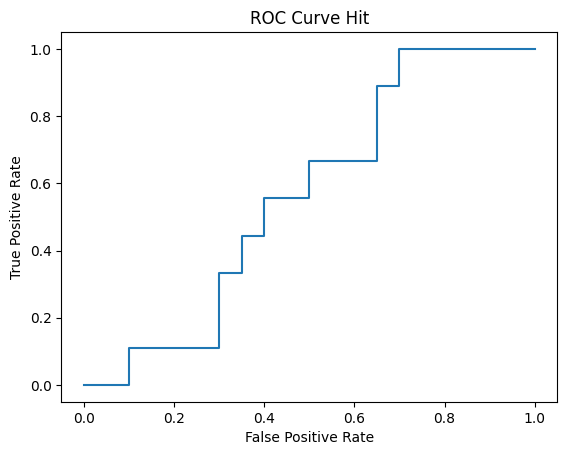

In [42]:
X_train, X_test, y_train, y_test = train_test_split(zero_alb_odds, zero_alb_hits, test_size=0.25, random_state=12312)
log_regression = LogisticRegression()
log_regression.fit(X_train, y_train)

y_pred_proba = log_regression.predict_proba(X_test)[:, 1]
print(y_pred_proba)

y_pred_odds = []
for proba in y_pred_proba:
    y_pred_odds.append(calculate_american_odds(calculate_dec_odds(proba, 4)))

print(y_pred_proba)
print(y_pred_odds)
print(y_test)

for i in range(len(X_test)):
    if X_test[i][0] < 0:
        print(f"odds : {X_test[i]}")
        print(f"y_test : {y_test[i]}")

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

# Create the ROC curve
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Hit')
plt.show()

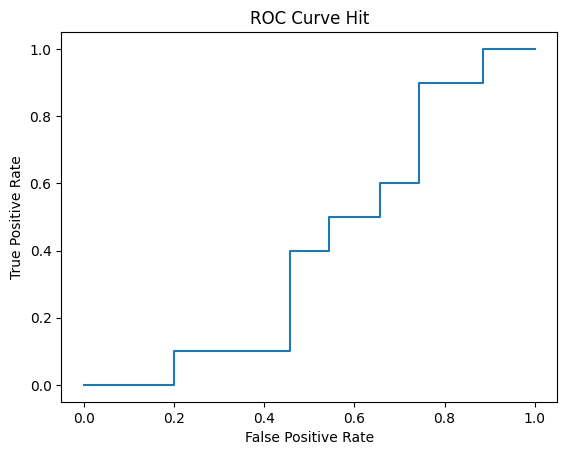

In [61]:
X_train, X_test, y_train, y_test = train_test_split(alba_odds, alba_hits, test_size=0.3)
log_regression = LogisticRegression()
log_regression.fit(X_train, y_train)

y_pred_proba = log_regression.predict_proba(X_test)[:, 1]
# print(y_pred_proba)

y_pred_odds = []
for proba in y_pred_proba:
    y_pred_odds.append(calculate_american_odds(calculate_dec_odds(proba, 4)))

# print(y_pred_proba)
# print(y_pred_odds)
# print(y_test)

# for i in range(len(X_test)):
#     print(f"odds : {X_test[i]}")
#     print(f"y_test : {y_test[i]}")

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

# Create the ROC curve
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Hit')
plt.show()

[0.29194095 0.30043844 0.30784969 0.29560417 0.29096761 0.2899388
 0.22523779 0.29346318 0.29352226 0.29426312 0.29650266 0.29548404
 0.29526199 0.2908164  0.29129402 0.29370767 0.2894366  0.29201045
 0.27766549 0.29242017 0.2942577  0.28994179 0.29127059 0.28936396
 0.29234368 0.2903101  0.29479894 0.28933949 0.3112908  0.30001178
 0.28940754 0.29795448 0.29371763 0.29235699 0.28993084 0.29204974
 0.29183054 0.2935777  0.29553647 0.29387835 0.29237007 0.30677335
 0.30606896 0.34174515 0.29160351 0.29812557 0.29323209 0.29188772
 0.29821887 0.3142298  0.29554072 0.23470095 0.29230055 0.2907085
 0.29430091 0.2899656  0.29131043 0.28956681 0.3023478  0.29407603
 0.29052268 0.28996621 0.29050691 0.29107796 0.29139972 0.29490384
 0.29169651 0.28910957 0.29186051 0.293383   0.29230433]
[31.017904697126546, 32.405975370584876, -298.447121168907, 31.63398143489129, 30.84944375338389, 30.669130963808527, 11.554931439468204, 31.277303532638133, 31.28727145373303, 31.411670539003094, 31.78090011

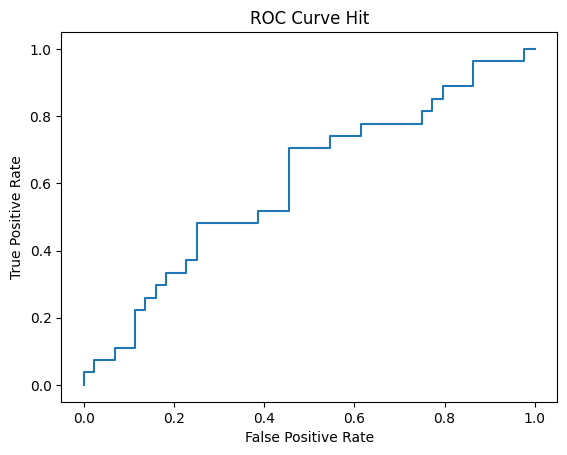

In [51]:
X_train, X_test, y_train, y_test = train_test_split(odds, hits, test_size=0.3, random_state=1)
log_regression = LogisticRegression()
log_regression.fit(X_train, y_train)

y_pred_proba = log_regression.predict_proba(X_test)[:, 1]
# print(y_pred_proba)

y_pred_odds = []
for proba in y_pred_proba:
    y_pred_odds.append(calculate_american_odds(calculate_dec_odds(proba, 3)))

print(y_pred_proba)
print(y_pred_odds)
print(y_test)

for i in range(len(y_pred_odds)):
    print(f"odds : {y_pred_odds[i]}")
    print(f"y_test : {y_test[i]}")

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_odds)

# Create the ROC curve
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Hit')
plt.show()